# BB84 QKD Parameters Optimization

## Fiber Lengths and n_X Values
Fiber lengths are created from 0 to 200 km in 0.1 km steps, resulting in 2001 unique fiber lengths. \
$n_X$ values are used ranging from $10^6$ to $10^{10}$, creating 5 unique values. \
Form all combinations of fiber lengths and $n_X$, resulting in 2001 $\times$ 5 = 10,005 combinations, which aligns with the aim to generate a large dataset.

## Optimization Process:
For each combination of fiber length $L$ and $n_X$, The parameters $\vec{p}$ = $ [ \mu_1, \mu_2, P_{\mu_1}, P_{\mu_2}, P_X ]$ are optimized using dual_annealing, which is a global optimization algorithm. \
The objective function is wrapped to evaluate the key rate for a specific combination of fiber length and $n_X$. 

## Parallelization:
joblib’s Parallel is used to run the optimization for all combinations in parallel, with 12 threads, making the process efficient. \
tqdm-joblib is also used to track progress visually. 

## Dataset Creation:
The results of the optimization ($e_1, e_2, e_3, e_4, n_X, R, p_{opt}$) are collected into a dataset. \
This dataset is saved to a file (training_dataset.json) for training a neural network. 




## Setup

### Framework Selection:JAX
Functional Programming: Simplify scientific computation and optimization workflows. \
Smaller Footprint: Ideal if the project doesn’t leverage TensorFlow’s broader ecosystem.

##### Key Considerations
For numerically intensive workloads (e.g., optimization tasks like QKD key rate calculations), JAX excels due to its lightweight functional paradigm.

##### Conclusion
Use JAX for performance-critical, purely numerical optimization tasks with minimal dependencies on machine learning frameworks.

In [1]:
# pip install --upgrade "jax[metal]" -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [2]:
# import jax
# print(jax.devices())

In [3]:
# pip uninstall jax jaxlib -y

In [4]:
# pip install "jax[metal]==0.4.14" -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [5]:
# import os
# os.environ["JAX_METAL_ENABLED"] = "True"

## Imports

In [6]:
# Import necessary libraries
import os
import sys
import time
import json
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor
from collections import defaultdict
from scipy.optimize import minimize, dual_annealing, differential_evolution, Bounds

# JAX imports
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.scipy.special import logsumexp, gamma
from jax.experimental import pjit
from jax.sharding import Mesh

# SciPy imports
from math import exp, factorial

# JAX configuration for double precision
jax.config.update("jax_enable_x64", True)

# Get the notebook's directory
notebook_dir = os.getcwd()
# Add parent directory to path
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

/Users/daai6ga1hou2/anaconda3/envs/qkd-training_set/lib/python3.9/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
# # import jax
# # import jax.numpy as jnp
# # from jax.scipy.optimize import dual_annealing

# # Check that JAX is using the MPS device
# print(jax.devices())

# # Define your objective function
# def objective(x):
#     return jnp.sum(x**2)

# # JIT compile the objective function for MPS
# jit_objective = jax.jit(objective)

# # Define bounds
# bounds = [(-5.0, 5.0), (-5.0, 5.0)]

# # Run dual annealing
# result = dual_annealing(jit_objective, bounds)

# print(result)

## Experimental Parameters

In [8]:
# e_1
# Fiber lengths
Ls = jnp.linspace(1e-12, 200, 2000)  # Fiber lengths in km
L_BC = Ls
e_1 = L_BC / 100
    
#e_2
P_dc_value = 6*10**-7  # Dark count probability
Y_0 = P_dc_value
# 2.7*10** -7
# P_dc = 6 * 10 ** (-7)   # given in the paper, discussed with range from 10^-8 to 10^-5
# e_2 = -jnp.log(Y_0)

# e_3
e_mis = 5 * 10 ** -3  # Misalignment error probability
# 0.026 
e_d = e_mis
e_3 = e_d * 100
e_mis = 5*1e-3 # given in the paper, discussed with range from 0 to 0.1 

# e_4
# Detected events
n_X_values = [10 ** s for s in range(4, 11)]  # Detected events
# n_X_values = jnp.array([10**s for s in range(6, 11)], dtype=jnp.int64)
N = n_X_values
e_4 = N

## Other Parameters

In [9]:
alpha = 0.2  # Attenuation coefficient (dB/km), given in the paper
eta_Bob = 0.1  # Detector efficiency, given in the paper
P_ap = 0  # After-pulse probability
f_EC = 1.16  # Error correction efficiency
# secutity error 
epsilon_sec = 1e-10 # is equal to kappa * secrecy length Kl, range around 1e-10 Scalar, as it is a single value throughout the calculations.
# correlation error
epsilon_cor = 1e-15 # given in the paper, discussed with range from 0 to 10e-10
# Dark count probability
n_event = 1  # for single photon event
# Misalignment error probability
# 4*1e-2          # given in the paper, discussed with range from 0 to 0.1
kappa = 1e-15           # given in the paper
f_EC = 1.16             # given in the paper, range around 1.1


## Optimal Paramters

In [10]:
def optimal_parameters(params):
    mu_1, mu_2, P_mu_1, P_mu_2, P_X_value = params
    mu_3 = 2e-4
    P_mu_3 = 1 - P_mu_1 - P_mu_2
    P_Z_value = 1 - P_X_value
    mu_k_values = jnp.array([mu_1, mu_2, mu_3])
    return params, mu_3, P_mu_3, P_Z_value, mu_k_values

## Functions

The calculate_factorial function provided uses the gamma function to compute the factorial of a number  n . This is mathematically correct because the gamma function  \Gamma(n+1)  is equivalent to the factorial  n!  for non-negative integers  n .

## Mathematical Background
The gamma function is defined as:
$\Gamma(x) = \int_0^\infty t^{x-1} e^{-t} \, dt$ \
For positive integers, the gamma function satisfies the relationship: \
$\Gamma(n + 1) = n!$
\
JAX does not have a built-in factorial function, but it does support the gamma function. This makes the approach valid and compatible with JAX for automatic differentiation and JIT compilation.

In [11]:
from QKD_Functions import (
calculate_factorial,
calculate_tau_n,
    calculate_eta_ch,
    calculate_eta_sys,
    calculate_D_mu_k,
    calculate_n_X_total,
    calculate_N,
    calculate_n_Z_total,
    calculate_e_mu_k,
    calculate_e_obs,
    calculate_h,
    calculate_lambda_EC,
    calculate_sqrt_term,
    calculate_tau_n,
    calculate_n_pm, 
    calculate_S_0,
    calculate_S_1,
    calculate_m_mu_k,
    calculate_m_pm,
    calculate_v_1,
    calculate_gamma,
    calculate_Phi,
    calculate_LastTwoTerm,
    calculate_l,
    calculate_R,
    experimental_parameters,
    other_parameters,
    calculate_key_rates_and_metrics,
    penalty, 
    objective,
)

In [12]:
# Initialize dataset storage
categorized_dataset = {n_X: [] for n_X in n_X_values}

In [13]:
import numpy as np
from scipy.optimize import dual_annealing, minimize
from tqdm import tqdm

# Initial guess and bounds
initial_guess = np.array([0.325684, 0.008542, 0.601268, 0.810905, 0.681594])
bounds = [
    (4e-4, 0.9),  
    (2e-4, 0.5),  
    (1e-12, 1.0 - 1e-12),  
    (1e-12, 1.0 - 1e-12),  
    (1e-12, 1.0 - 1e-12),  
]

# Define L values
L_values = np.linspace(1e-12, 200, 5000)
n_X_values = [1e6] #np.logspace(4, 9, 6)  # Logarithmically spaced values from 10^4 to 10^9

# Global variables
x0 = initial_guess.copy()  # Store the last used initial guess
last_valid_x0 = initial_guess.copy()  # Store the last valid parameters

def optimize_single_instance(L, n_X, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event):
    """Optimize key rate for a given fiber length L and fixed n_X."""
    global x0, last_valid_x0  

    print(f"\n--- [DEBUG] Starting optimization for L={L} km ---")

    try:
        def wrapped_objective(params):
            key_rate = objective(params, L, n_X, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)[0]
            return  -max(0, key_rate)
        
        print(f"🔵 Initial Guess for L={L}: {x0}")

        # Perform global optimization
        global_result = dual_annealing(
            func=wrapped_objective,
            bounds=bounds,
            initial_temp=20,  
            restart_temp_ratio=1e-8,  
            visit=2.0,  
            accept=-15.0,
            x0=x0
        )

        # Perform local refinement
        local_result = minimize(
            fun=wrapped_objective,
            x0=global_result.x,
            method='Nelder-Mead',
            options={'maxiter': 10000, 'xatol': 1e-10, 'fatol': 1e-10}
        )

        optimized_params = local_result.x
        optimized_params = np.clip(optimized_params,  
                           [b[0] for b in bounds], 
                           [b[1] for b in bounds])
        optimized_key_rate = -local_result.fun

        print(f"✅ Final Optimized Parameters for L={L} km: {optimized_params}")
        print(f"✅ Final Optimized Key Rate for L={L} km: {optimized_key_rate}")

        # Update x0 with the latest optimized parameters
        x0 = optimized_params.copy()

        # Check if parameters are within bounds
        out_of_bounds_flags = [param < b[0] or param > b[1] for param, b in zip(optimized_params, bounds)]
        out_of_bounds = any(out_of_bounds_flags)  

        if not out_of_bounds:
            return L, n_X, optimized_key_rate, optimized_params, optimized_params.copy()  
        else:
            print(f"⚠️ Parameters out of bounds for L={L} km, but keeping best parameters seen so far.")
            return L, n_X, optimized_key_rate, optimized_params, x0  

    except Exception as e:
        print(f"❌ Error at L={L}: {e}")
        return L, n_X, float('nan'), [float('nan')] * len(bounds), x0

# Run optimization for each n_X and L
all_results = []

for n_X in tqdm(n_X_values, desc="Processing n_X values"):
    print(f"\n--- Processing n_X={n_X} ---")  # Print the current n_X value being processed
    results = [optimize_single_instance(
        L, n_X, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
    ) for L in tqdm(L_values, leave=False, desc=f"Processing L values for n_X={n_X}")]
    all_results.extend(results)

# Sort results by n_X and then by L
all_results_sorted = sorted(all_results, key=lambda x: (x[1], x[0]))

# Print results in correct order
print("\n=== Ordered Optimization Results ===")
print(f"{'L (km)':<10}{'n_X':<15}{'Key Rate':<20}{'Initial Guess':<50}{'Optimized Parameters'}")
print("=" * 160)

for L, n_X, key_rate, params, init_guess in all_results_sorted:
    print(f"{L:<10}{n_X:<15}{key_rate:<20}{str(np.round(init_guess, 6)):<50}{np.round(params, 6)}")

Processing n_X values:   0%|          | 0/1 [00:00<?, ?it/s]


--- Processing n_X=1000000.0 ---



--- [DEBUG] Starting optimization for L=1e-12 km ---
🔵 Initial Guess for L=1e-12: [0.325684 0.008542 0.601268 0.810905 0.681594]


✅ Final Optimized Parameters for L=1e-12 km: [0.58523802 0.2927719  0.13383194 0.73452773 0.66829661]
✅ Final Optimized Key Rate for L=1e-12 km: 0.0044839008109471435

--- [DEBUG] Starting optimization for L=0.04000800160131986 km ---
🔵 Initial Guess for L=0.04000800160131986: [0.58523802 0.2927719  0.13383194 0.73452773 0.66829661]


✅ Final Optimized Parameters for L=0.04000800160131986 km: [0.58518868 0.29274886 0.13383247 0.73452439 0.6682948 ]
✅ Final Optimized Key Rate for L=0.04000800160131986 km: 0.004475339109952295

--- [DEBUG] Starting optimization for L=0.08001600320163973 km ---
🔵 Initial Guess for L=0.08001600320163973: [0.58518868 0.29274886 0.13383247 0.73452439 0.6682948 ]


✅ Final Optimized Parameters for L=0.08001600320163973 km: [0.58513941 0.29272587 0.13383303 0.734521   0.66829297]
✅ Final Optimized Key Rate for L=0.08001600320163973 km: 0.004466794302815822

--- [DEBUG] Starting optimization for L=0.1200240048019596 km ---
🔵 Initial Guess for L=0.1200240048019596: [0.58513941 0.29272587 0.13383303 0.734521   0.66829297]


✅ Final Optimized Parameters for L=0.1200240048019596 km: [0.58509026 0.29270293 0.13383356 0.73451767 0.66829115]
✅ Final Optimized Key Rate for L=0.1200240048019596 km: 0.004458266354122127

--- [DEBUG] Starting optimization for L=0.16003200640227946 km ---
🔵 Initial Guess for L=0.16003200640227946: [0.58509026 0.29270293 0.13383356 0.73451767 0.66829115]


✅ Final Optimized Parameters for L=0.16003200640227946 km: [0.5850412  0.29268003 0.13383414 0.73451431 0.66828933]
✅ Final Optimized Key Rate for L=0.16003200640227946 km: 0.0044497552285374335

--- [DEBUG] Starting optimization for L=0.20004000800259933 km ---
🔵 Initial Guess for L=0.20004000800259933: [0.5850412  0.29268003 0.13383414 0.73451431 0.66828933]


✅ Final Optimized Parameters for L=0.20004000800259933 km: [0.5849922  0.29265718 0.1338347  0.73451096 0.66828749]
✅ Final Optimized Key Rate for L=0.20004000800259933 km: 0.004441260890809642

--- [DEBUG] Starting optimization for L=0.2400480096029192 km ---
🔵 Initial Guess for L=0.2400480096029192: [0.5849922  0.29265718 0.1338347  0.73451096 0.66828749]


✅ Final Optimized Parameters for L=0.2400480096029192 km: [0.58494334 0.29263437 0.1338352  0.73450767 0.66828569]
✅ Final Optimized Key Rate for L=0.2400480096029192 km: 0.0044327833057682025

--- [DEBUG] Starting optimization for L=0.28005601120323903 km ---
🔵 Initial Guess for L=0.28005601120323903: [0.58494334 0.29263437 0.1338352  0.73450767 0.66828569]


✅ Final Optimized Parameters for L=0.28005601120323903 km: [0.58489458 0.29261163 0.13383575 0.73450432 0.66828388]
✅ Final Optimized Key Rate for L=0.28005601120323903 km: 0.004424322438323528

--- [DEBUG] Starting optimization for L=0.3200640128035589 km ---
🔵 Initial Guess for L=0.3200640128035589: [0.58489458 0.29261163 0.13383575 0.73450432 0.66828388]


✅ Final Optimized Parameters for L=0.3200640128035589 km: [0.58484584 0.29258888 0.13383634 0.73450098 0.66828208]
✅ Final Optimized Key Rate for L=0.3200640128035589 km: 0.004415878253467414

--- [DEBUG] Starting optimization for L=0.36007201440387876 km ---
🔵 Initial Guess for L=0.36007201440387876: [0.58484584 0.29258888 0.13383634 0.73450098 0.66828208]


✅ Final Optimized Parameters for L=0.36007201440387876 km: [0.58479726 0.2925662  0.13383685 0.73449768 0.66828028]
✅ Final Optimized Key Rate for L=0.36007201440387876 km: 0.004407450716272276

--- [DEBUG] Starting optimization for L=0.4000800160041986 km ---
🔵 Initial Guess for L=0.4000800160041986: [0.58479726 0.2925662  0.13383685 0.73449768 0.66828028]


✅ Final Optimized Parameters for L=0.4000800160041986 km: [0.58474874 0.29254357 0.13383745 0.73449433 0.66827847]
✅ Final Optimized Key Rate for L=0.4000800160041986 km: 0.0043990397918909335

--- [DEBUG] Starting optimization for L=0.4400880176045185 km ---
🔵 Initial Guess for L=0.4400880176045185: [0.58474874 0.29254357 0.13383745 0.73449433 0.66827847]


✅ Final Optimized Parameters for L=0.4400880176045185 km: [0.58470035 0.29252099 0.13383796 0.73449105 0.66827668]
✅ Final Optimized Key Rate for L=0.4400880176045185 km: 0.004390645445557038

--- [DEBUG] Starting optimization for L=0.48009601920483835 km ---
🔵 Initial Guess for L=0.48009601920483835: [0.58470035 0.29252099 0.13383796 0.73449105 0.66827668]


✅ Final Optimized Parameters for L=0.48009601920483835 km: [0.58465212 0.29249843 0.13383849 0.73448776 0.66827489]
✅ Final Optimized Key Rate for L=0.48009601920483835 km: 0.004382267642583928

--- [DEBUG] Starting optimization for L=0.5201040208051583 km ---
🔵 Initial Guess for L=0.5201040208051583: [0.58465212 0.29249843 0.13383849 0.73448776 0.66827489]


✅ Final Optimized Parameters for L=0.5201040208051583 km: [0.58460384 0.29247594 0.13383903 0.73448449 0.66827311]
✅ Final Optimized Key Rate for L=0.5201040208051583 km: 0.0043739063483653785

--- [DEBUG] Starting optimization for L=0.5601120224054781 km ---
🔵 Initial Guess for L=0.5601120224054781: [0.58460384 0.29247594 0.13383903 0.73448449 0.66827311]


✅ Final Optimized Parameters for L=0.5601120224054781 km: [0.58455573 0.29245348 0.13383956 0.73448121 0.66827132]
✅ Final Optimized Key Rate for L=0.5601120224054781 km: 0.0043655615283743595

--- [DEBUG] Starting optimization for L=0.6001200240057979 km ---
🔵 Initial Guess for L=0.6001200240057979: [0.58455573 0.29245348 0.13383956 0.73448121 0.66827132]


✅ Final Optimized Parameters for L=0.6001200240057979 km: [0.58450772 0.29243107 0.13384011 0.73447792 0.66826952]
✅ Final Optimized Key Rate for L=0.6001200240057979 km: 0.004357233148163895

--- [DEBUG] Starting optimization for L=0.6401280256061178 km ---
🔵 Initial Guess for L=0.6401280256061178: [0.58450772 0.29243107 0.13384011 0.73447792 0.66826952]


✅ Final Optimized Parameters for L=0.6401280256061178 km: [0.58445977 0.29240871 0.13384068 0.73447463 0.66826774]
✅ Final Optimized Key Rate for L=0.6401280256061178 km: 0.004348921173366086

--- [DEBUG] Starting optimization for L=0.6801360272064377 km ---
🔵 Initial Guess for L=0.6801360272064377: [0.58445977 0.29240871 0.13384068 0.73447463 0.66826774]


✅ Final Optimized Parameters for L=0.6801360272064377 km: [0.58441195 0.29238637 0.13384119 0.7344714  0.66826597]
✅ Final Optimized Key Rate for L=0.6801360272064377 km: 0.004340625569692182

--- [DEBUG] Starting optimization for L=0.7201440288067575 km ---
🔵 Initial Guess for L=0.7201440288067575: [0.58441195 0.29238637 0.13384119 0.7344714  0.66826597]


✅ Final Optimized Parameters for L=0.7201440288067575 km: [0.58436423 0.29236412 0.13384172 0.73446813 0.6682642 ]
✅ Final Optimized Key Rate for L=0.7201440288067575 km: 0.004332346302932271

--- [DEBUG] Starting optimization for L=0.7601520304070774 km ---
🔵 Initial Guess for L=0.7601520304070774: [0.58436423 0.29236412 0.13384172 0.73446813 0.6682642 ]


✅ Final Optimized Parameters for L=0.7601520304070774 km: [0.58431656 0.29234187 0.13384227 0.73446487 0.66826242]
✅ Final Optimized Key Rate for L=0.7601520304070774 km: 0.004324083338955282

--- [DEBUG] Starting optimization for L=0.8001600320073973 km ---
🔵 Initial Guess for L=0.8001600320073973: [0.58431656 0.29234187 0.13384227 0.73446487 0.66826242]


✅ Final Optimized Parameters for L=0.8001600320073973 km: [0.58426901 0.29231968 0.13384284 0.73446159 0.66826065]
✅ Final Optimized Key Rate for L=0.8001600320073973 km: 0.00431583664370861

--- [DEBUG] Starting optimization for L=0.8401680336077172 km ---
🔵 Initial Guess for L=0.8401680336077172: [0.58426901 0.29231968 0.13384284 0.73446159 0.66826065]


✅ Final Optimized Parameters for L=0.8401680336077172 km: [0.58422155 0.29229752 0.13384334 0.73445839 0.66825889]
✅ Final Optimized Key Rate for L=0.8401680336077172 km: 0.004307606183217813

--- [DEBUG] Starting optimization for L=0.880176035208037 km ---
🔵 Initial Guess for L=0.880176035208037: [0.58422155 0.29229752 0.13384334 0.73445839 0.66825889]


✅ Final Optimized Parameters for L=0.880176035208037 km: [0.58417418 0.29227542 0.13384391 0.73445509 0.66825712]
✅ Final Optimized Key Rate for L=0.880176035208037 km: 0.0042993919235867475

--- [DEBUG] Starting optimization for L=0.9201840368083568 km ---
🔵 Initial Guess for L=0.9201840368083568: [0.58417418 0.29227542 0.13384391 0.73445509 0.66825712]


✅ Final Optimized Parameters for L=0.9201840368083568 km: [0.58412683 0.29225334 0.13384441 0.73445192 0.66825537]
✅ Final Optimized Key Rate for L=0.9201840368083568 km: 0.0042911938309969765

--- [DEBUG] Starting optimization for L=0.9601920384086767 km ---
🔵 Initial Guess for L=0.9601920384086767: [0.58412683 0.29225334 0.13384441 0.73445192 0.66825537]


✅ Final Optimized Parameters for L=0.9601920384086767 km: [0.58407973 0.29223133 0.13384496 0.73444867 0.6682536 ]
✅ Final Optimized Key Rate for L=0.9601920384086767 km: 0.0042830118717078315

--- [DEBUG] Starting optimization for L=1.0002000400089968 km ---
🔵 Initial Guess for L=1.0002000400089968: [0.58407973 0.29223133 0.13384496 0.73444867 0.6682536 ]


✅ Final Optimized Parameters for L=1.0002000400089968 km: [0.58403257 0.29220934 0.13384552 0.73444542 0.66825188]
✅ Final Optimized Key Rate for L=1.0002000400089968 km: 0.004274846012056026

--- [DEBUG] Starting optimization for L=1.0402080416093167 km ---
🔵 Initial Guess for L=1.0402080416093167: [0.58403257 0.29220934 0.13384552 0.73444542 0.66825188]


✅ Final Optimized Parameters for L=1.0402080416093167 km: [0.58398556 0.29218741 0.13384608 0.7344422  0.66825011]
✅ Final Optimized Key Rate for L=1.0402080416093167 km: 0.004266696218455686

--- [DEBUG] Starting optimization for L=1.0802160432096364 km ---
🔵 Initial Guess for L=1.0802160432096364: [0.58398556 0.29218741 0.13384608 0.7344422  0.66825011]


✅ Final Optimized Parameters for L=1.0802160432096364 km: [0.58393874 0.29216553 0.1338466  0.73443901 0.66824835]
✅ Final Optimized Key Rate for L=1.0802160432096364 km: 0.004258562457397856

--- [DEBUG] Starting optimization for L=1.1202240448099563 km ---
🔵 Initial Guess for L=1.1202240448099563: [0.58393874 0.29216553 0.1338466  0.73443901 0.66824835]


✅ Final Optimized Parameters for L=1.1202240448099563 km: [0.58389185 0.29214365 0.13384712 0.73443581 0.66824662]
✅ Final Optimized Key Rate for L=1.1202240448099563 km: 0.004250444695450477

--- [DEBUG] Starting optimization for L=1.1602320464102762 km ---
🔵 Initial Guess for L=1.1602320464102762: [0.58389185 0.29214365 0.13384712 0.73443581 0.66824662]


✅ Final Optimized Parameters for L=1.1602320464102762 km: [0.5838451  0.29212185 0.13384765 0.73443261 0.66824488]
✅ Final Optimized Key Rate for L=1.1602320464102762 km: 0.004242342899258262

--- [DEBUG] Starting optimization for L=1.200240048010596 km ---
🔵 Initial Guess for L=1.200240048010596: [0.5838451  0.29212185 0.13384765 0.73443261 0.66824488]


✅ Final Optimized Parameters for L=1.200240048010596 km: [0.58379853 0.2921001  0.13384816 0.73442944 0.66824313]
✅ Final Optimized Key Rate for L=1.200240048010596 km: 0.00423425703554229

--- [DEBUG] Starting optimization for L=1.2402480496109158 km ---
🔵 Initial Guess for L=1.2402480496109158: [0.58379853 0.2921001  0.13384816 0.73442944 0.66824313]


✅ Final Optimized Parameters for L=1.2402480496109158 km: [0.58375198 0.29207837 0.13384872 0.73442622 0.6682414 ]
✅ Final Optimized Key Rate for L=1.2402480496109158 km: 0.004226187071099914

--- [DEBUG] Starting optimization for L=1.2802560512112358 km ---
🔵 Initial Guess for L=1.2802560512112358: [0.58375198 0.29207837 0.13384872 0.73442622 0.6682414 ]


✅ Final Optimized Parameters for L=1.2802560512112358 km: [0.58370554 0.29205669 0.13384926 0.73442303 0.66823967]
✅ Final Optimized Key Rate for L=1.2802560512112358 km: 0.00421813297280448

--- [DEBUG] Starting optimization for L=1.3202640528115557 km ---
🔵 Initial Guess for L=1.3202640528115557: [0.58370554 0.29205669 0.13384926 0.73442303 0.66823967]


✅ Final Optimized Parameters for L=1.3202640528115557 km: [0.58365917 0.29203506 0.13384977 0.73441988 0.66823794]
✅ Final Optimized Key Rate for L=1.3202640528115557 km: 0.004210094707605417

--- [DEBUG] Starting optimization for L=1.3602720544118756 km ---
🔵 Initial Guess for L=1.3602720544118756: [0.58365917 0.29203506 0.13384977 0.73441988 0.66823794]


✅ Final Optimized Parameters for L=1.3602720544118756 km: [0.58361286 0.29201344 0.13385028 0.73441676 0.66823622]
✅ Final Optimized Key Rate for L=1.3602720544118756 km: 0.004202072242527491

--- [DEBUG] Starting optimization for L=1.4002800560121953 km ---
🔵 Initial Guess for L=1.4002800560121953: [0.58361286 0.29201344 0.13385028 0.73441676 0.66823622]


✅ Final Optimized Parameters for L=1.4002800560121953 km: [0.58356668 0.29199188 0.13385083 0.73441356 0.66823449]
✅ Final Optimized Key Rate for L=1.4002800560121953 km: 0.0041940655446713725

--- [DEBUG] Starting optimization for L=1.4402880576125152 km ---
🔵 Initial Guess for L=1.4402880576125152: [0.58356668 0.29199188 0.13385083 0.73441356 0.66823449]


✅ Final Optimized Parameters for L=1.4402880576125152 km: [0.58352061 0.29197038 0.13385135 0.7344104  0.66823277]
✅ Final Optimized Key Rate for L=1.4402880576125152 km: 0.004186074581212684

--- [DEBUG] Starting optimization for L=1.4802960592128351 km ---
🔵 Initial Guess for L=1.4802960592128351: [0.58352061 0.29197038 0.13385135 0.7344104  0.66823277]


✅ Final Optimized Parameters for L=1.4802960592128351 km: [0.58347463 0.29194891 0.1338519  0.73440723 0.66823105]
✅ Final Optimized Key Rate for L=1.4802960592128351 km: 0.004178099319402083

--- [DEBUG] Starting optimization for L=1.5203040608131548 km ---
🔵 Initial Guess for L=1.5203040608131548: [0.58347463 0.29194891 0.1338519  0.73440723 0.66823105]


✅ Final Optimized Parameters for L=1.5203040608131548 km: [0.58342878 0.29192749 0.13385244 0.73440406 0.66822931]
✅ Final Optimized Key Rate for L=1.5203040608131548 km: 0.004170139726565257

--- [DEBUG] Starting optimization for L=1.5603120624134748 km ---
🔵 Initial Guess for L=1.5603120624134748: [0.58342878 0.29192749 0.13385244 0.73440406 0.66822931]


✅ Final Optimized Parameters for L=1.5603120624134748 km: [0.5833829  0.29190608 0.13385295 0.73440094 0.66822763]
✅ Final Optimized Key Rate for L=1.5603120624134748 km: 0.004162195770102711

--- [DEBUG] Starting optimization for L=1.6003200640137947 km ---
🔵 Initial Guess for L=1.6003200640137947: [0.5833829  0.29190608 0.13385295 0.73440094 0.66822763]


✅ Final Optimized Parameters for L=1.6003200640137947 km: [0.58333713 0.29188477 0.1338535  0.73439781 0.6682259 ]
✅ Final Optimized Key Rate for L=1.6003200640137947 km: 0.0041542674174890794

--- [DEBUG] Starting optimization for L=1.6403280656141146 km ---
🔵 Initial Guess for L=1.6403280656141146: [0.58333713 0.29188477 0.1338535  0.73439781 0.6682259 ]


✅ Final Optimized Parameters for L=1.6403280656141146 km: [0.58329154 0.29186346 0.133854   0.73439468 0.66822422]
✅ Final Optimized Key Rate for L=1.6403280656141146 km: 0.004146354636273677

--- [DEBUG] Starting optimization for L=1.6803360672144345 km ---
🔵 Initial Guess for L=1.6803360672144345: [0.58329154 0.29186346 0.133854   0.73439468 0.66822422]


✅ Final Optimized Parameters for L=1.6803360672144345 km: [0.58324592 0.2918422  0.13385455 0.73439148 0.66822251]
✅ Final Optimized Key Rate for L=1.6803360672144345 km: 0.0041384573940794565

--- [DEBUG] Starting optimization for L=1.7203440688147542 km ---
🔵 Initial Guess for L=1.7203440688147542: [0.58324592 0.2918422  0.13385455 0.73439148 0.66822251]


✅ Final Optimized Parameters for L=1.7203440688147542 km: [0.58320046 0.29182097 0.13385503 0.73438846 0.66822081]
✅ Final Optimized Key Rate for L=1.7203440688147542 km: 0.004130575658603915

--- [DEBUG] Starting optimization for L=1.7603520704150741 km ---
🔵 Initial Guess for L=1.7603520704150741: [0.58320046 0.29182097 0.13385503 0.73438846 0.66822081]


✅ Final Optimized Parameters for L=1.7603520704150741 km: [0.58315512 0.29179979 0.1338556  0.73438529 0.66821911]
✅ Final Optimized Key Rate for L=1.7603520704150741 km: 0.004122709397617677

--- [DEBUG] Starting optimization for L=1.800360072015394 km ---
🔵 Initial Guess for L=1.800360072015394: [0.58315512 0.29179979 0.1338556  0.73438529 0.66821911]


✅ Final Optimized Parameters for L=1.800360072015394 km: [0.58310986 0.29177867 0.1338561  0.73438219 0.66821741]
✅ Final Optimized Key Rate for L=1.800360072015394 km: 0.004114858578965145

--- [DEBUG] Starting optimization for L=1.8403680736157138 km ---
🔵 Initial Guess for L=1.8403680736157138: [0.58310986 0.29177867 0.1338561  0.73438219 0.66821741]


✅ Final Optimized Parameters for L=1.8403680736157138 km: [0.58306465 0.29175754 0.13385663 0.73437911 0.66821572]
✅ Final Optimized Key Rate for L=1.8403680736157138 km: 0.004107023170564038

--- [DEBUG] Starting optimization for L=1.8803760752160337 km ---
🔵 Initial Guess for L=1.8803760752160337: [0.58306465 0.29175754 0.13385663 0.73437911 0.66821572]


✅ Final Optimized Parameters for L=1.8803760752160337 km: [0.58301955 0.2917365  0.13385712 0.73437603 0.66821405]
✅ Final Optimized Key Rate for L=1.8803760752160337 km: 0.0040992031404053515

--- [DEBUG] Starting optimization for L=1.9203840768163536 km ---
🔵 Initial Guess for L=1.9203840768163536: [0.58301955 0.2917365  0.13385712 0.73437603 0.66821405]


✅ Final Optimized Parameters for L=1.9203840768163536 km: [0.58297454 0.2917155  0.13385766 0.73437291 0.66821235]
✅ Final Optimized Key Rate for L=1.9203840768163536 km: 0.004091398456552749

--- [DEBUG] Starting optimization for L=1.9603920784166735 km ---
🔵 Initial Guess for L=1.9603920784166735: [0.58297454 0.2917155  0.13385766 0.73437291 0.66821235]


✅ Final Optimized Parameters for L=1.9603920784166735 km: [0.58292962 0.29169453 0.13385821 0.7343698  0.66821067]
✅ Final Optimized Key Rate for L=1.9603920784166735 km: 0.004083609087142909

--- [DEBUG] Starting optimization for L=2.0004000800169934 km ---
🔵 Initial Guess for L=2.0004000800169934: [0.58292962 0.29169453 0.13385821 0.7343698  0.66821067]


✅ Final Optimized Parameters for L=2.0004000800169934 km: [0.58288479 0.2916736  0.13385871 0.73436676 0.66820899]
✅ Final Optimized Key Rate for L=2.0004000800169934 km: 0.004075835000384997

--- [DEBUG] Starting optimization for L=2.040408081617313 km ---
🔵 Initial Guess for L=2.040408081617313: [0.58288479 0.2916736  0.13385871 0.73436676 0.66820899]


✅ Final Optimized Parameters for L=2.040408081617313 km: [0.58284002 0.29165269 0.13385923 0.73436368 0.66820731]
✅ Final Optimized Key Rate for L=2.040408081617313 km: 0.004068076164560525

--- [DEBUG] Starting optimization for L=2.0804160832176333 km ---
🔵 Initial Guess for L=2.0804160832176333: [0.58284002 0.29165269 0.13385923 0.73436368 0.66820731]


✅ Final Optimized Parameters for L=2.0804160832176333 km: [0.58279534 0.29163183 0.13385976 0.7343606  0.66820564]
✅ Final Optimized Key Rate for L=2.0804160832176333 km: 0.004060332548023217

--- [DEBUG] Starting optimization for L=2.120424084817953 km ---
🔵 Initial Guess for L=2.120424084817953: [0.58279534 0.29163183 0.13385976 0.7343606  0.66820564]


✅ Final Optimized Parameters for L=2.120424084817953 km: [0.58275081 0.29161103 0.13386025 0.73435756 0.66820397]
✅ Final Optimized Key Rate for L=2.120424084817953 km: 0.004052604119198927

--- [DEBUG] Starting optimization for L=2.1604320864182727 km ---
🔵 Initial Guess for L=2.1604320864182727: [0.58275081 0.29161103 0.13386025 0.73435756 0.66820397]


✅ Final Optimized Parameters for L=2.1604320864182727 km: [0.58270629 0.29159027 0.1338608  0.73435446 0.66820231]
✅ Final Optimized Key Rate for L=2.1604320864182727 km: 0.004044890846585157

--- [DEBUG] Starting optimization for L=2.200440088018593 km ---
🔵 Initial Guess for L=2.200440088018593: [0.58270629 0.29159027 0.1338608  0.73435446 0.66820231]


✅ Final Optimized Parameters for L=2.200440088018593 km: [0.58266185 0.29156954 0.13386134 0.73435139 0.66820063]
✅ Final Optimized Key Rate for L=2.200440088018593 km: 0.00403719269875121

--- [DEBUG] Starting optimization for L=2.2404480896189125 km ---
🔵 Initial Guess for L=2.2404480896189125: [0.58266185 0.29156954 0.13386134 0.73435139 0.66820063]


✅ Final Optimized Parameters for L=2.2404480896189125 km: [0.58261753 0.29154885 0.13386182 0.73434838 0.66819896]
✅ Final Optimized Key Rate for L=2.2404480896189125 km: 0.004029509644337753

--- [DEBUG] Starting optimization for L=2.280456091219232 km ---
🔵 Initial Guess for L=2.280456091219232: [0.58261753 0.29154885 0.13386182 0.73434838 0.66819896]


✅ Final Optimized Parameters for L=2.280456091219232 km: [0.58257333 0.29152821 0.13386234 0.73434533 0.66819731]
✅ Final Optimized Key Rate for L=2.280456091219232 km: 0.0040218416520567575

--- [DEBUG] Starting optimization for L=2.3204640928195523 km ---
🔵 Initial Guess for L=2.3204640928195523: [0.58257333 0.29152821 0.13386234 0.73434533 0.66819731]


✅ Final Optimized Parameters for L=2.3204640928195523 km: [0.58252916 0.2915076  0.13386286 0.73434229 0.66819565]
✅ Final Optimized Key Rate for L=2.3204640928195523 km: 0.004014188690691189

--- [DEBUG] Starting optimization for L=2.360472094419872 km ---
🔵 Initial Guess for L=2.360472094419872: [0.58252916 0.2915076  0.13386286 0.73434229 0.66819565]


✅ Final Optimized Parameters for L=2.360472094419872 km: [0.58248509 0.29148703 0.13386338 0.73433925 0.668194  ]
✅ Final Optimized Key Rate for L=2.360472094419872 km: 0.004006550729095109

--- [DEBUG] Starting optimization for L=2.4004800960201917 km ---
🔵 Initial Guess for L=2.4004800960201917: [0.58248509 0.29148703 0.13386338 0.73433925 0.668194  ]


✅ Final Optimized Parameters for L=2.4004800960201917 km: [0.58244113 0.29146648 0.13386388 0.73433624 0.66819234]
✅ Final Optimized Key Rate for L=2.4004800960201917 km: 0.003998927736193138

--- [DEBUG] Starting optimization for L=2.440488097620512 km ---
🔵 Initial Guess for L=2.440488097620512: [0.58244113 0.29146648 0.13386388 0.73433624 0.66819234]


✅ Final Optimized Parameters for L=2.440488097620512 km: [0.58239721 0.291446   0.13386442 0.73433319 0.6681907 ]
✅ Final Optimized Key Rate for L=2.440488097620512 km: 0.0039913196809804605

--- [DEBUG] Starting optimization for L=2.4804960992208316 km ---
🔵 Initial Guess for L=2.4804960992208316: [0.58239721 0.291446   0.13386442 0.73433319 0.6681907 ]


✅ Final Optimized Parameters for L=2.4804960992208316 km: [0.58235341 0.29142554 0.13386494 0.73433017 0.66818905]
✅ Final Optimized Key Rate for L=2.4804960992208316 km: 0.003983726532522656

--- [DEBUG] Starting optimization for L=2.5205041008211517 km ---
🔵 Initial Guess for L=2.5205041008211517: [0.58235341 0.29142554 0.13386494 0.73433017 0.66818905]


✅ Final Optimized Parameters for L=2.5205041008211517 km: [0.58230967 0.29140516 0.13386547 0.73432715 0.66818741]
✅ Final Optimized Key Rate for L=2.5205041008211517 km: 0.003976148259955431

--- [DEBUG] Starting optimization for L=2.5605121024214714 km ---
🔵 Initial Guess for L=2.5605121024214714: [0.58230967 0.29140516 0.13386547 0.73432715 0.66818741]


✅ Final Optimized Parameters for L=2.5605121024214714 km: [0.58226609 0.29138479 0.13386597 0.73432417 0.66818577]
✅ Final Optimized Key Rate for L=2.5605121024214714 km: 0.0039685848324846245

--- [DEBUG] Starting optimization for L=2.600520104021791 km ---
🔵 Initial Guess for L=2.600520104021791: [0.58226609 0.29138479 0.13386597 0.73432417 0.66818577]


✅ Final Optimized Parameters for L=2.600520104021791 km: [0.58222258 0.29136445 0.13386644 0.73432121 0.66818413]
✅ Final Optimized Key Rate for L=2.600520104021791 km: 0.003961036219385652

--- [DEBUG] Starting optimization for L=2.6405281056221113 km ---
🔵 Initial Guess for L=2.6405281056221113: [0.58222258 0.29136445 0.13386644 0.73432121 0.66818413]


✅ Final Optimized Parameters for L=2.6405281056221113 km: [0.58217907 0.29134415 0.13386698 0.73431819 0.66818251]
✅ Final Optimized Key Rate for L=2.6405281056221113 km: 0.003953502390003679

--- [DEBUG] Starting optimization for L=2.680536107222431 km ---
🔵 Initial Guess for L=2.680536107222431: [0.58217907 0.29134415 0.13386698 0.73431819 0.66818251]


✅ Final Optimized Parameters for L=2.680536107222431 km: [0.58213569 0.29132392 0.1338675  0.73431518 0.66818085]
✅ Final Optimized Key Rate for L=2.680536107222431 km: 0.003945983313753413

--- [DEBUG] Starting optimization for L=2.720544108822751 km ---
🔵 Initial Guess for L=2.720544108822751: [0.58213569 0.29132392 0.1338675  0.73431518 0.66818085]


✅ Final Optimized Parameters for L=2.720544108822751 km: [0.5820924  0.2913037  0.133868   0.73431221 0.66817924]
✅ Final Optimized Key Rate for L=2.720544108822751 km: 0.003938478960118708

--- [DEBUG] Starting optimization for L=2.760552110423071 km ---
🔵 Initial Guess for L=2.760552110423071: [0.5820924  0.2913037  0.133868   0.73431221 0.66817924]


✅ Final Optimized Parameters for L=2.760552110423071 km: [0.58204923 0.29128353 0.13386849 0.73430926 0.66817759]
✅ Final Optimized Key Rate for L=2.760552110423071 km: 0.003930989298652484

--- [DEBUG] Starting optimization for L=2.8005601120233905 km ---
🔵 Initial Guess for L=2.8005601120233905: [0.58204923 0.29128353 0.13386849 0.73430926 0.66817759]


✅ Final Optimized Parameters for L=2.8005601120233905 km: [0.58200608 0.29126339 0.13386903 0.73430624 0.66817597]
✅ Final Optimized Key Rate for L=2.8005601120233905 km: 0.0039235142989768185

--- [DEBUG] Starting optimization for L=2.8405681136237106 km ---
🔵 Initial Guess for L=2.8405681136237106: [0.58200608 0.29126339 0.13386903 0.73430624 0.66817597]


✅ Final Optimized Parameters for L=2.8405681136237106 km: [0.58196304 0.29124329 0.13386954 0.73430327 0.66817436]
✅ Final Optimized Key Rate for L=2.8405681136237106 km: 0.003916053930782174

--- [DEBUG] Starting optimization for L=2.8805761152240303 km ---
🔵 Initial Guess for L=2.8805761152240303: [0.58196304 0.29124329 0.13386954 0.73430327 0.66817436]


✅ Final Optimized Parameters for L=2.8805761152240303 km: [0.58192004 0.29122324 0.13387005 0.73430031 0.66817274]
✅ Final Optimized Key Rate for L=2.8805761152240303 km: 0.003908608163827808

--- [DEBUG] Starting optimization for L=2.92058411682435 km ---
🔵 Initial Guess for L=2.92058411682435: [0.58192004 0.29122324 0.13387005 0.73430031 0.66817274]


✅ Final Optimized Parameters for L=2.92058411682435 km: [0.5818772  0.29120324 0.13387055 0.73429737 0.66817113]
✅ Final Optimized Key Rate for L=2.92058411682435 km: 0.0039011769679414155

--- [DEBUG] Starting optimization for L=2.96059211842467 km ---
🔵 Initial Guess for L=2.96059211842467: [0.5818772  0.29120324 0.13387055 0.73429737 0.66817113]


✅ Final Optimized Parameters for L=2.96059211842467 km: [0.58183441 0.29118325 0.13387106 0.73429441 0.66816951]
✅ Final Optimized Key Rate for L=2.96059211842467 km: 0.003893760313018717

--- [DEBUG] Starting optimization for L=3.00060012002499 km ---
🔵 Initial Guess for L=3.00060012002499: [0.58183441 0.29118325 0.13387106 0.73429441 0.66816951]


✅ Final Optimized Parameters for L=3.00060012002499 km: [0.58179169 0.29116331 0.13387158 0.73429145 0.66816791]
✅ Final Optimized Key Rate for L=3.00060012002499 km: 0.003886358169023522

--- [DEBUG] Starting optimization for L=3.0406081216253096 km ---
🔵 Initial Guess for L=3.0406081216253096: [0.58179169 0.29116331 0.13387158 0.73429145 0.66816791]


✅ Final Optimized Parameters for L=3.0406081216253096 km: [0.5817491  0.29114343 0.13387207 0.7342885  0.66816628]
✅ Final Optimized Key Rate for L=3.0406081216253096 km: 0.0038789705059875884

--- [DEBUG] Starting optimization for L=3.0806161232256297 km ---
🔵 Initial Guess for L=3.0806161232256297: [0.5817491  0.29114343 0.13387207 0.7342885  0.66816628]


✅ Final Optimized Parameters for L=3.0806161232256297 km: [0.5817066  0.29112358 0.13387256 0.7342856  0.66816468]
✅ Final Optimized Key Rate for L=3.0806161232256297 km: 0.0038715972940103617

--- [DEBUG] Starting optimization for L=3.1206241248259494 km ---
🔵 Initial Guess for L=3.1206241248259494: [0.5817066  0.29112358 0.13387256 0.7342856  0.66816468]


✅ Final Optimized Parameters for L=3.1206241248259494 km: [0.58166412 0.29110374 0.13387308 0.73428266 0.66816308]
✅ Final Optimized Key Rate for L=3.1206241248259494 km: 0.0038642385032586764

--- [DEBUG] Starting optimization for L=3.1606321264262696 km ---
🔵 Initial Guess for L=3.1606321264262696: [0.58166412 0.29110374 0.13387308 0.73428266 0.66816308]


✅ Final Optimized Parameters for L=3.1606321264262696 km: [0.5816217  0.29108395 0.13387359 0.73427972 0.66816148]
✅ Final Optimized Key Rate for L=3.1606321264262696 km: 0.0038568941039668373

--- [DEBUG] Starting optimization for L=3.2006401280265893 km ---
🔵 Initial Guess for L=3.2006401280265893: [0.5816217  0.29108395 0.13387359 0.73427972 0.66816148]


✅ Final Optimized Parameters for L=3.2006401280265893 km: [0.5815794  0.29106422 0.13387412 0.73427676 0.66815988]
✅ Final Optimized Key Rate for L=3.2006401280265893 km: 0.00384956406643615

--- [DEBUG] Starting optimization for L=3.240648129626909 km ---
🔵 Initial Guess for L=3.240648129626909: [0.5815794  0.29106422 0.13387412 0.73427676 0.66815988]


✅ Final Optimized Parameters for L=3.240648129626909 km: [0.58153719 0.2910445  0.13387462 0.73427386 0.66815829]
✅ Final Optimized Key Rate for L=3.240648129626909 km: 0.0038422483610351106

--- [DEBUG] Starting optimization for L=3.280656131227229 km ---
🔵 Initial Guess for L=3.280656131227229: [0.58153719 0.2910445  0.13387462 0.73427386 0.66815829]


✅ Final Optimized Parameters for L=3.280656131227229 km: [0.58149507 0.29102484 0.13387515 0.73427093 0.6681567 ]
✅ Final Optimized Key Rate for L=3.280656131227229 km: 0.003834946958198945

--- [DEBUG] Starting optimization for L=3.320664132827549 km ---
🔵 Initial Guess for L=3.320664132827549: [0.58149507 0.29102484 0.13387515 0.73427093 0.6681567 ]


✅ Final Optimized Parameters for L=3.320664132827549 km: [0.58145306 0.29100521 0.1338756  0.73426807 0.66815511]
✅ Final Optimized Key Rate for L=3.320664132827549 km: 0.0038276598284296107

--- [DEBUG] Starting optimization for L=3.360672134427869 km ---
🔵 Initial Guess for L=3.360672134427869: [0.58145306 0.29100521 0.1338756  0.73426807 0.66815511]


✅ Final Optimized Parameters for L=3.360672134427869 km: [0.58141108 0.29098562 0.1338761  0.73426518 0.66815352]
✅ Final Optimized Key Rate for L=3.360672134427869 km: 0.0038203869422953254

--- [DEBUG] Starting optimization for L=3.4006801360281886 km ---
🔵 Initial Guess for L=3.4006801360281886: [0.58141108 0.29098562 0.1338761  0.73426518 0.66815352]


✅ Final Optimized Parameters for L=3.4006801360281886 km: [0.5813692  0.29096605 0.13387661 0.73426226 0.66815193]
✅ Final Optimized Key Rate for L=3.4006801360281886 km: 0.0038131282704308646

--- [DEBUG] Starting optimization for L=3.4406881376285083 km ---
🔵 Initial Guess for L=3.4406881376285083: [0.5813692  0.29096605 0.13387661 0.73426226 0.66815193]


✅ Final Optimized Parameters for L=3.4406881376285083 km: [0.58132739 0.29094653 0.13387709 0.73425939 0.66815037]
✅ Final Optimized Key Rate for L=3.4406881376285083 km: 0.0038058837835370234

--- [DEBUG] Starting optimization for L=3.4806961392288285 km ---
🔵 Initial Guess for L=3.4806961392288285: [0.58132739 0.29094653 0.13387709 0.73425939 0.66815037]


✅ Final Optimized Parameters for L=3.4806961392288285 km: [0.58128568 0.29092707 0.13387762 0.73425647 0.66814878]
✅ Final Optimized Key Rate for L=3.4806961392288285 km: 0.0037986534523806823

--- [DEBUG] Starting optimization for L=3.520704140829148 km ---
🔵 Initial Guess for L=3.520704140829148: [0.58128568 0.29092707 0.13387762 0.73425647 0.66814878]


✅ Final Optimized Parameters for L=3.520704140829148 km: [0.58124407 0.29090763 0.13387811 0.7342536  0.6681472 ]
✅ Final Optimized Key Rate for L=3.520704140829148 km: 0.003791437247794339

--- [DEBUG] Starting optimization for L=3.560712142429468 km ---
🔵 Initial Guess for L=3.560712142429468: [0.58124407 0.29090763 0.13387811 0.7342536  0.6681472 ]


✅ Final Optimized Parameters for L=3.560712142429468 km: [0.58120254 0.29088823 0.1338786  0.73425074 0.66814563]
✅ Final Optimized Key Rate for L=3.560712142429468 km: 0.003784235140676299

--- [DEBUG] Starting optimization for L=3.600720144029788 km ---
🔵 Initial Guess for L=3.600720144029788: [0.58120254 0.29088823 0.1338786  0.73425074 0.66814563]


✅ Final Optimized Parameters for L=3.600720144029788 km: [0.58116104 0.29086888 0.13387912 0.73424783 0.66814405]
✅ Final Optimized Key Rate for L=3.600720144029788 km: 0.003777047101990233

--- [DEBUG] Starting optimization for L=3.6407281456301077 km ---
🔵 Initial Guess for L=3.6407281456301077: [0.58116104 0.29086888 0.13387912 0.73424783 0.66814405]


✅ Final Optimized Parameters for L=3.6407281456301077 km: [0.58111964 0.29084955 0.13387959 0.73424501 0.66814249]
✅ Final Optimized Key Rate for L=3.6407281456301077 km: 0.003769873102765252

--- [DEBUG] Starting optimization for L=3.6807361472304274 km ---
🔵 Initial Guess for L=3.6807361472304274: [0.58111964 0.29084955 0.13387959 0.73424501 0.66814249]


✅ Final Optimized Parameters for L=3.6807361472304274 km: [0.58107834 0.29083026 0.13388009 0.73424214 0.66814092]
✅ Final Optimized Key Rate for L=3.6807361472304274 km: 0.003762713114095418

--- [DEBUG] Starting optimization for L=3.7207441488307476 km ---
🔵 Initial Guess for L=3.7207441488307476: [0.58107834 0.29083026 0.13388009 0.73424214 0.66814092]


✅ Final Optimized Parameters for L=3.7207441488307476 km: [0.58103708 0.29081102 0.13388062 0.73423926 0.66813935]
✅ Final Optimized Key Rate for L=3.7207441488307476 km: 0.0037555671071399055

--- [DEBUG] Starting optimization for L=3.7607521504310673 km ---
🔵 Initial Guess for L=3.7607521504310673: [0.58103708 0.29081102 0.13388062 0.73423926 0.66813935]


✅ Final Optimized Parameters for L=3.7607521504310673 km: [0.58099594 0.29079178 0.1338811  0.73423642 0.6681378 ]
✅ Final Optimized Key Rate for L=3.7607521504310673 km: 0.0037484350531226205

--- [DEBUG] Starting optimization for L=3.8007601520313874 km ---
🔵 Initial Guess for L=3.8007601520313874: [0.58099594 0.29079178 0.1338811  0.73423642 0.6681378 ]


✅ Final Optimized Parameters for L=3.8007601520313874 km: [0.58095482 0.29077259 0.13388159 0.73423359 0.66813624]
✅ Final Optimized Key Rate for L=3.8007601520313874 km: 0.0037413169233321227

--- [DEBUG] Starting optimization for L=3.840768153631707 km ---
🔵 Initial Guess for L=3.840768153631707: [0.58095482 0.29077259 0.13388159 0.73423359 0.66813624]


✅ Final Optimized Parameters for L=3.840768153631707 km: [0.5809139  0.29075347 0.1338821  0.73423072 0.66813468]
✅ Final Optimized Key Rate for L=3.840768153631707 km: 0.003734212689121468

--- [DEBUG] Starting optimization for L=3.880776155232027 km ---
🔵 Initial Guess for L=3.880776155232027: [0.5809139  0.29075347 0.1338821  0.73423072 0.66813468]


✅ Final Optimized Parameters for L=3.880776155232027 km: [0.58087295 0.29073437 0.13388259 0.7342279  0.66813311]
✅ Final Optimized Key Rate for L=3.880776155232027 km: 0.0037271223219079814

--- [DEBUG] Starting optimization for L=3.920784156832347 km ---
🔵 Initial Guess for L=3.920784156832347: [0.58087295 0.29073437 0.13388259 0.7342279  0.66813311]


✅ Final Optimized Parameters for L=3.920784156832347 km: [0.58083213 0.29071529 0.1338831  0.73422506 0.66813157]
✅ Final Optimized Key Rate for L=3.920784156832347 km: 0.0037200457931732536

--- [DEBUG] Starting optimization for L=3.9607921584326666 km ---
🔵 Initial Guess for L=3.9607921584326666: [0.58083213 0.29071529 0.1338831  0.73422506 0.66813157]


✅ Final Optimized Parameters for L=3.9607921584326666 km: [0.5807914  0.29069629 0.13388359 0.73422223 0.66813002]
✅ Final Optimized Key Rate for L=3.9607921584326666 km: 0.0037129830744626843

--- [DEBUG] Starting optimization for L=4.000800160032987 km ---
🔵 Initial Guess for L=4.000800160032987: [0.5807914  0.29069629 0.13388359 0.73422223 0.66813002]


✅ Final Optimized Parameters for L=4.000800160032987 km: [0.58075071 0.29067728 0.13388409 0.7342194  0.66812848]
✅ Final Optimized Key Rate for L=4.000800160032987 km: 0.003705934137385639

--- [DEBUG] Starting optimization for L=4.040808161633306 km ---
🔵 Initial Guess for L=4.040808161633306: [0.58075071 0.29067728 0.13388409 0.7342194  0.66812848]


✅ Final Optimized Parameters for L=4.040808161633306 km: [0.5807101  0.29065832 0.13388459 0.73421657 0.66812694]
✅ Final Optimized Key Rate for L=4.040808161633306 km: 0.0036988989536149842

--- [DEBUG] Starting optimization for L=4.080816163233626 km ---
🔵 Initial Guess for L=4.080816163233626: [0.5807101  0.29065832 0.13388459 0.73421657 0.66812694]


✅ Final Optimized Parameters for L=4.080816163233626 km: [0.5806696  0.29063943 0.13388507 0.73421377 0.66812539]
✅ Final Optimized Key Rate for L=4.080816163233626 km: 0.003691877494887318

--- [DEBUG] Starting optimization for L=4.120824164833946 km ---
🔵 Initial Guess for L=4.120824164833946: [0.5806696  0.29063943 0.13388507 0.73421377 0.66812539]


✅ Final Optimized Parameters for L=4.120824164833946 km: [0.58062915 0.29062053 0.13388562 0.73421092 0.66812383]
✅ Final Optimized Key Rate for L=4.120824164833946 km: 0.00368486973300232

--- [DEBUG] Starting optimization for L=4.1608321664342665 km ---
🔵 Initial Guess for L=4.1608321664342665: [0.58062915 0.29062053 0.13388562 0.73421092 0.66812383]


✅ Final Optimized Parameters for L=4.1608321664342665 km: [0.5805888  0.29060168 0.13388606 0.73420814 0.66812233]
✅ Final Optimized Key Rate for L=4.1608321664342665 km: 0.003677875639823117

--- [DEBUG] Starting optimization for L=4.200840168034586 km ---
🔵 Initial Guess for L=4.200840168034586: [0.5805888  0.29060168 0.13388606 0.73420814 0.66812233]


✅ Final Optimized Parameters for L=4.200840168034586 km: [0.58054852 0.29058288 0.13388656 0.73420536 0.66812078]
✅ Final Optimized Key Rate for L=4.200840168034586 km: 0.003670895187275621

--- [DEBUG] Starting optimization for L=4.240848169634906 km ---
🔵 Initial Guess for L=4.240848169634906: [0.58054852 0.29058288 0.13388656 0.73420536 0.66812078]


✅ Final Optimized Parameters for L=4.240848169634906 km: [0.58050832 0.29056413 0.13388706 0.73420257 0.66811924]
✅ Final Optimized Key Rate for L=4.240848169634906 km: 0.00366392834734864

--- [DEBUG] Starting optimization for L=4.280856171235226 km ---
🔵 Initial Guess for L=4.280856171235226: [0.58050832 0.29056413 0.13388706 0.73420257 0.66811924]


✅ Final Optimized Parameters for L=4.280856171235226 km: [0.58046822 0.29054536 0.13388756 0.73419977 0.66811773]
✅ Final Optimized Key Rate for L=4.280856171235226 km: 0.0036569750920936927

--- [DEBUG] Starting optimization for L=4.320864172835545 km ---
🔵 Initial Guess for L=4.320864172835545: [0.58046822 0.29054536 0.13388756 0.73419977 0.66811773]


✅ Final Optimized Parameters for L=4.320864172835545 km: [0.58042814 0.29052669 0.13388802 0.734197   0.6681162 ]
✅ Final Optimized Key Rate for L=4.320864172835545 km: 0.00365003539362505

--- [DEBUG] Starting optimization for L=4.360872174435865 km ---
🔵 Initial Guess for L=4.360872174435865: [0.58042814 0.29052669 0.13388802 0.734197   0.6681162 ]


✅ Final Optimized Parameters for L=4.360872174435865 km: [0.58038826 0.29050802 0.13388849 0.7341943  0.66811467]
✅ Final Optimized Key Rate for L=4.360872174435865 km: 0.0036431092241188553

--- [DEBUG] Starting optimization for L=4.4008801760361855 km ---
🔵 Initial Guess for L=4.4008801760361855: [0.58038826 0.29050802 0.13388849 0.7341943  0.66811467]


✅ Final Optimized Parameters for L=4.4008801760361855 km: [0.58034829 0.2904894  0.13388902 0.73419144 0.66811315]
✅ Final Optimized Key Rate for L=4.4008801760361855 km: 0.0036361965558141594

--- [DEBUG] Starting optimization for L=4.440888177636505 km ---
🔵 Initial Guess for L=4.440888177636505: [0.58034829 0.2904894  0.13388902 0.73419144 0.66811315]


✅ Final Optimized Parameters for L=4.440888177636505 km: [0.58030848 0.29047079 0.13388947 0.7341887  0.66811164]
✅ Final Optimized Key Rate for L=4.440888177636505 km: 0.0036292973610114613

--- [DEBUG] Starting optimization for L=4.480896179236825 km ---
🔵 Initial Guess for L=4.480896179236825: [0.58030848 0.29047079 0.13388947 0.7341887  0.66811164]


✅ Final Optimized Parameters for L=4.480896179236825 km: [0.58026876 0.29045227 0.13389    0.73418588 0.66811011]
✅ Final Optimized Key Rate for L=4.480896179236825 km: 0.003622411612073465

--- [DEBUG] Starting optimization for L=4.520904180837145 km ---
🔵 Initial Guess for L=4.520904180837145: [0.58026876 0.29045227 0.13389    0.73418588 0.66811011]


✅ Final Optimized Parameters for L=4.520904180837145 km: [0.58022908 0.29043372 0.13389049 0.73418313 0.6681086 ]
✅ Final Optimized Key Rate for L=4.520904180837145 km: 0.0036155392814246337

--- [DEBUG] Starting optimization for L=4.560912182437464 km ---
🔵 Initial Guess for L=4.560912182437464: [0.58022908 0.29043372 0.13389049 0.73418313 0.6681086 ]


✅ Final Optimized Parameters for L=4.560912182437464 km: [0.58018951 0.29041527 0.13389098 0.73418039 0.66810709]
✅ Final Optimized Key Rate for L=4.560912182437464 km: 0.003608680341550894

--- [DEBUG] Starting optimization for L=4.6009201840377845 km ---
🔵 Initial Guess for L=4.6009201840377845: [0.58018951 0.29041527 0.13389098 0.73418039 0.66810709]


✅ Final Optimized Parameters for L=4.6009201840377845 km: [0.58015001 0.29039681 0.13389144 0.73417767 0.66810559]
✅ Final Optimized Key Rate for L=4.6009201840377845 km: 0.0036018347649996686

--- [DEBUG] Starting optimization for L=4.640928185638105 km ---
🔵 Initial Guess for L=4.640928185638105: [0.58015001 0.29039681 0.13389144 0.73417767 0.66810559]


✅ Final Optimized Parameters for L=4.640928185638105 km: [0.58011059 0.29037837 0.13389191 0.73417493 0.66810407]
✅ Final Optimized Key Rate for L=4.640928185638105 km: 0.0035950025243796663

--- [DEBUG] Starting optimization for L=4.680936187238424 km ---
🔵 Initial Guess for L=4.680936187238424: [0.58011059 0.29037837 0.13389191 0.73417493 0.66810407]


✅ Final Optimized Parameters for L=4.680936187238424 km: [0.58007123 0.29036001 0.13389243 0.73417215 0.66810258]
✅ Final Optimized Key Rate for L=4.680936187238424 km: 0.0035881835923608873

--- [DEBUG] Starting optimization for L=4.720944188838744 km ---
🔵 Initial Guess for L=4.720944188838744: [0.58007123 0.29036001 0.13389243 0.73417215 0.66810258]


✅ Final Optimized Parameters for L=4.720944188838744 km: [0.58003198 0.29034168 0.13389289 0.73416945 0.66810108]
✅ Final Optimized Key Rate for L=4.720944188838744 km: 0.0035813779416739855

--- [DEBUG] Starting optimization for L=4.760952190439064 km ---
🔵 Initial Guess for L=4.760952190439064: [0.58003198 0.29034168 0.13389289 0.73416945 0.66810108]


✅ Final Optimized Parameters for L=4.760952190439064 km: [0.5799928  0.29032338 0.13389342 0.73416667 0.66809956]
✅ Final Optimized Key Rate for L=4.760952190439064 km: 0.003574585545110616

--- [DEBUG] Starting optimization for L=4.800960192039383 km ---
🔵 Initial Guess for L=4.800960192039383: [0.5799928  0.29032338 0.13389342 0.73416667 0.66809956]


✅ Final Optimized Parameters for L=4.800960192039383 km: [0.57995369 0.29030511 0.13389386 0.73416399 0.66809807]
✅ Final Optimized Key Rate for L=4.800960192039383 km: 0.0035678063755231674

--- [DEBUG] Starting optimization for L=4.8409681936397035 km ---
🔵 Initial Guess for L=4.8409681936397035: [0.57995369 0.29030511 0.13389386 0.73416399 0.66809807]


✅ Final Optimized Parameters for L=4.8409681936397035 km: [0.57991459 0.29028688 0.13389435 0.73416124 0.66809659]
✅ Final Optimized Key Rate for L=4.8409681936397035 km: 0.0035610404058243335

--- [DEBUG] Starting optimization for L=4.880976195240024 km ---
🔵 Initial Guess for L=4.880976195240024: [0.57991459 0.29028688 0.13389435 0.73416124 0.66809659]


✅ Final Optimized Parameters for L=4.880976195240024 km: [0.57987568 0.29026869 0.13389487 0.7341585  0.66809508]
✅ Final Optimized Key Rate for L=4.880976195240024 km: 0.0035542876089874756

--- [DEBUG] Starting optimization for L=4.920984196840344 km ---
🔵 Initial Guess for L=4.920984196840344: [0.57987568 0.29026869 0.13389487 0.7341585  0.66809508]


✅ Final Optimized Parameters for L=4.920984196840344 km: [0.57983679 0.29025052 0.13389531 0.73415583 0.6680936 ]
✅ Final Optimized Key Rate for L=4.920984196840344 km: 0.0035475479580458487

--- [DEBUG] Starting optimization for L=4.960992198440663 km ---
🔵 Initial Guess for L=4.960992198440663: [0.57983679 0.29025052 0.13389531 0.73415583 0.6680936 ]


✅ Final Optimized Parameters for L=4.960992198440663 km: [0.57979798 0.29023239 0.13389581 0.7341531  0.66809212]
✅ Final Optimized Key Rate for L=4.960992198440663 km: 0.003540821426092855

--- [DEBUG] Starting optimization for L=5.001000200040983 km ---
🔵 Initial Guess for L=5.001000200040983: [0.57979798 0.29023239 0.13389581 0.7341531  0.66809212]


✅ Final Optimized Parameters for L=5.001000200040983 km: [0.5797592  0.2902143  0.1338963  0.73415041 0.66809062]
✅ Final Optimized Key Rate for L=5.001000200040983 km: 0.0035341079862820286

--- [DEBUG] Starting optimization for L=5.041008201641303 km ---
🔵 Initial Guess for L=5.041008201641303: [0.5797592  0.2902143  0.1338963  0.73415041 0.66809062]


✅ Final Optimized Parameters for L=5.041008201641303 km: [0.57972057 0.29019624 0.13389673 0.73414776 0.66808915]
✅ Final Optimized Key Rate for L=5.041008201641303 km: 0.00352740761182634

--- [DEBUG] Starting optimization for L=5.081016203241623 km ---
🔵 Initial Guess for L=5.081016203241623: [0.57972057 0.29019624 0.13389673 0.73414776 0.66808915]


✅ Final Optimized Parameters for L=5.081016203241623 km: [0.57968192 0.29017823 0.13389726 0.73414502 0.66808767]
✅ Final Optimized Key Rate for L=5.081016203241623 km: 0.0035207202759985406

--- [DEBUG] Starting optimization for L=5.121024204841943 km ---
🔵 Initial Guess for L=5.121024204841943: [0.57968192 0.29017823 0.13389726 0.73414502 0.66808767]


✅ Final Optimized Parameters for L=5.121024204841943 km: [0.5796435  0.29016025 0.13389773 0.73414234 0.66808618]
✅ Final Optimized Key Rate for L=5.121024204841943 km: 0.003514045952130785

--- [DEBUG] Starting optimization for L=5.161032206442263 km ---
🔵 Initial Guess for L=5.161032206442263: [0.5796435  0.29016025 0.13389773 0.73414234 0.66808618]


✅ Final Optimized Parameters for L=5.161032206442263 km: [0.57960504 0.29014229 0.13389818 0.73413968 0.66808471]
✅ Final Optimized Key Rate for L=5.161032206442263 km: 0.0035073846136146236

--- [DEBUG] Starting optimization for L=5.201040208042582 km ---
🔵 Initial Guess for L=5.201040208042582: [0.57960504 0.29014229 0.13389818 0.73413968 0.66808471]


✅ Final Optimized Parameters for L=5.201040208042582 km: [0.57956666 0.29012438 0.13389869 0.73413699 0.66808323]
✅ Final Optimized Key Rate for L=5.201040208042582 km: 0.0035007362339005846

--- [DEBUG] Starting optimization for L=5.241048209642902 km ---
🔵 Initial Guess for L=5.241048209642902: [0.57956666 0.29012438 0.13389869 0.73413699 0.66808323]


✅ Final Optimized Parameters for L=5.241048209642902 km: [0.57952839 0.2901065  0.13389913 0.73413434 0.66808176]
✅ Final Optimized Key Rate for L=5.241048209642902 km: 0.003494100786498339

--- [DEBUG] Starting optimization for L=5.281056211243222 km ---
🔵 Initial Guess for L=5.281056211243222: [0.57952839 0.2901065  0.13389913 0.73413434 0.66808176]


✅ Final Optimized Parameters for L=5.281056211243222 km: [0.57949017 0.29008865 0.13389964 0.73413163 0.66808029]
✅ Final Optimized Key Rate for L=5.281056211243222 km: 0.003487478244976499

--- [DEBUG] Starting optimization for L=5.321064212843542 km ---
🔵 Initial Guess for L=5.321064212843542: [0.57949017 0.29008865 0.13389964 0.73413163 0.66808029]


✅ Final Optimized Parameters for L=5.321064212843542 km: [0.57945201 0.29007084 0.13390011 0.73412898 0.66807884]
✅ Final Optimized Key Rate for L=5.321064212843542 km: 0.0034808685829620855

--- [DEBUG] Starting optimization for L=5.361072214443862 km ---
🔵 Initial Guess for L=5.361072214443862: [0.57945201 0.29007084 0.13390011 0.73412898 0.66807884]


✅ Final Optimized Parameters for L=5.361072214443862 km: [0.57941394 0.29005306 0.13390058 0.73412634 0.66807736]
✅ Final Optimized Key Rate for L=5.361072214443862 km: 0.003474271774141067

--- [DEBUG] Starting optimization for L=5.401080216044182 km ---
🔵 Initial Guess for L=5.401080216044182: [0.57941394 0.29005306 0.13390058 0.73412634 0.66807736]


✅ Final Optimized Parameters for L=5.401080216044182 km: [0.57937597 0.29003532 0.13390105 0.73412369 0.6680759 ]
✅ Final Optimized Key Rate for L=5.401080216044182 km: 0.0034676877922575223

--- [DEBUG] Starting optimization for L=5.441088217644502 km ---
🔵 Initial Guess for L=5.441088217644502: [0.57937597 0.29003532 0.13390105 0.73412369 0.6680759 ]


✅ Final Optimized Parameters for L=5.441088217644502 km: [0.57933803 0.29001762 0.13390156 0.734121   0.66807443]
✅ Final Optimized Key Rate for L=5.441088217644502 km: 0.00346111661111402

--- [DEBUG] Starting optimization for L=5.481096219244821 km ---
🔵 Initial Guess for L=5.481096219244821: [0.57933803 0.29001762 0.13390156 0.734121   0.66807443]


✅ Final Optimized Parameters for L=5.481096219244821 km: [0.57930023 0.28999994 0.13390203 0.73411836 0.66807298]
✅ Final Optimized Key Rate for L=5.481096219244821 km: 0.0034545582045711356

--- [DEBUG] Starting optimization for L=5.5211042208451415 km ---
🔵 Initial Guess for L=5.5211042208451415: [0.57930023 0.28999994 0.13390203 0.73411836 0.66807298]


✅ Final Optimized Parameters for L=5.5211042208451415 km: [0.57926244 0.28998229 0.13390252 0.73411571 0.66807153]
✅ Final Optimized Key Rate for L=5.5211042208451415 km: 0.0034480125465473593

--- [DEBUG] Starting optimization for L=5.561112222445462 km ---
🔵 Initial Guess for L=5.561112222445462: [0.57926244 0.28998229 0.13390252 0.73411571 0.66807153]


✅ Final Optimized Parameters for L=5.561112222445462 km: [0.5792247  0.28996469 0.13390299 0.73411303 0.66807009]
✅ Final Optimized Key Rate for L=5.561112222445462 km: 0.0034414796110191644

--- [DEBUG] Starting optimization for L=5.601120224045781 km ---
🔵 Initial Guess for L=5.601120224045781: [0.5792247  0.28996469 0.13390299 0.73411303 0.66807009]


✅ Final Optimized Parameters for L=5.601120224045781 km: [0.5791871  0.2899471  0.13390345 0.73411045 0.66806863]
✅ Final Optimized Key Rate for L=5.601120224045781 km: 0.0034349593720207398

--- [DEBUG] Starting optimization for L=5.641128225646101 km ---
🔵 Initial Guess for L=5.641128225646101: [0.5791871  0.2899471  0.13390345 0.73411045 0.66806863]


✅ Final Optimized Parameters for L=5.641128225646101 km: [0.57914955 0.28992958 0.13390394 0.7341078  0.66806719]
✅ Final Optimized Key Rate for L=5.641128225646101 km: 0.0034284518036435604

--- [DEBUG] Starting optimization for L=5.681136227246421 km ---
🔵 Initial Guess for L=5.681136227246421: [0.57914955 0.28992958 0.13390394 0.7341078  0.66806719]


✅ Final Optimized Parameters for L=5.681136227246421 km: [0.57911206 0.28991207 0.1339044  0.7341052  0.66806574]
✅ Final Optimized Key Rate for L=5.681136227246421 km: 0.003421956880036883

--- [DEBUG] Starting optimization for L=5.7211442288467405 km ---
🔵 Initial Guess for L=5.7211442288467405: [0.57911206 0.28991207 0.1339044  0.7341052  0.66806574]


✅ Final Optimized Parameters for L=5.7211442288467405 km: [0.57907465 0.28989462 0.13390488 0.73410258 0.66806429]
✅ Final Optimized Key Rate for L=5.7211442288467405 km: 0.0034154745754068783

--- [DEBUG] Starting optimization for L=5.761152230447061 km ---
🔵 Initial Guess for L=5.761152230447061: [0.57907465 0.28989462 0.13390488 0.73410258 0.66806429]


✅ Final Optimized Parameters for L=5.761152230447061 km: [0.57903735 0.28987718 0.13390535 0.73409996 0.66806284]
✅ Final Optimized Key Rate for L=5.761152230447061 km: 0.003409004864017062

--- [DEBUG] Starting optimization for L=5.801160232047381 km ---
🔵 Initial Guess for L=5.801160232047381: [0.57903735 0.28987718 0.13390535 0.73409996 0.66806284]


✅ Final Optimized Parameters for L=5.801160232047381 km: [0.57900007 0.28985976 0.13390585 0.73409733 0.66806142]
✅ Final Optimized Key Rate for L=5.801160232047381 km: 0.00340254772018777

--- [DEBUG] Starting optimization for L=5.8411682336477 km ---
🔵 Initial Guess for L=5.8411682336477: [0.57900007 0.28985976 0.13390585 0.73409733 0.66806142]


✅ Final Optimized Parameters for L=5.8411682336477 km: [0.57896287 0.28984241 0.13390632 0.73409472 0.66805997]
✅ Final Optimized Key Rate for L=5.8411682336477 km: 0.003396103118296286

--- [DEBUG] Starting optimization for L=5.88117623524802 km ---
🔵 Initial Guess for L=5.88117623524802: [0.57896287 0.28984241 0.13390632 0.73409472 0.66805997]


✅ Final Optimized Parameters for L=5.88117623524802 km: [0.57892578 0.28982508 0.13390678 0.73409212 0.66805852]
✅ Final Optimized Key Rate for L=5.88117623524802 km: 0.0033896710327765488

--- [DEBUG] Starting optimization for L=5.92118423684834 km ---
🔵 Initial Guess for L=5.92118423684834: [0.57892578 0.28982508 0.13390678 0.73409212 0.66805852]


✅ Final Optimized Parameters for L=5.92118423684834 km: [0.57888871 0.28980775 0.13390726 0.73408952 0.6680571 ]
✅ Final Optimized Key Rate for L=5.92118423684834 km: 0.003383251438118999

--- [DEBUG] Starting optimization for L=5.9611922384486595 km ---
🔵 Initial Guess for L=5.9611922384486595: [0.57888871 0.28980775 0.13390726 0.73408952 0.6680571 ]


✅ Final Optimized Parameters for L=5.9611922384486595 km: [0.57885178 0.28979049 0.13390771 0.73408695 0.66805567]
✅ Final Optimized Key Rate for L=5.9611922384486595 km: 0.0033768443088705693

--- [DEBUG] Starting optimization for L=6.00120024004898 km ---
🔵 Initial Guess for L=6.00120024004898: [0.57885178 0.28979049 0.13390771 0.73408695 0.66805567]


✅ Final Optimized Parameters for L=6.00120024004898 km: [0.57881486 0.28977326 0.13390822 0.73408433 0.66805425]
✅ Final Optimized Key Rate for L=6.00120024004898 km: 0.0033704496196343093

--- [DEBUG] Starting optimization for L=6.0412082416493 km ---
🔵 Initial Guess for L=6.0412082416493: [0.57881486 0.28977326 0.13390822 0.73408433 0.66805425]


✅ Final Optimized Parameters for L=6.0412082416493 km: [0.57877802 0.28975605 0.13390866 0.73408179 0.66805282]
✅ Final Optimized Key Rate for L=6.0412082416493 km: 0.0033640673450695846

--- [DEBUG] Starting optimization for L=6.081216243249619 km ---
🔵 Initial Guess for L=6.081216243249619: [0.57877802 0.28975605 0.13390866 0.73408179 0.66805282]


✅ Final Optimized Parameters for L=6.081216243249619 km: [0.57874126 0.28973889 0.13390912 0.73407919 0.66805141]
✅ Final Optimized Key Rate for L=6.081216243249619 km: 0.003357697459891693

--- [DEBUG] Starting optimization for L=6.121224244849939 km ---
🔵 Initial Guess for L=6.121224244849939: [0.57874126 0.28973889 0.13390912 0.73407919 0.66805141]


✅ Final Optimized Parameters for L=6.121224244849939 km: [0.57870457 0.28972176 0.13390962 0.73407658 0.66804998]
✅ Final Optimized Key Rate for L=6.121224244849939 km: 0.0033513399388715877

--- [DEBUG] Starting optimization for L=6.161232246450259 km ---
🔵 Initial Guess for L=6.161232246450259: [0.57870457 0.28972176 0.13390962 0.73407658 0.66804998]


✅ Final Optimized Parameters for L=6.161232246450259 km: [0.57866797 0.28970464 0.13391007 0.73407405 0.66804857]
✅ Final Optimized Key Rate for L=6.161232246450259 km: 0.003344994756836232

--- [DEBUG] Starting optimization for L=6.2012402480505795 km ---
🔵 Initial Guess for L=6.2012402480505795: [0.57866797 0.28970464 0.13391007 0.73407405 0.66804857]


✅ Final Optimized Parameters for L=6.2012402480505795 km: [0.57863143 0.28968759 0.13391054 0.73407146 0.66804713]
✅ Final Optimized Key Rate for L=6.2012402480505795 km: 0.0033386618886679545

--- [DEBUG] Starting optimization for L=6.241248249650899 km ---
🔵 Initial Guess for L=6.241248249650899: [0.57863143 0.28968759 0.13391054 0.73407146 0.66804713]


✅ Final Optimized Parameters for L=6.241248249650899 km: [0.57859495 0.28967056 0.13391104 0.73406888 0.66804572]
✅ Final Optimized Key Rate for L=6.241248249650899 km: 0.0033323413093045207

--- [DEBUG] Starting optimization for L=6.281256251251219 km ---
🔵 Initial Guess for L=6.281256251251219: [0.57859495 0.28967056 0.13391104 0.73406888 0.66804572]


✅ Final Optimized Parameters for L=6.281256251251219 km: [0.57855855 0.28965353 0.13391144 0.73406639 0.66804432]
✅ Final Optimized Key Rate for L=6.281256251251219 km: 0.00332603299373915

--- [DEBUG] Starting optimization for L=6.321264252851539 km ---
🔵 Initial Guess for L=6.321264252851539: [0.57855855 0.28965353 0.13391144 0.73406639 0.66804432]


✅ Final Optimized Parameters for L=6.321264252851539 km: [0.57852223 0.28963656 0.13391192 0.73406384 0.6680429 ]
✅ Final Optimized Key Rate for L=6.321264252851539 km: 0.0033197369170200474

--- [DEBUG] Starting optimization for L=6.361272254451858 km ---
🔵 Initial Guess for L=6.361272254451858: [0.57852223 0.28963656 0.13391192 0.73406384 0.6680429 ]


✅ Final Optimized Parameters for L=6.361272254451858 km: [0.57848598 0.28961963 0.13391238 0.73406129 0.66804151]
✅ Final Optimized Key Rate for L=6.361272254451858 km: 0.003313453054250547

--- [DEBUG] Starting optimization for L=6.401280256052178 km ---
🔵 Initial Guess for L=6.401280256052178: [0.57848598 0.28961963 0.13391238 0.73406129 0.66804151]


✅ Final Optimized Parameters for L=6.401280256052178 km: [0.57844978 0.28960275 0.13391288 0.73405871 0.66804009]
✅ Final Optimized Key Rate for L=6.401280256052178 km: 0.003307181380588784

--- [DEBUG] Starting optimization for L=6.441288257652499 km ---
🔵 Initial Guess for L=6.441288257652499: [0.57844978 0.28960275 0.13391288 0.73405871 0.66804009]


✅ Final Optimized Parameters for L=6.441288257652499 km: [0.57841369 0.28958587 0.13391331 0.73405621 0.66803869]
✅ Final Optimized Key Rate for L=6.441288257652499 km: 0.0033009218712476574

--- [DEBUG] Starting optimization for L=6.481296259252818 km ---
🔵 Initial Guess for L=6.481296259252818: [0.57841369 0.28958587 0.13391331 0.73405621 0.66803869]


✅ Final Optimized Parameters for L=6.481296259252818 km: [0.57837758 0.28956902 0.13391381 0.73405362 0.66803728]
✅ Final Optimized Key Rate for L=6.481296259252818 km: 0.003294674501494745

--- [DEBUG] Starting optimization for L=6.521304260853138 km ---
🔵 Initial Guess for L=6.521304260853138: [0.57837758 0.28956902 0.13391381 0.73405362 0.66803728]


✅ Final Optimized Parameters for L=6.521304260853138 km: [0.57834165 0.28955222 0.13391427 0.7340511  0.66803588]
✅ Final Optimized Key Rate for L=6.521304260853138 km: 0.0032884392466520232

--- [DEBUG] Starting optimization for L=6.561312262453458 km ---
🔵 Initial Guess for L=6.561312262453458: [0.57834165 0.28955222 0.13391427 0.7340511  0.66803588]


✅ Final Optimized Parameters for L=6.561312262453458 km: [0.57830572 0.28953544 0.13391472 0.73404859 0.66803449]
✅ Final Optimized Key Rate for L=6.561312262453458 km: 0.003282216082095854

--- [DEBUG] Starting optimization for L=6.601320264053777 km ---
🔵 Initial Guess for L=6.601320264053777: [0.57830572 0.28953544 0.13391472 0.73404859 0.66803449]


✅ Final Optimized Parameters for L=6.601320264053777 km: [0.57826986 0.28951869 0.13391518 0.73404607 0.66803309]
✅ Final Optimized Key Rate for L=6.601320264053777 km: 0.0032760049832567415

--- [DEBUG] Starting optimization for L=6.6413282656540975 km ---
🔵 Initial Guess for L=6.6413282656540975: [0.57826986 0.28951869 0.13391518 0.73404607 0.66803309]


✅ Final Optimized Parameters for L=6.6413282656540975 km: [0.57823412 0.289502   0.13391565 0.73404352 0.66803169]
✅ Final Optimized Key Rate for L=6.6413282656540975 km: 0.003269805925619369

--- [DEBUG] Starting optimization for L=6.681336267254418 km ---
🔵 Initial Guess for L=6.681336267254418: [0.57823412 0.289502   0.13391565 0.73404352 0.66803169]


✅ Final Optimized Parameters for L=6.681336267254418 km: [0.57819842 0.28948535 0.1339161  0.73404105 0.66803029]
✅ Final Optimized Key Rate for L=6.681336267254418 km: 0.003263618884722165

--- [DEBUG] Starting optimization for L=6.721344268854738 km ---
🔵 Initial Guess for L=6.721344268854738: [0.57819842 0.28948535 0.1339161  0.73404105 0.66803029]


✅ Final Optimized Parameters for L=6.721344268854738 km: [0.57816281 0.28946869 0.13391658 0.73403852 0.6680289 ]
✅ Final Optimized Key Rate for L=6.721344268854738 km: 0.0032574438361577186

--- [DEBUG] Starting optimization for L=6.761352270455057 km ---
🔵 Initial Guess for L=6.761352270455057: [0.57816281 0.28946869 0.13391658 0.73403852 0.6680289 ]


✅ Final Optimized Parameters for L=6.761352270455057 km: [0.57812718 0.28945207 0.13391704 0.73403603 0.66802752]
✅ Final Optimized Key Rate for L=6.761352270455057 km: 0.003251280755571801

--- [DEBUG] Starting optimization for L=6.801360272055377 km ---
🔵 Initial Guess for L=6.801360272055377: [0.57812718 0.28945207 0.13391704 0.73403603 0.66802752]


✅ Final Optimized Parameters for L=6.801360272055377 km: [0.57809171 0.28943546 0.13391751 0.73403349 0.66802616]
✅ Final Optimized Key Rate for L=6.801360272055377 km: 0.0032451296186641818

--- [DEBUG] Starting optimization for L=6.841368273655697 km ---
🔵 Initial Guess for L=6.841368273655697: [0.57809171 0.28943546 0.13391751 0.73403349 0.66802616]


✅ Final Optimized Parameters for L=6.841368273655697 km: [0.5780563  0.28941895 0.13391798 0.734031   0.66802477]
✅ Final Optimized Key Rate for L=6.841368273655697 km: 0.0032389904011878028

--- [DEBUG] Starting optimization for L=6.881376275256017 km ---
🔵 Initial Guess for L=6.881376275256017: [0.5780563  0.28941895 0.13391798 0.734031   0.66802477]


✅ Final Optimized Parameters for L=6.881376275256017 km: [0.57802092 0.28940241 0.13391842 0.73402855 0.66802339]
✅ Final Optimized Key Rate for L=6.881376275256017 km: 0.00323286307894878

--- [DEBUG] Starting optimization for L=6.921384276856337 km ---
🔵 Initial Guess for L=6.921384276856337: [0.57802092 0.28940241 0.13391842 0.73402855 0.66802339]


✅ Final Optimized Parameters for L=6.921384276856337 km: [0.57798566 0.28938592 0.13391888 0.73402605 0.66802201]
✅ Final Optimized Key Rate for L=6.921384276856337 km: 0.0032267476278066806

--- [DEBUG] Starting optimization for L=6.961392278456657 km ---
🔵 Initial Guess for L=6.961392278456657: [0.57798566 0.28938592 0.13391888 0.73402605 0.66802201]


✅ Final Optimized Parameters for L=6.961392278456657 km: [0.57795041 0.28936951 0.13391935 0.73402354 0.66802064]
✅ Final Optimized Key Rate for L=6.961392278456657 km: 0.0032206440236738246

--- [DEBUG] Starting optimization for L=7.001400280056976 km ---
🔵 Initial Guess for L=7.001400280056976: [0.57795041 0.28936951 0.13391935 0.73402354 0.66802064]


✅ Final Optimized Parameters for L=7.001400280056976 km: [0.57791523 0.28935303 0.1339198  0.73402109 0.66801925]
✅ Final Optimized Key Rate for L=7.001400280056976 km: 0.003214552242515461

--- [DEBUG] Starting optimization for L=7.041408281657296 km ---
🔵 Initial Guess for L=7.041408281657296: [0.57791523 0.28935303 0.1339198  0.73402109 0.66801925]


✅ Final Optimized Parameters for L=7.041408281657296 km: [0.5778802  0.2893367  0.13392026 0.73401857 0.66801787]
✅ Final Optimized Key Rate for L=7.041408281657296 km: 0.0032084722603497274

--- [DEBUG] Starting optimization for L=7.081416283257616 km ---
🔵 Initial Guess for L=7.081416283257616: [0.5778802  0.2893367  0.13392026 0.73401857 0.66801787]


✅ Final Optimized Parameters for L=7.081416283257616 km: [0.57784519 0.28932035 0.13392073 0.7340161  0.6680165 ]
✅ Final Optimized Key Rate for L=7.081416283257616 km: 0.003202404053247141

--- [DEBUG] Starting optimization for L=7.121424284857936 km ---
🔵 Initial Guess for L=7.121424284857936: [0.57784519 0.28932035 0.13392073 0.7340161  0.6680165 ]


✅ Final Optimized Parameters for L=7.121424284857936 km: [0.57781023 0.28930399 0.13392119 0.73401365 0.66801514]
✅ Final Optimized Key Rate for L=7.121424284857936 km: 0.0031963475973309607

--- [DEBUG] Starting optimization for L=7.161432286458256 km ---
🔵 Initial Guess for L=7.161432286458256: [0.57781023 0.28930399 0.13392119 0.73401365 0.66801514]


✅ Final Optimized Parameters for L=7.161432286458256 km: [0.5777754  0.28928772 0.13392165 0.73401117 0.66801376]
✅ Final Optimized Key Rate for L=7.161432286458256 km: 0.003190302868776649

--- [DEBUG] Starting optimization for L=7.201440288058576 km ---
🔵 Initial Guess for L=7.201440288058576: [0.5777754  0.28928772 0.13392165 0.73401117 0.66801376]


✅ Final Optimized Parameters for L=7.201440288058576 km: [0.57774051 0.28927144 0.13392211 0.7340087  0.66801241]
✅ Final Optimized Key Rate for L=7.201440288058576 km: 0.0031842698438118867

--- [DEBUG] Starting optimization for L=7.241448289658895 km ---
🔵 Initial Guess for L=7.241448289658895: [0.57774051 0.28927144 0.13392211 0.7340087  0.66801241]


✅ Final Optimized Parameters for L=7.241448289658895 km: [0.57770584 0.28925523 0.13392258 0.73400625 0.66801104]
✅ Final Optimized Key Rate for L=7.241448289658895 km: 0.0031782484987165813

--- [DEBUG] Starting optimization for L=7.281456291259215 km ---
🔵 Initial Guess for L=7.281456291259215: [0.57770584 0.28925523 0.13392258 0.73400625 0.66801104]


✅ Final Optimized Parameters for L=7.281456291259215 km: [0.57767116 0.28923904 0.13392303 0.73400379 0.66800968]
✅ Final Optimized Key Rate for L=7.281456291259215 km: 0.003172238809822452

--- [DEBUG] Starting optimization for L=7.3214642928595355 km ---
🔵 Initial Guess for L=7.3214642928595355: [0.57767116 0.28923904 0.13392303 0.73400379 0.66800968]


✅ Final Optimized Parameters for L=7.3214642928595355 km: [0.57763645 0.28922284 0.13392348 0.73400136 0.66800835]
✅ Final Optimized Key Rate for L=7.3214642928595355 km: 0.0031662407535132152

--- [DEBUG] Starting optimization for L=7.361472294459855 km ---
🔵 Initial Guess for L=7.361472294459855: [0.57763645 0.28922284 0.13392348 0.73400136 0.66800835]


✅ Final Optimized Parameters for L=7.361472294459855 km: [0.57760198 0.28920672 0.13392395 0.7339989  0.66800698]
✅ Final Optimized Key Rate for L=7.361472294459855 km: 0.0031602543062243553

--- [DEBUG] Starting optimization for L=7.401480296060175 km ---
🔵 Initial Guess for L=7.401480296060175: [0.57760198 0.28920672 0.13392395 0.7339989  0.66800698]


✅ Final Optimized Parameters for L=7.401480296060175 km: [0.57756751 0.28919062 0.1339244  0.73399646 0.66800562]
✅ Final Optimized Key Rate for L=7.401480296060175 km: 0.0031542794444426913

--- [DEBUG] Starting optimization for L=7.441488297660495 km ---
🔵 Initial Guess for L=7.441488297660495: [0.57756751 0.28919062 0.1339244  0.73399646 0.66800562]


✅ Final Optimized Parameters for L=7.441488297660495 km: [0.57753311 0.28917455 0.13392485 0.73399405 0.66800426]
✅ Final Optimized Key Rate for L=7.441488297660495 km: 0.0031483161447066897

--- [DEBUG] Starting optimization for L=7.481496299260815 km ---
🔵 Initial Guess for L=7.481496299260815: [0.57753311 0.28917455 0.13392485 0.73399405 0.66800426]


✅ Final Optimized Parameters for L=7.481496299260815 km: [0.57749874 0.28915852 0.13392536 0.73399155 0.66800291]
✅ Final Optimized Key Rate for L=7.481496299260815 km: 0.003142364383606018

--- [DEBUG] Starting optimization for L=7.521504300861134 km ---
🔵 Initial Guess for L=7.521504300861134: [0.57749874 0.28915852 0.13392536 0.73399155 0.66800291]


✅ Final Optimized Parameters for L=7.521504300861134 km: [0.57746451 0.28914252 0.13392573 0.73398921 0.66800157]
✅ Final Optimized Key Rate for L=7.521504300861134 km: 0.0031364241377818745

--- [DEBUG] Starting optimization for L=7.561512302461455 km ---
🔵 Initial Guess for L=7.561512302461455: [0.57746451 0.28914252 0.13392573 0.73398921 0.66800157]


✅ Final Optimized Parameters for L=7.561512302461455 km: [0.57743027 0.28912651 0.13392624 0.73398673 0.66800022]
✅ Final Optimized Key Rate for L=7.561512302461455 km: 0.0031304953839262047

--- [DEBUG] Starting optimization for L=7.601520304061775 km ---
🔵 Initial Guess for L=7.601520304061775: [0.57743027 0.28912651 0.13392624 0.73398673 0.66800022]


✅ Final Optimized Parameters for L=7.601520304061775 km: [0.57739614 0.28911057 0.13392667 0.73398434 0.66799888]
✅ Final Optimized Key Rate for L=7.601520304061775 km: 0.0031245780987820765

--- [DEBUG] Starting optimization for L=7.641528305662094 km ---
🔵 Initial Guess for L=7.641528305662094: [0.57739614 0.28911057 0.13392667 0.73398434 0.66799888]


✅ Final Optimized Parameters for L=7.641528305662094 km: [0.57736207 0.28909464 0.13392713 0.73398192 0.66799752]
✅ Final Optimized Key Rate for L=7.641528305662094 km: 0.0031186722591432406

--- [DEBUG] Starting optimization for L=7.681536307262414 km ---
🔵 Initial Guess for L=7.681536307262414: [0.57736207 0.28909464 0.13392713 0.73398192 0.66799752]


✅ Final Optimized Parameters for L=7.681536307262414 km: [0.57732807 0.28907875 0.13392758 0.73397952 0.6679962 ]
✅ Final Optimized Key Rate for L=7.681536307262414 km: 0.0031127778418544344

--- [DEBUG] Starting optimization for L=7.721544308862734 km ---
🔵 Initial Guess for L=7.721544308862734: [0.57732807 0.28907875 0.13392758 0.73397952 0.6679962 ]


✅ Final Optimized Parameters for L=7.721544308862734 km: [0.57729409 0.28906288 0.13392801 0.73397714 0.66799486]
✅ Final Optimized Key Rate for L=7.721544308862734 km: 0.0031068948238107377

--- [DEBUG] Starting optimization for L=7.7615523104630535 km ---
🔵 Initial Guess for L=7.7615523104630535: [0.57729409 0.28906288 0.13392801 0.73397714 0.66799486]


✅ Final Optimized Parameters for L=7.7615523104630535 km: [0.57726024 0.28904706 0.13392845 0.73397473 0.66799352]
✅ Final Optimized Key Rate for L=7.7615523104630535 km: 0.0031010231819577566

--- [DEBUG] Starting optimization for L=7.801560312063374 km ---
🔵 Initial Guess for L=7.801560312063374: [0.57726024 0.28904706 0.13392845 0.73397473 0.66799352]


✅ Final Optimized Parameters for L=7.801560312063374 km: [0.57722643 0.28903127 0.13392897 0.73397227 0.66799218]
✅ Final Optimized Key Rate for L=7.801560312063374 km: 0.0030951628932915564

--- [DEBUG] Starting optimization for L=7.841568313663694 km ---
🔵 Initial Guess for L=7.841568313663694: [0.57722643 0.28903127 0.13392897 0.73397227 0.66799218]


✅ Final Optimized Parameters for L=7.841568313663694 km: [0.57719268 0.28901549 0.13392938 0.73396993 0.66799086]
✅ Final Optimized Key Rate for L=7.841568313663694 km: 0.0030893139348581707

--- [DEBUG] Starting optimization for L=7.881576315264013 km ---
🔵 Initial Guess for L=7.881576315264013: [0.57719268 0.28901549 0.13392938 0.73396993 0.66799086]


✅ Final Optimized Parameters for L=7.881576315264013 km: [0.57715901 0.28899979 0.13392983 0.73396753 0.66798952]
✅ Final Optimized Key Rate for L=7.881576315264013 km: 0.0030834762837540497

--- [DEBUG] Starting optimization for L=7.921584316864333 km ---
🔵 Initial Guess for L=7.921584316864333: [0.57715901 0.28899979 0.13392983 0.73396753 0.66798952]


✅ Final Optimized Parameters for L=7.921584316864333 km: [0.5771254  0.28898408 0.1339303  0.73396512 0.66798818]
✅ Final Optimized Key Rate for L=7.921584316864333 km: 0.0030776499171253266

--- [DEBUG] Starting optimization for L=7.961592318464653 km ---
🔵 Initial Guess for L=7.961592318464653: [0.5771254  0.28898408 0.1339303  0.73396512 0.66798818]


✅ Final Optimized Parameters for L=7.961592318464653 km: [0.57709181 0.2889684  0.13393074 0.73396275 0.66798688]
✅ Final Optimized Key Rate for L=7.961592318464653 km: 0.0030718348121680714

--- [DEBUG] Starting optimization for L=8.001600320064973 km ---
🔵 Initial Guess for L=8.001600320064973: [0.57709181 0.2889684  0.13393074 0.73396275 0.66798688]


✅ Final Optimized Parameters for L=8.001600320064973 km: [0.57705841 0.28895277 0.13393118 0.73396036 0.66798554]
✅ Final Optimized Key Rate for L=8.001600320064973 km: 0.0030660309461281636

--- [DEBUG] Starting optimization for L=8.041608321665294 km ---
🔵 Initial Guess for L=8.041608321665294: [0.57705841 0.28895277 0.13393118 0.73396036 0.66798554]


✅ Final Optimized Parameters for L=8.041608321665294 km: [0.57702494 0.28893716 0.13393166 0.73395799 0.66798421]
✅ Final Optimized Key Rate for L=8.041608321665294 km: 0.0030602382963011293

--- [DEBUG] Starting optimization for L=8.081616323265612 km ---
🔵 Initial Guess for L=8.081616323265612: [0.57702494 0.28893716 0.13393166 0.73395799 0.66798421]


✅ Final Optimized Parameters for L=8.081616323265612 km: [0.57699161 0.28892156 0.13393208 0.73395563 0.66798291]
✅ Final Optimized Key Rate for L=8.081616323265612 km: 0.0030544568400316446

--- [DEBUG] Starting optimization for L=8.121624324865932 km ---
🔵 Initial Guess for L=8.121624324865932: [0.57699161 0.28892156 0.13393208 0.73395563 0.66798291]


✅ Final Optimized Parameters for L=8.121624324865932 km: [0.5769583  0.28890602 0.13393255 0.73395325 0.66798159]
✅ Final Optimized Key Rate for L=8.121624324865932 km: 0.003048686554714186

--- [DEBUG] Starting optimization for L=8.161632326466252 km ---
🔵 Initial Guess for L=8.161632326466252: [0.5769583  0.28890602 0.13393255 0.73395325 0.66798159]


✅ Final Optimized Parameters for L=8.161632326466252 km: [0.57692505 0.28889047 0.13393298 0.73395089 0.66798027]
✅ Final Optimized Key Rate for L=8.161632326466252 km: 0.003042927417792156

--- [DEBUG] Starting optimization for L=8.201640328066572 km ---
🔵 Initial Guess for L=8.201640328066572: [0.57692505 0.28889047 0.13393298 0.73395089 0.66798027]


✅ Final Optimized Parameters for L=8.201640328066572 km: [0.57689191 0.28887499 0.13393345 0.73394852 0.66797894]
✅ Final Optimized Key Rate for L=8.201640328066572 km: 0.003037179406758218

--- [DEBUG] Starting optimization for L=8.241648329666893 km ---
🔵 Initial Guess for L=8.241648329666893: [0.57689191 0.28887499 0.13393345 0.73394852 0.66797894]


✅ Final Optimized Parameters for L=8.241648329666893 km: [0.5768588  0.28885952 0.13393388 0.73394617 0.66797764]
✅ Final Optimized Key Rate for L=8.241648329666893 km: 0.0030314424991540355

--- [DEBUG] Starting optimization for L=8.281656331267213 km ---
🔵 Initial Guess for L=8.281656331267213: [0.5768588  0.28885952 0.13393388 0.73394617 0.66797764]


✅ Final Optimized Parameters for L=8.281656331267213 km: [0.57682574 0.2888441  0.13393436 0.7339438  0.66797632]
✅ Final Optimized Key Rate for L=8.281656331267213 km: 0.003025716672570089

--- [DEBUG] Starting optimization for L=8.321664332867533 km ---
🔵 Initial Guess for L=8.321664332867533: [0.57682574 0.2888441  0.13393436 0.7339438  0.66797632]


✅ Final Optimized Parameters for L=8.321664332867533 km: [0.5767928  0.28882871 0.13393479 0.73394145 0.66797503]
✅ Final Optimized Key Rate for L=8.321664332867533 km: 0.0030200019046457125

--- [DEBUG] Starting optimization for L=8.361672334467851 km ---
🔵 Initial Guess for L=8.361672334467851: [0.5767928  0.28882871 0.13393479 0.73394145 0.66797503]


✅ Final Optimized Parameters for L=8.361672334467851 km: [0.57675991 0.28881331 0.13393522 0.73393913 0.66797372]
✅ Final Optimized Key Rate for L=8.361672334467851 km: 0.003014298173068853

--- [DEBUG] Starting optimization for L=8.401680336068171 km ---
🔵 Initial Guess for L=8.401680336068171: [0.57675991 0.28881331 0.13393522 0.73393913 0.66797372]


✅ Final Optimized Parameters for L=8.401680336068171 km: [0.57672707 0.28879799 0.13393565 0.73393679 0.66797241]
✅ Final Optimized Key Rate for L=8.401680336068171 km: 0.0030086054555759248

--- [DEBUG] Starting optimization for L=8.441688337668491 km ---
🔵 Initial Guess for L=8.441688337668491: [0.57672707 0.28879799 0.13393565 0.73393679 0.66797241]


✅ Final Optimized Parameters for L=8.441688337668491 km: [0.5766943  0.28878267 0.13393614 0.73393444 0.66797109]
✅ Final Optimized Key Rate for L=8.441688337668491 km: 0.0030029237299517503

--- [DEBUG] Starting optimization for L=8.481696339268812 km ---
🔵 Initial Guess for L=8.481696339268812: [0.5766943  0.28878267 0.13393614 0.73393444 0.66797109]


✅ Final Optimized Parameters for L=8.481696339268812 km: [0.57666159 0.28876738 0.13393656 0.73393214 0.6679698 ]
✅ Final Optimized Key Rate for L=8.481696339268812 km: 0.002997252974029611

--- [DEBUG] Starting optimization for L=8.521704340869132 km ---
🔵 Initial Guess for L=8.521704340869132: [0.57666159 0.28876738 0.13393656 0.73393214 0.6679698 ]


✅ Final Optimized Parameters for L=8.521704340869132 km: [0.57662891 0.28875212 0.13393704 0.73392979 0.66796851]
✅ Final Optimized Key Rate for L=8.521704340869132 km: 0.002991593165690684

--- [DEBUG] Starting optimization for L=8.561712342469452 km ---
🔵 Initial Guess for L=8.561712342469452: [0.57662891 0.28875212 0.13393704 0.73392979 0.66796851]


✅ Final Optimized Parameters for L=8.561712342469452 km: [0.57659631 0.28873689 0.13393748 0.73392745 0.66796719]
✅ Final Optimized Key Rate for L=8.561712342469452 km: 0.002985944282864423

--- [DEBUG] Starting optimization for L=8.60172034406977 km ---
🔵 Initial Guess for L=8.60172034406977: [0.57659631 0.28873689 0.13393748 0.73392745 0.66796719]


✅ Final Optimized Parameters for L=8.60172034406977 km: [0.57656383 0.2887217  0.1339379  0.73392517 0.6679659 ]
✅ Final Optimized Key Rate for L=8.60172034406977 km: 0.0029803063035282102

--- [DEBUG] Starting optimization for L=8.64172834567009 km ---
🔵 Initial Guess for L=8.64172834567009: [0.57656383 0.2887217  0.1339379  0.73392517 0.6679659 ]


✅ Final Optimized Parameters for L=8.64172834567009 km: [0.57653137 0.28870655 0.13393835 0.73392283 0.66796461]
✅ Final Optimized Key Rate for L=8.64172834567009 km: 0.002974679205707154

--- [DEBUG] Starting optimization for L=8.68173634727041 km ---
🔵 Initial Guess for L=8.68173634727041: [0.57653137 0.28870655 0.13393835 0.73392283 0.66796461]


✅ Final Optimized Parameters for L=8.68173634727041 km: [0.57649893 0.2886914  0.1339388  0.73392051 0.66796331]
✅ Final Optimized Key Rate for L=8.68173634727041 km: 0.002969062967474016

--- [DEBUG] Starting optimization for L=8.72174434887073 km ---
🔵 Initial Guess for L=8.72174434887073: [0.57649893 0.2886914  0.1339388  0.73392051 0.66796331]


✅ Final Optimized Parameters for L=8.72174434887073 km: [0.57646663 0.2886763  0.13393926 0.73391817 0.66796205]
✅ Final Optimized Key Rate for L=8.72174434887073 km: 0.0029634575669492975

--- [DEBUG] Starting optimization for L=8.76175235047105 km ---
🔵 Initial Guess for L=8.76175235047105: [0.57646663 0.2886763  0.13393926 0.73391817 0.66796205]


✅ Final Optimized Parameters for L=8.76175235047105 km: [0.57643437 0.28866121 0.13393968 0.73391592 0.66796075]
✅ Final Optimized Key Rate for L=8.76175235047105 km: 0.0029578629823009553

--- [DEBUG] Starting optimization for L=8.801760352071371 km ---
🔵 Initial Guess for L=8.801760352071371: [0.57643437 0.28866121 0.13393968 0.73391592 0.66796075]


✅ Final Optimized Parameters for L=8.801760352071371 km: [0.57640213 0.28864616 0.13394012 0.73391362 0.66795945]
✅ Final Optimized Key Rate for L=8.801760352071371 km: 0.002952279191744294

--- [DEBUG] Starting optimization for L=8.84176835367169 km ---
🔵 Initial Guess for L=8.84176835367169: [0.57640213 0.28864616 0.13394012 0.73391362 0.66795945]


✅ Final Optimized Parameters for L=8.84176835367169 km: [0.57636995 0.28863114 0.13394058 0.73391129 0.66795816]
✅ Final Optimized Key Rate for L=8.84176835367169 km: 0.0029467061735416913

--- [DEBUG] Starting optimization for L=8.88177635527201 km ---
🔵 Initial Guess for L=8.88177635527201: [0.57636995 0.28863114 0.13394058 0.73391129 0.66795816]


✅ Final Optimized Parameters for L=8.88177635527201 km: [0.57633788 0.28861615 0.13394102 0.73390901 0.66795688]
✅ Final Optimized Key Rate for L=8.88177635527201 km: 0.0029411439060028953

--- [DEBUG] Starting optimization for L=8.92178435687233 km ---
🔵 Initial Guess for L=8.92178435687233: [0.57633788 0.28861615 0.13394102 0.73390901 0.66795688]


✅ Final Optimized Parameters for L=8.92178435687233 km: [0.57630589 0.28860119 0.13394148 0.73390669 0.6679556 ]
✅ Final Optimized Key Rate for L=8.92178435687233 km: 0.0029355923674845054

--- [DEBUG] Starting optimization for L=8.96179235847265 km ---
🔵 Initial Guess for L=8.96179235847265: [0.57630589 0.28860119 0.13394148 0.73390669 0.6679556 ]


✅ Final Optimized Parameters for L=8.96179235847265 km: [0.57627389 0.28858626 0.13394187 0.73390445 0.66795433]
✅ Final Optimized Key Rate for L=8.96179235847265 km: 0.002930051536390158

--- [DEBUG] Starting optimization for L=9.00180036007297 km ---
🔵 Initial Guess for L=9.00180036007297: [0.57627389 0.28858626 0.13394187 0.73390445 0.66795433]


✅ Final Optimized Parameters for L=9.00180036007297 km: [0.57624199 0.28857133 0.13394233 0.73390217 0.66795305]
✅ Final Optimized Key Rate for L=9.00180036007297 km: 0.002924521391170143

--- [DEBUG] Starting optimization for L=9.04180836167329 km ---
🔵 Initial Guess for L=9.04180836167329: [0.57624199 0.28857133 0.13394233 0.73390217 0.66795305]


✅ Final Optimized Parameters for L=9.04180836167329 km: [0.5762102  0.28855648 0.13394277 0.73389989 0.66795176]
✅ Final Optimized Key Rate for L=9.04180836167329 km: 0.0029190019103215105

--- [DEBUG] Starting optimization for L=9.08181636327361 km ---
🔵 Initial Guess for L=9.08181636327361: [0.5762102  0.28855648 0.13394277 0.73389989 0.66795176]


✅ Final Optimized Parameters for L=9.08181636327361 km: [0.57617839 0.28854164 0.13394324 0.73389759 0.66795049]
✅ Final Optimized Key Rate for L=9.08181636327361 km: 0.002913493072387923

--- [DEBUG] Starting optimization for L=9.121824364873929 km ---
🔵 Initial Guess for L=9.121824364873929: [0.57617839 0.28854164 0.13394324 0.73389759 0.66795049]


✅ Final Optimized Parameters for L=9.121824364873929 km: [0.57614668 0.28852682 0.13394369 0.7338953  0.66794921]
✅ Final Optimized Key Rate for L=9.121824364873929 km: 0.002907994855959296

--- [DEBUG] Starting optimization for L=9.161832366474249 km ---
🔵 Initial Guess for L=9.161832366474249: [0.57614668 0.28852682 0.13394369 0.7338953  0.66794921]


✅ Final Optimized Parameters for L=9.161832366474249 km: [0.57611506 0.28851202 0.1339441  0.73389308 0.66794795]
✅ Final Optimized Key Rate for L=9.161832366474249 km: 0.0029025072396720573

--- [DEBUG] Starting optimization for L=9.201840368074569 km ---
🔵 Initial Guess for L=9.201840368074569: [0.57611506 0.28851202 0.1339441  0.73389308 0.66794795]


✅ Final Optimized Parameters for L=9.201840368074569 km: [0.57608347 0.28849727 0.13394453 0.73389081 0.66794668]
✅ Final Optimized Key Rate for L=9.201840368074569 km: 0.002897030202208864

--- [DEBUG] Starting optimization for L=9.241848369674889 km ---
🔵 Initial Guess for L=9.241848369674889: [0.57608347 0.28849727 0.13394453 0.73389081 0.66794668]


✅ Final Optimized Parameters for L=9.241848369674889 km: [0.57605192 0.28848254 0.13394498 0.73388855 0.66794541]
✅ Final Optimized Key Rate for L=9.241848369674889 km: 0.00289156372229832

--- [DEBUG] Starting optimization for L=9.28185637127521 km ---
🔵 Initial Guess for L=9.28185637127521: [0.57605192 0.28848254 0.13394498 0.73388855 0.66794541]


✅ Final Optimized Parameters for L=9.28185637127521 km: [0.5760205  0.28846783 0.13394541 0.7338863  0.66794416]
✅ Final Optimized Key Rate for L=9.28185637127521 km: 0.0028861077787151615

--- [DEBUG] Starting optimization for L=9.32186437287553 km ---
🔵 Initial Guess for L=9.32186437287553: [0.5760205  0.28846783 0.13394541 0.7338863  0.66794416]


✅ Final Optimized Parameters for L=9.32186437287553 km: [0.57598904 0.28845313 0.13394584 0.73388406 0.66794289]
✅ Final Optimized Key Rate for L=9.32186437287553 km: 0.002880662350280034

--- [DEBUG] Starting optimization for L=9.361872374475848 km ---
🔵 Initial Guess for L=9.361872374475848: [0.57598904 0.28845313 0.13394584 0.73388406 0.66794289]


✅ Final Optimized Parameters for L=9.361872374475848 km: [0.57595768 0.2884385  0.13394629 0.7338818  0.66794162]
✅ Final Optimized Key Rate for L=9.361872374475848 km: 0.002875227415859331

--- [DEBUG] Starting optimization for L=9.401880376076168 km ---
🔵 Initial Guess for L=9.401880376076168: [0.57595768 0.2884385  0.13394629 0.7338818  0.66794162]


✅ Final Optimized Parameters for L=9.401880376076168 km: [0.5759264  0.28842389 0.13394675 0.73387953 0.66794037]
✅ Final Optimized Key Rate for L=9.401880376076168 km: 0.002869802954365087

--- [DEBUG] Starting optimization for L=9.441888377676488 km ---
🔵 Initial Guess for L=9.441888377676488: [0.5759264  0.28842389 0.13394675 0.73387953 0.66794037]


✅ Final Optimized Parameters for L=9.441888377676488 km: [0.57589519 0.28840931 0.13394719 0.73387729 0.66793911]
✅ Final Optimized Key Rate for L=9.441888377676488 km: 0.0028643889447548367

--- [DEBUG] Starting optimization for L=9.481896379276808 km ---
🔵 Initial Guess for L=9.481896379276808: [0.57589519 0.28840931 0.13394719 0.73387729 0.66793911]


✅ Final Optimized Parameters for L=9.481896379276808 km: [0.57586403 0.28839472 0.13394761 0.73387505 0.66793786]
✅ Final Optimized Key Rate for L=9.481896379276808 km: 0.002858985366031809

--- [DEBUG] Starting optimization for L=9.521904380877128 km ---
🔵 Initial Guess for L=9.521904380877128: [0.57586403 0.28839472 0.13394761 0.73387505 0.66793786]


✅ Final Optimized Parameters for L=9.521904380877128 km: [0.57583288 0.28838018 0.13394806 0.73387281 0.66793661]
✅ Final Optimized Key Rate for L=9.521904380877128 km: 0.0028535921972442225

--- [DEBUG] Starting optimization for L=9.561912382477448 km ---
🔵 Initial Guess for L=9.561912382477448: [0.57583288 0.28838018 0.13394806 0.73387281 0.66793661]


✅ Final Optimized Parameters for L=9.561912382477448 km: [0.57580186 0.2883657  0.13394849 0.73387057 0.66793534]
✅ Final Optimized Key Rate for L=9.561912382477448 km: 0.0028482094174857664

--- [DEBUG] Starting optimization for L=9.601920384077767 km ---
🔵 Initial Guess for L=9.601920384077767: [0.57580186 0.2883657  0.13394849 0.73387057 0.66793534]


✅ Final Optimized Parameters for L=9.601920384077767 km: [0.57577086 0.2883512  0.13394894 0.73386832 0.6679341 ]
✅ Final Optimized Key Rate for L=9.601920384077767 km: 0.002842837005895204

--- [DEBUG] Starting optimization for L=9.641928385678087 km ---
🔵 Initial Guess for L=9.641928385678087: [0.57577086 0.2883512  0.13394894 0.73386832 0.6679341 ]


✅ Final Optimized Parameters for L=9.641928385678087 km: [0.57573988 0.28833675 0.13394935 0.73386617 0.66793284]
✅ Final Optimized Key Rate for L=9.641928385678087 km: 0.002837474941656226

--- [DEBUG] Starting optimization for L=9.681936387278407 km ---
🔵 Initial Guess for L=9.681936387278407: [0.57573988 0.28833675 0.13394935 0.73386617 0.66793284]


✅ Final Optimized Parameters for L=9.681936387278407 km: [0.57570906 0.28832235 0.1339498  0.73386391 0.66793158]
✅ Final Optimized Key Rate for L=9.681936387278407 km: 0.0028321232039976063

--- [DEBUG] Starting optimization for L=9.721944388878727 km ---
🔵 Initial Guess for L=9.721944388878727: [0.57570906 0.28832235 0.1339498  0.73386391 0.66793158]


✅ Final Optimized Parameters for L=9.721944388878727 km: [0.57567828 0.28830796 0.13395025 0.73386168 0.66793034]
✅ Final Optimized Key Rate for L=9.721944388878727 km: 0.002826781772192816

--- [DEBUG] Starting optimization for L=9.761952390479047 km ---
🔵 Initial Guess for L=9.761952390479047: [0.57567828 0.28830796 0.13395025 0.73386168 0.66793034]


✅ Final Optimized Parameters for L=9.761952390479047 km: [0.57564758 0.28829358 0.13395064 0.73385954 0.66792909]
✅ Final Optimized Key Rate for L=9.761952390479047 km: 0.0028214506255598575

--- [DEBUG] Starting optimization for L=9.801960392079367 km ---
🔵 Initial Guess for L=9.801960392079367: [0.57564758 0.28829358 0.13395064 0.73385954 0.66792909]


✅ Final Optimized Parameters for L=9.801960392079367 km: [0.57561695 0.28827927 0.13395105 0.73385736 0.66792785]
✅ Final Optimized Key Rate for L=9.801960392079367 km: 0.0028161297434615047

--- [DEBUG] Starting optimization for L=9.841968393679688 km ---
🔵 Initial Guess for L=9.841968393679688: [0.57561695 0.28827927 0.13395105 0.73385736 0.66792785]


✅ Final Optimized Parameters for L=9.841968393679688 km: [0.57558626 0.28826493 0.13395148 0.73385517 0.66792662]
✅ Final Optimized Key Rate for L=9.841968393679688 km: 0.002810819105305097

--- [DEBUG] Starting optimization for L=9.881976395280006 km ---
🔵 Initial Guess for L=9.881976395280006: [0.57558626 0.28826493 0.13395148 0.73385517 0.66792662]


✅ Final Optimized Parameters for L=9.881976395280006 km: [0.57555561 0.28825063 0.13395201 0.73385283 0.66792539]
✅ Final Optimized Key Rate for L=9.881976395280006 km: 0.0028055186905420575

--- [DEBUG] Starting optimization for L=9.921984396880326 km ---
🔵 Initial Guess for L=9.921984396880326: [0.57555561 0.28825063 0.13395201 0.73385283 0.66792539]


✅ Final Optimized Parameters for L=9.921984396880326 km: [0.57552515 0.28823638 0.13395242 0.73385067 0.66792417]
✅ Final Optimized Key Rate for L=9.921984396880326 km: 0.002800228478668243

--- [DEBUG] Starting optimization for L=9.961992398480646 km ---
🔵 Initial Guess for L=9.961992398480646: [0.57552515 0.28823638 0.13395242 0.73385067 0.66792417]


✅ Final Optimized Parameters for L=9.961992398480646 km: [0.5754947  0.28822215 0.13395286 0.73384844 0.66792294]
✅ Final Optimized Key Rate for L=9.961992398480646 km: 0.002794948449223632

--- [DEBUG] Starting optimization for L=10.002000400080966 km ---
🔵 Initial Guess for L=10.002000400080966: [0.5754947  0.28822215 0.13395286 0.73384844 0.66792294]


✅ Final Optimized Parameters for L=10.002000400080966 km: [0.57546431 0.28820795 0.13395326 0.7338463  0.66792169]
✅ Final Optimized Key Rate for L=10.002000400080966 km: 0.0027896785817922943

--- [DEBUG] Starting optimization for L=10.042008401681287 km ---
🔵 Initial Guess for L=10.042008401681287: [0.57546431 0.28820795 0.13395326 0.7338463  0.66792169]


✅ Final Optimized Parameters for L=10.042008401681287 km: [0.57543399 0.28819378 0.13395369 0.73384408 0.66792046]
✅ Final Optimized Key Rate for L=10.042008401681287 km: 0.0027844188560021124

--- [DEBUG] Starting optimization for L=10.082016403281607 km ---
🔵 Initial Guess for L=10.082016403281607: [0.57543399 0.28819378 0.13395369 0.73384408 0.66792046]


✅ Final Optimized Parameters for L=10.082016403281607 km: [0.57540371 0.28817965 0.13395411 0.73384195 0.66791921]
✅ Final Optimized Key Rate for L=10.082016403281607 km: 0.002779169251525035

--- [DEBUG] Starting optimization for L=10.122024404881925 km ---
🔵 Initial Guess for L=10.122024404881925: [0.57540371 0.28817965 0.13395411 0.73384195 0.66791921]


✅ Final Optimized Parameters for L=10.122024404881925 km: [0.57537348 0.28816551 0.13395455 0.73383977 0.66791799]
✅ Final Optimized Key Rate for L=10.122024404881925 km: 0.002773929748076417

--- [DEBUG] Starting optimization for L=10.162032406482245 km ---
🔵 Initial Guess for L=10.162032406482245: [0.57537348 0.28816551 0.13395455 0.73383977 0.66791799]


✅ Final Optimized Parameters for L=10.162032406482245 km: [0.57534338 0.28815141 0.13395503 0.73383753 0.66791676]
✅ Final Optimized Key Rate for L=10.162032406482245 km: 0.002768700325415493

--- [DEBUG] Starting optimization for L=10.202040408082565 km ---
🔵 Initial Guess for L=10.202040408082565: [0.57534338 0.28815141 0.13395503 0.73383753 0.66791676]


✅ Final Optimized Parameters for L=10.202040408082565 km: [0.57531318 0.28813735 0.13395545 0.73383539 0.66791554]
✅ Final Optimized Key Rate for L=10.202040408082565 km: 0.0027634809633450635

--- [DEBUG] Starting optimization for L=10.242048409682885 km ---
🔵 Initial Guess for L=10.242048409682885: [0.57531318 0.28813735 0.13395545 0.73383539 0.66791554]


✅ Final Optimized Parameters for L=10.242048409682885 km: [0.5752832  0.28812332 0.13395586 0.73383323 0.66791431]
✅ Final Optimized Key Rate for L=10.242048409682885 km: 0.0027582716417110997

--- [DEBUG] Starting optimization for L=10.282056411283206 km ---
🔵 Initial Guess for L=10.282056411283206: [0.5752832  0.28812332 0.13395586 0.73383323 0.66791431]


✅ Final Optimized Parameters for L=10.282056411283206 km: [0.57525319 0.28810931 0.13395632 0.73383103 0.66791308]
✅ Final Optimized Key Rate for L=10.282056411283206 km: 0.002753072340403043

--- [DEBUG] Starting optimization for L=10.322064412883526 km ---
🔵 Initial Guess for L=10.322064412883526: [0.57525319 0.28810931 0.13395632 0.73383103 0.66791308]


✅ Final Optimized Parameters for L=10.322064412883526 km: [0.5752233  0.28809529 0.13395673 0.73382892 0.66791187]
✅ Final Optimized Key Rate for L=10.322064412883526 km: 0.0027478830393534537

--- [DEBUG] Starting optimization for L=10.362072414483846 km ---
🔵 Initial Guess for L=10.362072414483846: [0.5752233  0.28809529 0.13395673 0.73382892 0.66791187]


✅ Final Optimized Parameters for L=10.362072414483846 km: [0.57519342 0.28808136 0.13395716 0.73382672 0.66791065]
✅ Final Optimized Key Rate for L=10.362072414483846 km: 0.0027427037185382675

--- [DEBUG] Starting optimization for L=10.402080416084164 km ---
🔵 Initial Guess for L=10.402080416084164: [0.57519342 0.28808136 0.13395716 0.73382672 0.66791065]


✅ Final Optimized Parameters for L=10.402080416084164 km: [0.57516361 0.28806744 0.13395761 0.73382456 0.66790942]
✅ Final Optimized Key Rate for L=10.402080416084164 km: 0.002737534357975944

--- [DEBUG] Starting optimization for L=10.442088417684484 km ---
🔵 Initial Guess for L=10.442088417684484: [0.57516361 0.28806744 0.13395761 0.73382456 0.66790942]


✅ Final Optimized Parameters for L=10.442088417684484 km: [0.57513389 0.28805353 0.13395802 0.73382245 0.66790821]
✅ Final Optimized Key Rate for L=10.442088417684484 km: 0.00273237493772829

--- [DEBUG] Starting optimization for L=10.482096419284805 km ---
🔵 Initial Guess for L=10.482096419284805: [0.57513389 0.28805353 0.13395802 0.73382245 0.66790821]


✅ Final Optimized Parameters for L=10.482096419284805 km: [0.57510408 0.28803963 0.13395843 0.73382031 0.66790702]
✅ Final Optimized Key Rate for L=10.482096419284805 km: 0.0027272254378997475

--- [DEBUG] Starting optimization for L=10.522104420885125 km ---
🔵 Initial Guess for L=10.522104420885125: [0.57510408 0.28803963 0.13395843 0.73382031 0.66790702]


✅ Final Optimized Parameters for L=10.522104420885125 km: [0.57507455 0.28802579 0.13395886 0.73381817 0.6679058 ]
✅ Final Optimized Key Rate for L=10.522104420885125 km: 0.0027220858386374203

--- [DEBUG] Starting optimization for L=10.562112422485445 km ---
🔵 Initial Guess for L=10.562112422485445: [0.57507455 0.28802579 0.13395886 0.73381817 0.6679058 ]


✅ Final Optimized Parameters for L=10.562112422485445 km: [0.57504487 0.28801196 0.13395933 0.73381596 0.66790458]
✅ Final Optimized Key Rate for L=10.562112422485445 km: 0.0027169561201309577

--- [DEBUG] Starting optimization for L=10.602120424085765 km ---
🔵 Initial Guess for L=10.602120424085765: [0.57504487 0.28801196 0.13395933 0.73381596 0.66790458]


✅ Final Optimized Parameters for L=10.602120424085765 km: [0.57501542 0.28799819 0.13395974 0.73381383 0.66790337]
✅ Final Optimized Key Rate for L=10.602120424085765 km: 0.002711836262612706

--- [DEBUG] Starting optimization for L=10.642128425686083 km ---
🔵 Initial Guess for L=10.642128425686083: [0.57501542 0.28799819 0.13395974 0.73381383 0.66790337]


✅ Final Optimized Parameters for L=10.642128425686083 km: [0.57498599 0.28798444 0.13396016 0.73381171 0.66790215]
✅ Final Optimized Key Rate for L=10.642128425686083 km: 0.0027067262463571244

--- [DEBUG] Starting optimization for L=10.682136427286403 km ---
🔵 Initial Guess for L=10.682136427286403: [0.57498599 0.28798444 0.13396016 0.73381171 0.66790215]


✅ Final Optimized Parameters for L=10.682136427286403 km: [0.57495654 0.28797068 0.13396065 0.73380949 0.66790093]
✅ Final Optimized Key Rate for L=10.682136427286403 km: 0.0027016260516810656

--- [DEBUG] Starting optimization for L=10.722144428886724 km ---
🔵 Initial Guess for L=10.722144428886724: [0.57495654 0.28797068 0.13396065 0.73380949 0.66790093]


✅ Final Optimized Parameters for L=10.722144428886724 km: [0.57492724 0.28795698 0.133961   0.73380747 0.66789976]
✅ Final Optimized Key Rate for L=10.722144428886724 km: 0.00269653565894387

--- [DEBUG] Starting optimization for L=10.762152430487044 km ---
🔵 Initial Guess for L=10.762152430487044: [0.57492724 0.28795698 0.133961   0.73380747 0.66789976]


✅ Final Optimized Parameters for L=10.762152430487044 km: [0.57489797 0.28794327 0.13396146 0.73380532 0.66789855]
✅ Final Optimized Key Rate for L=10.762152430487044 km: 0.0026914550485465437

--- [DEBUG] Starting optimization for L=10.802160432087364 km ---
🔵 Initial Guess for L=10.802160432087364: [0.57489797 0.28794327 0.13396146 0.73380532 0.66789855]


✅ Final Optimized Parameters for L=10.802160432087364 km: [0.57486868 0.28792961 0.13396188 0.73380318 0.66789735]
✅ Final Optimized Key Rate for L=10.802160432087364 km: 0.0026863842009322097

--- [DEBUG] Starting optimization for L=10.842168433687684 km ---
🔵 Initial Guess for L=10.842168433687684: [0.57486868 0.28792961 0.13396188 0.73380318 0.66789735]


✅ Final Optimized Parameters for L=10.842168433687684 km: [0.57483957 0.28791597 0.13396229 0.73380108 0.66789616]
✅ Final Optimized Key Rate for L=10.842168433687684 km: 0.002681323096585929

--- [DEBUG] Starting optimization for L=10.882176435288004 km ---
🔵 Initial Guess for L=10.882176435288004: [0.57483957 0.28791597 0.13396229 0.73380108 0.66789616]


✅ Final Optimized Parameters for L=10.882176435288004 km: [0.57481038 0.28790235 0.13396271 0.73379898 0.66789496]
✅ Final Optimized Key Rate for L=10.882176435288004 km: 0.002676271716034595

--- [DEBUG] Starting optimization for L=10.922184436888323 km ---
🔵 Initial Guess for L=10.922184436888323: [0.57481038 0.28790235 0.13396271 0.73379898 0.66789496]


✅ Final Optimized Parameters for L=10.922184436888323 km: [0.57478141 0.2878888  0.13396318 0.73379682 0.66789374]
✅ Final Optimized Key Rate for L=10.922184436888323 km: 0.002671230039846661

--- [DEBUG] Starting optimization for L=10.962192438488643 km ---
🔵 Initial Guess for L=10.962192438488643: [0.57478141 0.2878888  0.13396318 0.73379682 0.66789374]


✅ Final Optimized Parameters for L=10.962192438488643 km: [0.5747524  0.28787522 0.13396356 0.73379477 0.66789256]
✅ Final Optimized Key Rate for L=10.962192438488643 km: 0.0026661980486322573

--- [DEBUG] Starting optimization for L=11.002200440088963 km ---
🔵 Initial Guess for L=11.002200440088963: [0.5747524  0.28787522 0.13396356 0.73379477 0.66789256]


✅ Final Optimized Parameters for L=11.002200440088963 km: [0.57472337 0.28786169 0.133964   0.73379267 0.66789137]
✅ Final Optimized Key Rate for L=11.002200440088963 km: 0.0026611757230430243

--- [DEBUG] Starting optimization for L=11.042208441689283 km ---
🔵 Initial Guess for L=11.042208441689283: [0.57472337 0.28786169 0.133964   0.73379267 0.66789137]


✅ Final Optimized Parameters for L=11.042208441689283 km: [0.57469448 0.28784817 0.13396444 0.73379052 0.66789018]
✅ Final Optimized Key Rate for L=11.042208441689283 km: 0.0026561630437718993

--- [DEBUG] Starting optimization for L=11.082216443289603 km ---
🔵 Initial Guess for L=11.082216443289603: [0.57469448 0.28784817 0.13396444 0.73379052 0.66789018]


✅ Final Optimized Parameters for L=11.082216443289603 km: [0.57466566 0.2878347  0.13396486 0.73378845 0.66788899]
✅ Final Optimized Key Rate for L=11.082216443289603 km: 0.002651159991553191

--- [DEBUG] Starting optimization for L=11.122224444889923 km ---
🔵 Initial Guess for L=11.122224444889923: [0.57466566 0.2878347  0.13396486 0.73378845 0.66788899]


✅ Final Optimized Parameters for L=11.122224444889923 km: [0.57463684 0.28782124 0.13396525 0.73378639 0.66788781]
✅ Final Optimized Key Rate for L=11.122224444889923 km: 0.0026461665471622826

--- [DEBUG] Starting optimization for L=11.162232446490242 km ---
🔵 Initial Guess for L=11.162232446490242: [0.57463684 0.28782124 0.13396525 0.73378639 0.66788781]


✅ Final Optimized Parameters for L=11.162232446490242 km: [0.57460816 0.28780784 0.1339657  0.73378428 0.66788661]
✅ Final Optimized Key Rate for L=11.162232446490242 km: 0.0026411826914158674

--- [DEBUG] Starting optimization for L=11.202240448090562 km ---
🔵 Initial Guess for L=11.202240448090562: [0.57460816 0.28780784 0.1339657  0.73378428 0.66788661]


✅ Final Optimized Parameters for L=11.202240448090562 km: [0.57457948 0.28779443 0.13396616 0.73378216 0.66788541]
✅ Final Optimized Key Rate for L=11.202240448090562 km: 0.002636208405171466

--- [DEBUG] Starting optimization for L=11.242248449690882 km ---
🔵 Initial Guess for L=11.242248449690882: [0.57457948 0.28779443 0.13396616 0.73378216 0.66788541]


✅ Final Optimized Parameters for L=11.242248449690882 km: [0.57455089 0.28778105 0.13396653 0.73378015 0.66788423]
✅ Final Optimized Key Rate for L=11.242248449690882 km: 0.002631243669327536

--- [DEBUG] Starting optimization for L=11.282256451291202 km ---
🔵 Initial Guess for L=11.282256451291202: [0.57455089 0.28778105 0.13396653 0.73378015 0.66788423]


✅ Final Optimized Parameters for L=11.282256451291202 km: [0.57452226 0.2877677  0.133967   0.73377798 0.66788305]
✅ Final Optimized Key Rate for L=11.282256451291202 km: 0.0026262884648234758

--- [DEBUG] Starting optimization for L=11.322264452891522 km ---
🔵 Initial Guess for L=11.322264452891522: [0.57452226 0.2877677  0.133967   0.73377798 0.66788305]


✅ Final Optimized Parameters for L=11.322264452891522 km: [0.57449379 0.28775437 0.1339674  0.73377595 0.66788188]
✅ Final Optimized Key Rate for L=11.322264452891522 km: 0.002621342772639077

--- [DEBUG] Starting optimization for L=11.362272454491842 km ---
🔵 Initial Guess for L=11.362272454491842: [0.57449379 0.28775437 0.1339674  0.73377595 0.66788188]


✅ Final Optimized Parameters for L=11.362272454491842 km: [0.57446531 0.28774106 0.13396784 0.73377384 0.66788069]
✅ Final Optimized Key Rate for L=11.362272454491842 km: 0.0026164065737950197

--- [DEBUG] Starting optimization for L=11.40228045609216 km ---
🔵 Initial Guess for L=11.40228045609216: [0.57446531 0.28774106 0.13396784 0.73377384 0.66788069]


✅ Final Optimized Parameters for L=11.40228045609216 km: [0.57443693 0.28772781 0.13396824 0.73377178 0.66787954]
✅ Final Optimized Key Rate for L=11.40228045609216 km: 0.0026114798493524476

--- [DEBUG] Starting optimization for L=11.44228845769248 km ---
🔵 Initial Guess for L=11.44228845769248: [0.57443693 0.28772781 0.13396824 0.73377178 0.66787954]


✅ Final Optimized Parameters for L=11.44228845769248 km: [0.57440854 0.28771454 0.13396868 0.73376968 0.66787834]
✅ Final Optimized Key Rate for L=11.44228845769248 km: 0.0026065625804128

--- [DEBUG] Starting optimization for L=11.482296459292801 km ---
🔵 Initial Guess for L=11.482296459292801: [0.57440854 0.28771454 0.13396868 0.73376968 0.66787834]


✅ Final Optimized Parameters for L=11.482296459292801 km: [0.57438029 0.28770134 0.13396909 0.73376769 0.66787717]
✅ Final Optimized Key Rate for L=11.482296459292801 km: 0.002601654748118127

--- [DEBUG] Starting optimization for L=11.522304460893121 km ---
🔵 Initial Guess for L=11.522304460893121: [0.57438029 0.28770134 0.13396909 0.73376769 0.66787717]


✅ Final Optimized Parameters for L=11.522304460893121 km: [0.57435207 0.28768812 0.13396955 0.73376557 0.66787599]
✅ Final Optimized Key Rate for L=11.522304460893121 km: 0.0025967563336502736

--- [DEBUG] Starting optimization for L=11.562312462493441 km ---
🔵 Initial Guess for L=11.562312462493441: [0.57435207 0.28768812 0.13396955 0.73376557 0.66787599]


✅ Final Optimized Parameters for L=11.562312462493441 km: [0.57432393 0.28767497 0.13396995 0.73376354 0.66787481]
✅ Final Optimized Key Rate for L=11.562312462493441 km: 0.002591867318231615

--- [DEBUG] Starting optimization for L=11.602320464093761 km ---
🔵 Initial Guess for L=11.602320464093761: [0.57432393 0.28767497 0.13396995 0.73376354 0.66787481]


✅ Final Optimized Parameters for L=11.602320464093761 km: [0.57429577 0.28766182 0.13397038 0.73376147 0.66787365]
✅ Final Optimized Key Rate for L=11.602320464093761 km: 0.002586987683124329

--- [DEBUG] Starting optimization for L=11.642328465694082 km ---
🔵 Initial Guess for L=11.642328465694082: [0.57429577 0.28766182 0.13397038 0.73376147 0.66787365]


✅ Final Optimized Parameters for L=11.642328465694082 km: [0.57426769 0.2876487  0.13397081 0.73375944 0.66787248]
✅ Final Optimized Key Rate for L=11.642328465694082 km: 0.002582117409630578

--- [DEBUG] Starting optimization for L=11.6823364672944 km ---
🔵 Initial Guess for L=11.6823364672944: [0.57426769 0.2876487  0.13397081 0.73375944 0.66787248]


✅ Final Optimized Parameters for L=11.6823364672944 km: [0.5742397  0.2876356  0.1339712  0.73375739 0.66787131]
✅ Final Optimized Key Rate for L=11.6823364672944 km: 0.0025772564790924797

--- [DEBUG] Starting optimization for L=11.72234446889472 km ---
🔵 Initial Guess for L=11.72234446889472: [0.5742397  0.2876356  0.1339712  0.73375739 0.66787131]


✅ Final Optimized Parameters for L=11.72234446889472 km: [0.57421173 0.28762255 0.13397164 0.73375532 0.66787014]
✅ Final Optimized Key Rate for L=11.72234446889472 km: 0.0025724048728918325

--- [DEBUG] Starting optimization for L=11.76235247049504 km ---
🔵 Initial Guess for L=11.76235247049504: [0.57421173 0.28762255 0.13397164 0.73375532 0.66787014]


✅ Final Optimized Parameters for L=11.76235247049504 km: [0.57418385 0.2876095  0.13397207 0.7337533  0.66786898]
✅ Final Optimized Key Rate for L=11.76235247049504 km: 0.002567562572449904

--- [DEBUG] Starting optimization for L=11.80236047209536 km ---
🔵 Initial Guess for L=11.80236047209536: [0.57418385 0.2876095  0.13397207 0.7337533  0.66786898]


✅ Final Optimized Parameters for L=11.80236047209536 km: [0.574156   0.28759649 0.13397244 0.73375128 0.66786782]
✅ Final Optimized Key Rate for L=11.80236047209536 km: 0.00256272955922799

--- [DEBUG] Starting optimization for L=11.84236847369568 km ---
🔵 Initial Guess for L=11.84236847369568: [0.574156   0.28759649 0.13397244 0.73375128 0.66786782]


✅ Final Optimized Parameters for L=11.84236847369568 km: [0.57412814 0.28758348 0.13397292 0.73374919 0.66786664]
✅ Final Optimized Key Rate for L=11.84236847369568 km: 0.002557905814726383

--- [DEBUG] Starting optimization for L=11.882376475296 km ---
🔵 Initial Guess for L=11.882376475296: [0.57412814 0.28758348 0.13397292 0.73374919 0.66786664]


✅ Final Optimized Parameters for L=11.882376475296 km: [0.57410043 0.28757051 0.13397331 0.7337472  0.6678655 ]
✅ Final Optimized Key Rate for L=11.882376475296 km: 0.002553091320485063

--- [DEBUG] Starting optimization for L=11.922384476896319 km ---
🔵 Initial Guess for L=11.922384476896319: [0.57410043 0.28757051 0.13397331 0.7337472  0.6678655 ]


✅ Final Optimized Parameters for L=11.922384476896319 km: [0.57407276 0.28755757 0.13397373 0.73374517 0.66786434]
✅ Final Optimized Key Rate for L=11.922384476896319 km: 0.002548286058083155

--- [DEBUG] Starting optimization for L=11.96239247849664 km ---
🔵 Initial Guess for L=11.96239247849664: [0.57407276 0.28755757 0.13397373 0.73374517 0.66786434]


✅ Final Optimized Parameters for L=11.96239247849664 km: [0.57404507 0.28754465 0.13397413 0.73374313 0.66786318]
✅ Final Optimized Key Rate for L=11.96239247849664 km: 0.0025434900091389234

--- [DEBUG] Starting optimization for L=12.00240048009696 km ---
🔵 Initial Guess for L=12.00240048009696: [0.57404507 0.28754465 0.13397413 0.73374313 0.66786318]


✅ Final Optimized Parameters for L=12.00240048009696 km: [0.57401749 0.28753176 0.13397459 0.73374112 0.66786202]
✅ Final Optimized Key Rate for L=12.00240048009696 km: 0.002538703155309929

--- [DEBUG] Starting optimization for L=12.04240848169728 km ---
🔵 Initial Guess for L=12.04240848169728: [0.57401749 0.28753176 0.13397459 0.73374112 0.66786202]


✅ Final Optimized Parameters for L=12.04240848169728 km: [0.57399002 0.2875189  0.13397499 0.73373911 0.66786087]
✅ Final Optimized Key Rate for L=12.04240848169728 km: 0.0025339254782926405

--- [DEBUG] Starting optimization for L=12.0824164832976 km ---
🔵 Initial Guess for L=12.0824164832976: [0.57399002 0.2875189  0.13397499 0.73373911 0.66786087]


✅ Final Optimized Parameters for L=12.0824164832976 km: [0.57396258 0.28750607 0.13397543 0.73373707 0.66785972]
✅ Final Optimized Key Rate for L=12.0824164832976 km: 0.0025291569598222662

--- [DEBUG] Starting optimization for L=12.12242448489792 km ---
🔵 Initial Guess for L=12.12242448489792: [0.57396258 0.28750607 0.13397543 0.73373707 0.66785972]


✅ Final Optimized Parameters for L=12.12242448489792 km: [0.57393505 0.28749322 0.13397586 0.73373504 0.66785855]
✅ Final Optimized Key Rate for L=12.12242448489792 km: 0.0025243975816732845

--- [DEBUG] Starting optimization for L=12.162432486498238 km ---
🔵 Initial Guess for L=12.162432486498238: [0.57393505 0.28749322 0.13397586 0.73373504 0.66785855]


✅ Final Optimized Parameters for L=12.162432486498238 km: [0.57390776 0.28748045 0.13397624 0.73373307 0.66785742]
✅ Final Optimized Key Rate for L=12.162432486498238 km: 0.0025196473256584055

--- [DEBUG] Starting optimization for L=12.202440488098558 km ---
🔵 Initial Guess for L=12.202440488098558: [0.57390776 0.28748045 0.13397624 0.73373307 0.66785742]


✅ Final Optimized Parameters for L=12.202440488098558 km: [0.57388035 0.28746768 0.13397667 0.73373103 0.66785627]
✅ Final Optimized Key Rate for L=12.202440488098558 km: 0.0025149061736293578

--- [DEBUG] Starting optimization for L=12.242448489698878 km ---
🔵 Initial Guess for L=12.242448489698878: [0.57388035 0.28746768 0.13397667 0.73373103 0.66785627]


✅ Final Optimized Parameters for L=12.242448489698878 km: [0.57385314 0.28745493 0.13397707 0.73372908 0.66785513]
✅ Final Optimized Key Rate for L=12.242448489698878 km: 0.0025101741074761348

--- [DEBUG] Starting optimization for L=12.282456491299198 km ---
🔵 Initial Guess for L=12.282456491299198: [0.57385314 0.28745493 0.13397707 0.73372908 0.66785513]


✅ Final Optimized Parameters for L=12.282456491299198 km: [0.57382587 0.28744219 0.13397752 0.73372703 0.66785398]
✅ Final Optimized Key Rate for L=12.282456491299198 km: 0.0025054511091274407

--- [DEBUG] Starting optimization for L=12.322464492899519 km ---
🔵 Initial Guess for L=12.322464492899519: [0.57382587 0.28744219 0.13397752 0.73372703 0.66785398]


✅ Final Optimized Parameters for L=12.322464492899519 km: [0.5737988  0.28742951 0.13397792 0.73372505 0.66785285]
✅ Final Optimized Key Rate for L=12.322464492899519 km: 0.002500737160550096

--- [DEBUG] Starting optimization for L=12.362472494499839 km ---
🔵 Initial Guess for L=12.362472494499839: [0.5737988  0.28742951 0.13397792 0.73372505 0.66785285]


✅ Final Optimized Parameters for L=12.362472494499839 km: [0.57377164 0.28741684 0.13397833 0.73372305 0.6678517 ]
✅ Final Optimized Key Rate for L=12.362472494499839 km: 0.002496032243749518

--- [DEBUG] Starting optimization for L=12.402480496100159 km ---
🔵 Initial Guess for L=12.402480496100159: [0.57377164 0.28741684 0.13397833 0.73372305 0.6678517 ]


✅ Final Optimized Parameters for L=12.402480496100159 km: [0.57374461 0.28740419 0.13397874 0.73372108 0.66785055]
✅ Final Optimized Key Rate for L=12.402480496100159 km: 0.0024913363407690617

--- [DEBUG] Starting optimization for L=12.442488497700477 km ---
🔵 Initial Guess for L=12.442488497700477: [0.57374461 0.28740419 0.13397874 0.73372108 0.66785055]


✅ Final Optimized Parameters for L=12.442488497700477 km: [0.57371755 0.28739156 0.13397919 0.73371903 0.66784941]
✅ Final Optimized Key Rate for L=12.442488497700477 km: 0.002486649433690203

--- [DEBUG] Starting optimization for L=12.482496499300797 km ---
🔵 Initial Guess for L=12.482496499300797: [0.57371755 0.28739156 0.13397919 0.73371903 0.66784941]


✅ Final Optimized Parameters for L=12.482496499300797 km: [0.57369065 0.28737897 0.13397959 0.73371709 0.66784826]
✅ Final Optimized Key Rate for L=12.482496499300797 km: 0.0024819715046326117

--- [DEBUG] Starting optimization for L=12.522504500901118 km ---
🔵 Initial Guess for L=12.522504500901118: [0.57369065 0.28737897 0.13397959 0.73371709 0.66784826]


✅ Final Optimized Parameters for L=12.522504500901118 km: [0.57366373 0.28736641 0.13398001 0.73371509 0.66784713]
✅ Final Optimized Key Rate for L=12.522504500901118 km: 0.0024773025357536847

--- [DEBUG] Starting optimization for L=12.562512502501438 km ---
🔵 Initial Guess for L=12.562512502501438: [0.57366373 0.28736641 0.13398001 0.73371509 0.66784713]


✅ Final Optimized Parameters for L=12.562512502501438 km: [0.57363692 0.28735386 0.13398044 0.73371312 0.667846  ]
✅ Final Optimized Key Rate for L=12.562512502501438 km: 0.002472642509248659

--- [DEBUG] Starting optimization for L=12.602520504101758 km ---
🔵 Initial Guess for L=12.602520504101758: [0.57363692 0.28735386 0.13398044 0.73371312 0.667846  ]


✅ Final Optimized Parameters for L=12.602520504101758 km: [0.57361006 0.28734132 0.13398086 0.73371112 0.66784487]
✅ Final Optimized Key Rate for L=12.602520504101758 km: 0.0024679914073506854

--- [DEBUG] Starting optimization for L=12.642528505702078 km ---
🔵 Initial Guess for L=12.642528505702078: [0.57361006 0.28734132 0.13398086 0.73371112 0.66784487]


✅ Final Optimized Parameters for L=12.642528505702078 km: [0.57358332 0.28732881 0.13398123 0.7337092  0.66784374]
✅ Final Optimized Key Rate for L=12.642528505702078 km: 0.0024633492123303092

--- [DEBUG] Starting optimization for L=12.682536507302396 km ---
🔵 Initial Guess for L=12.682536507302396: [0.57358332 0.28732881 0.13398123 0.7337092  0.66784374]


✅ Final Optimized Parameters for L=12.682536507302396 km: [0.57355667 0.28731635 0.13398169 0.73370717 0.66784261]
✅ Final Optimized Key Rate for L=12.682536507302396 km: 0.0024587159064959965

--- [DEBUG] Starting optimization for L=12.722544508902716 km ---
🔵 Initial Guess for L=12.722544508902716: [0.57355667 0.28731635 0.13398169 0.73370717 0.66784261]


✅ Final Optimized Parameters for L=12.722544508902716 km: [0.57353002 0.28730389 0.13398212 0.73370521 0.66784149]
✅ Final Optimized Key Rate for L=12.722544508902716 km: 0.0024540914721933055

--- [DEBUG] Starting optimization for L=12.762552510503037 km ---
🔵 Initial Guess for L=12.762552510503037: [0.57353002 0.28730389 0.13398212 0.73370521 0.66784149]


✅ Final Optimized Parameters for L=12.762552510503037 km: [0.57350341 0.28729147 0.13398253 0.73370324 0.66784035]
✅ Final Optimized Key Rate for L=12.762552510503037 km: 0.002449475891805528

--- [DEBUG] Starting optimization for L=12.802560512103357 km ---
🔵 Initial Guess for L=12.802560512103357: [0.57350341 0.28729147 0.13398253 0.73370324 0.66784035]


✅ Final Optimized Parameters for L=12.802560512103357 km: [0.57347695 0.28727905 0.1339829  0.73370133 0.66783923]
✅ Final Optimized Key Rate for L=12.802560512103357 km: 0.002444869147752925

--- [DEBUG] Starting optimization for L=12.842568513703677 km ---
🔵 Initial Guess for L=12.842568513703677: [0.57347695 0.28727905 0.1339829  0.73370133 0.66783923]


✅ Final Optimized Parameters for L=12.842568513703677 km: [0.57345044 0.28726669 0.13398332 0.73369939 0.66783809]
✅ Final Optimized Key Rate for L=12.842568513703677 km: 0.0024402712224932998

--- [DEBUG] Starting optimization for L=12.882576515303997 km ---
🔵 Initial Guess for L=12.882576515303997: [0.57345044 0.28726669 0.13398332 0.73369939 0.66783809]


✅ Final Optimized Parameters for L=12.882576515303997 km: [0.57342402 0.28725429 0.13398373 0.73369742 0.66783696]
✅ Final Optimized Key Rate for L=12.882576515303997 km: 0.0024356820985213887

--- [DEBUG] Starting optimization for L=12.922584516904317 km ---
🔵 Initial Guess for L=12.922584516904317: [0.57342402 0.28725429 0.13398373 0.73369742 0.66783696]


✅ Final Optimized Parameters for L=12.922584516904317 km: [0.57339761 0.287242   0.13398415 0.73369546 0.66783583]
✅ Final Optimized Key Rate for L=12.922584516904317 km: 0.00243110175836898

--- [DEBUG] Starting optimization for L=12.962592518504636 km ---
🔵 Initial Guess for L=12.962592518504636: [0.57339761 0.287242   0.13398415 0.73369546 0.66783583]


✅ Final Optimized Parameters for L=12.962592518504636 km: [0.57337124 0.2872297  0.13398455 0.73369353 0.66783473]
✅ Final Optimized Key Rate for L=12.962592518504636 km: 0.0024265301846049087

--- [DEBUG] Starting optimization for L=13.002600520104956 km ---
🔵 Initial Guess for L=13.002600520104956: [0.57337124 0.2872297  0.13398455 0.73369353 0.66783473]


✅ Final Optimized Parameters for L=13.002600520104956 km: [0.57334499 0.28721739 0.13398504 0.73369151 0.66783362]
✅ Final Optimized Key Rate for L=13.002600520104956 km: 0.002421967359834712

--- [DEBUG] Starting optimization for L=13.042608521705276 km ---
🔵 Initial Guess for L=13.042608521705276: [0.57334499 0.28721739 0.13398504 0.73369151 0.66783362]


✅ Final Optimized Parameters for L=13.042608521705276 km: [0.57331876 0.28720512 0.1339854  0.73368962 0.66783249]
✅ Final Optimized Key Rate for L=13.042608521705276 km: 0.0024174132667009835

--- [DEBUG] Starting optimization for L=13.082616523305596 km ---
🔵 Initial Guess for L=13.082616523305596: [0.57331876 0.28720512 0.1339854  0.73368962 0.66783249]


✅ Final Optimized Parameters for L=13.082616523305596 km: [0.57329258 0.2871929  0.1339858  0.73368768 0.66783135]
✅ Final Optimized Key Rate for L=13.082616523305596 km: 0.0024128678878826736

--- [DEBUG] Starting optimization for L=13.122624524905916 km ---
🔵 Initial Guess for L=13.122624524905916: [0.57329258 0.2871929  0.1339858  0.73368768 0.66783135]


✅ Final Optimized Parameters for L=13.122624524905916 km: [0.57326645 0.28718069 0.13398624 0.73368572 0.66783024]
✅ Final Optimized Key Rate for L=13.122624524905916 km: 0.0024083312060956376

--- [DEBUG] Starting optimization for L=13.162632526506236 km ---
🔵 Initial Guess for L=13.162632526506236: [0.57326645 0.28718069 0.13398624 0.73368572 0.66783024]


✅ Final Optimized Parameters for L=13.162632526506236 km: [0.57324037 0.2871685  0.13398664 0.7336838  0.66782912]
✅ Final Optimized Key Rate for L=13.162632526506236 km: 0.0024038032040920925

--- [DEBUG] Starting optimization for L=13.202640528106555 km ---
🔵 Initial Guess for L=13.202640528106555: [0.57324037 0.2871685  0.13398664 0.7336838  0.66782912]


✅ Final Optimized Parameters for L=13.202640528106555 km: [0.57321437 0.28715633 0.13398702 0.73368191 0.66782802]
✅ Final Optimized Key Rate for L=13.202640528106555 km: 0.0023992838646607734

--- [DEBUG] Starting optimization for L=13.242648529706875 km ---
🔵 Initial Guess for L=13.242648529706875: [0.57321437 0.28715633 0.13398702 0.73368191 0.66782802]


✅ Final Optimized Parameters for L=13.242648529706875 km: [0.57318832 0.28714416 0.13398748 0.73367992 0.66782691]
✅ Final Optimized Key Rate for L=13.242648529706875 km: 0.0023947731706267243

--- [DEBUG] Starting optimization for L=13.282656531307195 km ---
🔵 Initial Guess for L=13.282656531307195: [0.57318832 0.28714416 0.13398748 0.73367992 0.66782691]


✅ Final Optimized Parameters for L=13.282656531307195 km: [0.57316246 0.28713207 0.13398788 0.73367801 0.66782579]
✅ Final Optimized Key Rate for L=13.282656531307195 km: 0.0023902711048512174

--- [DEBUG] Starting optimization for L=13.322664532907515 km ---
🔵 Initial Guess for L=13.322664532907515: [0.57316246 0.28713207 0.13398788 0.73367801 0.66782579]


✅ Final Optimized Parameters for L=13.322664532907515 km: [0.57313655 0.28711995 0.1339883  0.73367609 0.66782467]
✅ Final Optimized Key Rate for L=13.322664532907515 km: 0.0023857776502318193

--- [DEBUG] Starting optimization for L=13.362672534507835 km ---
🔵 Initial Guess for L=13.362672534507835: [0.57313655 0.28711995 0.1339883  0.73367609 0.66782467]


✅ Final Optimized Parameters for L=13.362672534507835 km: [0.57311079 0.2871079  0.13398872 0.73367415 0.66782358]
✅ Final Optimized Key Rate for L=13.362672534507835 km: 0.0023812927897020916

--- [DEBUG] Starting optimization for L=13.402680536108155 km ---
🔵 Initial Guess for L=13.402680536108155: [0.57311079 0.2871079  0.13398872 0.73367415 0.66782358]


✅ Final Optimized Parameters for L=13.402680536108155 km: [0.57308487 0.28709584 0.13398917 0.73367218 0.66782249]
✅ Final Optimized Key Rate for L=13.402680536108155 km: 0.002376816506231672

--- [DEBUG] Starting optimization for L=13.442688537708475 km ---
🔵 Initial Guess for L=13.442688537708475: [0.57308487 0.28709584 0.13398917 0.73367218 0.66782249]


✅ Final Optimized Parameters for L=13.442688537708475 km: [0.57305922 0.2870838  0.13398953 0.73367033 0.66782137]
✅ Final Optimized Key Rate for L=13.442688537708475 km: 0.0023723487828262316

--- [DEBUG] Starting optimization for L=13.482696539308794 km ---
🔵 Initial Guess for L=13.482696539308794: [0.57305922 0.2870838  0.13398953 0.73367033 0.66782137]


✅ Final Optimized Parameters for L=13.482696539308794 km: [0.57303352 0.2870718  0.13398996 0.73366842 0.66782025]
✅ Final Optimized Key Rate for L=13.482696539308794 km: 0.0023678896025270454

--- [DEBUG] Starting optimization for L=13.522704540909114 km ---
🔵 Initial Guess for L=13.522704540909114: [0.57303352 0.2870718  0.13398996 0.73366842 0.66782025]


✅ Final Optimized Parameters for L=13.522704540909114 km: [0.57300794 0.28705983 0.13399035 0.73366653 0.66781917]
✅ Final Optimized Key Rate for L=13.522704540909114 km: 0.00236343894841144

--- [DEBUG] Starting optimization for L=13.562712542509434 km ---
🔵 Initial Guess for L=13.562712542509434: [0.57300794 0.28705983 0.13399035 0.73366653 0.66781917]


✅ Final Optimized Parameters for L=13.562712542509434 km: [0.57298237 0.28704787 0.13399075 0.73366464 0.66781804]
✅ Final Optimized Key Rate for L=13.562712542509434 km: 0.0023589968035920977

--- [DEBUG] Starting optimization for L=13.602720544109754 km ---
🔵 Initial Guess for L=13.602720544109754: [0.57298237 0.28704787 0.13399075 0.73366464 0.66781804]


✅ Final Optimized Parameters for L=13.602720544109754 km: [0.57295681 0.28703593 0.13399123 0.73366265 0.66781694]
✅ Final Optimized Key Rate for L=13.602720544109754 km: 0.0023545631512175026

--- [DEBUG] Starting optimization for L=13.642728545710074 km ---
🔵 Initial Guess for L=13.642728545710074: [0.57295681 0.28703593 0.13399123 0.73366265 0.66781694]


✅ Final Optimized Parameters for L=13.642728545710074 km: [0.57293143 0.28702405 0.1339916  0.7336608  0.66781584]
✅ Final Optimized Key Rate for L=13.642728545710074 km: 0.0023501379744717303

--- [DEBUG] Starting optimization for L=13.682736547310395 km ---
🔵 Initial Guess for L=13.682736547310395: [0.57293143 0.28702405 0.1339916  0.7336608  0.66781584]


✅ Final Optimized Parameters for L=13.682736547310395 km: [0.57290594 0.28701215 0.13399199 0.73365892 0.66781476]
✅ Final Optimized Key Rate for L=13.682736547310395 km: 0.0023457212565741667

--- [DEBUG] Starting optimization for L=13.722744548910713 km ---
🔵 Initial Guess for L=13.722744548910713: [0.57290594 0.28701215 0.13399199 0.73365892 0.66781476]


✅ Final Optimized Parameters for L=13.722744548910713 km: [0.57288054 0.28700026 0.13399239 0.73365706 0.66781366]
✅ Final Optimized Key Rate for L=13.722744548910713 km: 0.002341312980779544

--- [DEBUG] Starting optimization for L=13.762752550511033 km ---
🔵 Initial Guess for L=13.762752550511033: [0.57288054 0.28700026 0.13399239 0.73365706 0.66781366]


✅ Final Optimized Parameters for L=13.762752550511033 km: [0.57285525 0.28698843 0.13399283 0.73365516 0.66781255]
✅ Final Optimized Key Rate for L=13.762752550511033 km: 0.002336913130377906

--- [DEBUG] Starting optimization for L=13.802760552111353 km ---
🔵 Initial Guess for L=13.802760552111353: [0.57285525 0.28698843 0.13399283 0.73365516 0.66781255]


✅ Final Optimized Parameters for L=13.802760552111353 km: [0.57282997 0.2869766  0.13399323 0.73365329 0.66781146]
✅ Final Optimized Key Rate for L=13.802760552111353 km: 0.0023325216886943847

--- [DEBUG] Starting optimization for L=13.842768553711673 km ---
🔵 Initial Guess for L=13.842768553711673: [0.57282997 0.2869766  0.13399323 0.73365329 0.66781146]


✅ Final Optimized Parameters for L=13.842768553711673 km: [0.57280473 0.28696484 0.13399366 0.73365135 0.66781037]
✅ Final Optimized Key Rate for L=13.842768553711673 km: 0.002328138639089444

--- [DEBUG] Starting optimization for L=13.882776555311994 km ---
🔵 Initial Guess for L=13.882776555311994: [0.57280473 0.28696484 0.13399366 0.73365135 0.66781037]


✅ Final Optimized Parameters for L=13.882776555311994 km: [0.57277954 0.28695305 0.13399408 0.73364945 0.66780929]
✅ Final Optimized Key Rate for L=13.882776555311994 km: 0.0023237639649583497

--- [DEBUG] Starting optimization for L=13.922784556912314 km ---
🔵 Initial Guess for L=13.922784556912314: [0.57277954 0.28695305 0.13399408 0.73364945 0.66780929]


✅ Final Optimized Parameters for L=13.922784556912314 km: [0.57275444 0.2869413  0.13399445 0.73364759 0.66780818]
✅ Final Optimized Key Rate for L=13.922784556912314 km: 0.0023193976497314136

--- [DEBUG] Starting optimization for L=13.962792558512632 km ---
🔵 Initial Guess for L=13.962792558512632: [0.57275444 0.2869413  0.13399445 0.73364759 0.66780818]


✅ Final Optimized Parameters for L=13.962792558512632 km: [0.57272938 0.28692959 0.1339949  0.73364571 0.66780707]
✅ Final Optimized Key Rate for L=13.962792558512632 km: 0.002315039676873708

--- [DEBUG] Starting optimization for L=14.002800560112952 km ---
🔵 Initial Guess for L=14.002800560112952: [0.57272938 0.28692959 0.1339949  0.73364571 0.66780707]


✅ Final Optimized Parameters for L=14.002800560112952 km: [0.57270431 0.28691787 0.13399531 0.73364384 0.66780599]
✅ Final Optimized Key Rate for L=14.002800560112952 km: 0.0023106900298853444

--- [DEBUG] Starting optimization for L=14.042808561713272 km ---
🔵 Initial Guess for L=14.042808561713272: [0.57270431 0.28691787 0.13399531 0.73364384 0.66780599]


✅ Final Optimized Parameters for L=14.042808561713272 km: [0.57267924 0.28690618 0.13399567 0.733642   0.66780492]
✅ Final Optimized Key Rate for L=14.042808561713272 km: 0.0023063486923007503

--- [DEBUG] Starting optimization for L=14.082816563313592 km ---
🔵 Initial Guess for L=14.082816563313592: [0.57267924 0.28690618 0.13399567 0.733642   0.66780492]


✅ Final Optimized Parameters for L=14.082816563313592 km: [0.57265431 0.2868945  0.1339961  0.7336401  0.66780384]
✅ Final Optimized Key Rate for L=14.082816563313592 km: 0.00230201564768931

--- [DEBUG] Starting optimization for L=14.122824564913913 km ---
🔵 Initial Guess for L=14.122824564913913: [0.57265431 0.2868945  0.1339961  0.7336401  0.66780384]


✅ Final Optimized Parameters for L=14.122824564913913 km: [0.57262945 0.28688286 0.13399653 0.73363823 0.66780275]
✅ Final Optimized Key Rate for L=14.122824564913913 km: 0.0022976908796547824

--- [DEBUG] Starting optimization for L=14.162832566514233 km ---
🔵 Initial Guess for L=14.162832566514233: [0.57262945 0.28688286 0.13399653 0.73363823 0.66780275]


✅ Final Optimized Parameters for L=14.162832566514233 km: [0.57260462 0.28687126 0.1339969  0.73363641 0.66780168]
✅ Final Optimized Key Rate for L=14.162832566514233 km: 0.0022933743718353797

--- [DEBUG] Starting optimization for L=14.202840568114553 km ---
🔵 Initial Guess for L=14.202840568114553: [0.57260462 0.28687126 0.1339969  0.73363641 0.66780168]


✅ Final Optimized Parameters for L=14.202840568114553 km: [0.57257975 0.28685967 0.13399732 0.73363451 0.66780059]
✅ Final Optimized Key Rate for L=14.202840568114553 km: 0.0022890661079037903

--- [DEBUG] Starting optimization for L=14.242848569714871 km ---
🔵 Initial Guess for L=14.242848569714871: [0.57257975 0.28685967 0.13399732 0.73363451 0.66780059]


✅ Final Optimized Parameters for L=14.242848569714871 km: [0.57255505 0.28684808 0.13399774 0.73363266 0.66779952]
✅ Final Optimized Key Rate for L=14.242848569714871 km: 0.002284766071566917

--- [DEBUG] Starting optimization for L=14.282856571315191 km ---
🔵 Initial Guess for L=14.282856571315191: [0.57255505 0.28684808 0.13399774 0.73363266 0.66779952]


✅ Final Optimized Parameters for L=14.282856571315191 km: [0.57253039 0.28683655 0.13399816 0.7336308  0.66779843]
✅ Final Optimized Key Rate for L=14.282856571315191 km: 0.002280474246565849

--- [DEBUG] Starting optimization for L=14.322864572915512 km ---
🔵 Initial Guess for L=14.322864572915512: [0.57253039 0.28683655 0.13399816 0.7336308  0.66779843]


✅ Final Optimized Parameters for L=14.322864572915512 km: [0.57250572 0.28682502 0.13399854 0.733629   0.66779736]
✅ Final Optimized Key Rate for L=14.322864572915512 km: 0.0022761906166759538

--- [DEBUG] Starting optimization for L=14.362872574515832 km ---
🔵 Initial Guess for L=14.362872574515832: [0.57250572 0.28682502 0.13399854 0.733629   0.66779736]


✅ Final Optimized Parameters for L=14.362872574515832 km: [0.57248107 0.28681352 0.13399897 0.73362711 0.66779628]
✅ Final Optimized Key Rate for L=14.362872574515832 km: 0.002271915165706555

--- [DEBUG] Starting optimization for L=14.402880576116152 km ---
🔵 Initial Guess for L=14.402880576116152: [0.57248107 0.28681352 0.13399897 0.73362711 0.66779628]


✅ Final Optimized Parameters for L=14.402880576116152 km: [0.57245651 0.28680205 0.13399938 0.73362523 0.66779519]
✅ Final Optimized Key Rate for L=14.402880576116152 km: 0.0022676478775010183

--- [DEBUG] Starting optimization for L=14.442888577716472 km ---
🔵 Initial Guess for L=14.442888577716472: [0.57245651 0.28680205 0.13399938 0.73362523 0.66779519]


✅ Final Optimized Parameters for L=14.442888577716472 km: [0.57243204 0.28679058 0.13399972 0.7336235  0.66779414]
✅ Final Optimized Key Rate for L=14.442888577716472 km: 0.0022633887359365915

--- [DEBUG] Starting optimization for L=14.48289657931679 km ---
🔵 Initial Guess for L=14.48289657931679: [0.57243204 0.28679058 0.13399972 0.7336235  0.66779414]


✅ Final Optimized Parameters for L=14.48289657931679 km: [0.57240759 0.28677915 0.13400017 0.7336216  0.66779306]
✅ Final Optimized Key Rate for L=14.48289657931679 km: 0.0022591377249243636

--- [DEBUG] Starting optimization for L=14.52290458091711 km ---
🔵 Initial Guess for L=14.52290458091711: [0.57240759 0.28677915 0.13400017 0.7336216  0.66779306]


✅ Final Optimized Parameters for L=14.52290458091711 km: [0.57238312 0.28676772 0.13400058 0.73361974 0.66779199]
✅ Final Optimized Key Rate for L=14.52290458091711 km: 0.0022548948284089776

--- [DEBUG] Starting optimization for L=14.56291258251743 km ---
🔵 Initial Guess for L=14.56291258251743: [0.57238312 0.28676772 0.13400058 0.73361974 0.66779199]


✅ Final Optimized Parameters for L=14.56291258251743 km: [0.57235874 0.28675633 0.13400101 0.73361789 0.66779089]
✅ Final Optimized Key Rate for L=14.56291258251743 km: 0.0022506600303691185

--- [DEBUG] Starting optimization for L=14.60292058411775 km ---
🔵 Initial Guess for L=14.60292058411775: [0.57235874 0.28675633 0.13400101 0.73361789 0.66779089]


✅ Final Optimized Parameters for L=14.60292058411775 km: [0.57233447 0.28674496 0.1340014  0.73361609 0.66778984]
✅ Final Optimized Key Rate for L=14.60292058411775 km: 0.002246433314816846

--- [DEBUG] Starting optimization for L=14.64292858571807 km ---
🔵 Initial Guess for L=14.64292858571807: [0.57233447 0.28674496 0.1340014  0.73361609 0.66778984]


✅ Final Optimized Parameters for L=14.64292858571807 km: [0.57231018 0.28673361 0.13400182 0.73361424 0.66778876]
✅ Final Optimized Key Rate for L=14.64292858571807 km: 0.002242214665797717

--- [DEBUG] Starting optimization for L=14.682936587318391 km ---
🔵 Initial Guess for L=14.682936587318391: [0.57231018 0.28673361 0.13400182 0.73361424 0.66778876]


✅ Final Optimized Parameters for L=14.682936587318391 km: [0.57228594 0.28672227 0.13400221 0.73361247 0.66778769]
✅ Final Optimized Key Rate for L=14.682936587318391 km: 0.002238004067390678

--- [DEBUG] Starting optimization for L=14.72294458891871 km ---
🔵 Initial Guess for L=14.72294458891871: [0.57228594 0.28672227 0.13400221 0.73361247 0.66778769]


✅ Final Optimized Parameters for L=14.72294458891871 km: [0.57226183 0.28671098 0.1340026  0.73361064 0.66778663]
✅ Final Optimized Key Rate for L=14.72294458891871 km: 0.002233801503708302

--- [DEBUG] Starting optimization for L=14.76295259051903 km ---
🔵 Initial Guess for L=14.76295259051903: [0.57226183 0.28671098 0.1340026  0.73361064 0.66778663]


✅ Final Optimized Parameters for L=14.76295259051903 km: [0.57223769 0.28669969 0.13400302 0.73360882 0.66778555]
✅ Final Optimized Key Rate for L=14.76295259051903 km: 0.0022296069588960852

--- [DEBUG] Starting optimization for L=14.80296059211935 km ---
🔵 Initial Guess for L=14.80296059211935: [0.57223769 0.28669969 0.13400302 0.73360882 0.66778555]


✅ Final Optimized Parameters for L=14.80296059211935 km: [0.57221357 0.28668844 0.13400345 0.73360695 0.6677845 ]
✅ Final Optimized Key Rate for L=14.80296059211935 km: 0.0022254204171330656

--- [DEBUG] Starting optimization for L=14.84296859371967 km ---
🔵 Initial Guess for L=14.84296859371967: [0.57221357 0.28668844 0.13400345 0.73360695 0.6677845 ]


✅ Final Optimized Parameters for L=14.84296859371967 km: [0.57218949 0.28667717 0.13400384 0.73360515 0.66778343]
✅ Final Optimized Key Rate for L=14.84296859371967 km: 0.002221241862631225

--- [DEBUG] Starting optimization for L=14.88297659531999 km ---
🔵 Initial Guess for L=14.88297659531999: [0.57218949 0.28667717 0.13400384 0.73360515 0.66778343]


✅ Final Optimized Parameters for L=14.88297659531999 km: [0.57216559 0.28666597 0.13400425 0.73360333 0.66778238]
✅ Final Optimized Key Rate for L=14.88297659531999 km: 0.002217071279635556

--- [DEBUG] Starting optimization for L=14.92298459692031 km ---
🔵 Initial Guess for L=14.92298459692031: [0.57216559 0.28666597 0.13400425 0.73360333 0.66778238]


✅ Final Optimized Parameters for L=14.92298459692031 km: [0.57214166 0.28665477 0.13400462 0.73360156 0.66778131]
✅ Final Optimized Key Rate for L=14.92298459692031 km: 0.002212908652424152

--- [DEBUG] Starting optimization for L=14.96299259852063 km ---
🔵 Initial Guess for L=14.96299259852063: [0.57214166 0.28665477 0.13400462 0.73360156 0.66778131]


✅ Final Optimized Parameters for L=14.96299259852063 km: [0.57211773 0.28664359 0.13400506 0.73359972 0.66778026]
✅ Final Optimized Key Rate for L=14.96299259852063 km: 0.0022087539653080387

--- [DEBUG] Starting optimization for L=15.003000600120949 km ---
🔵 Initial Guess for L=15.003000600120949: [0.57211773 0.28664359 0.13400506 0.73359972 0.66778026]


✅ Final Optimized Parameters for L=15.003000600120949 km: [0.57209387 0.28663244 0.13400546 0.73359794 0.66777918]
✅ Final Optimized Key Rate for L=15.003000600120949 km: 0.002204607202630893

--- [DEBUG] Starting optimization for L=15.043008601721269 km ---
🔵 Initial Guess for L=15.043008601721269: [0.57209387 0.28663244 0.13400546 0.73359794 0.66777918]


✅ Final Optimized Parameters for L=15.043008601721269 km: [0.57207006 0.28662132 0.13400584 0.73359617 0.66777814]
✅ Final Optimized Key Rate for L=15.043008601721269 km: 0.0022004683487692675

--- [DEBUG] Starting optimization for L=15.083016603321589 km ---
🔵 Initial Guess for L=15.083016603321589: [0.57207006 0.28662132 0.13400584 0.73359617 0.66777814]


✅ Final Optimized Parameters for L=15.083016603321589 km: [0.57204631 0.28661021 0.13400623 0.73359436 0.66777708]
✅ Final Optimized Key Rate for L=15.083016603321589 km: 0.0021963373881324776

--- [DEBUG] Starting optimization for L=15.123024604921909 km ---
🔵 Initial Guess for L=15.123024604921909: [0.57204631 0.28661021 0.13400623 0.73359436 0.66777708]


✅ Final Optimized Parameters for L=15.123024604921909 km: [0.57202255 0.28659912 0.13400668 0.73359251 0.66777602]
✅ Final Optimized Key Rate for L=15.123024604921909 km: 0.002192214305162147

--- [DEBUG] Starting optimization for L=15.16303260652223 km ---
🔵 Initial Guess for L=15.16303260652223: [0.57202255 0.28659912 0.13400668 0.73359251 0.66777602]


✅ Final Optimized Parameters for L=15.16303260652223 km: [0.57199887 0.28658803 0.13400707 0.73359074 0.66777499]
✅ Final Optimized Key Rate for L=15.16303260652223 km: 0.0021880990843327402

--- [DEBUG] Starting optimization for L=15.20304060812255 km ---
🔵 Initial Guess for L=15.20304060812255: [0.57199887 0.28658803 0.13400707 0.73359074 0.66777499]


✅ Final Optimized Parameters for L=15.20304060812255 km: [0.57197524 0.28657698 0.13400747 0.73358896 0.66777392]
✅ Final Optimized Key Rate for L=15.20304060812255 km: 0.0021839917101510163

--- [DEBUG] Starting optimization for L=15.243048609722868 km ---
🔵 Initial Guess for L=15.243048609722868: [0.57197524 0.28657698 0.13400747 0.73358896 0.66777392]


✅ Final Optimized Parameters for L=15.243048609722868 km: [0.57195169 0.28656596 0.13400789 0.73358714 0.66777288]
✅ Final Optimized Key Rate for L=15.243048609722868 km: 0.002179892167156111

--- [DEBUG] Starting optimization for L=15.283056611323188 km ---
🔵 Initial Guess for L=15.283056611323188: [0.57195169 0.28656596 0.13400789 0.73358714 0.66777288]


✅ Final Optimized Parameters for L=15.283056611323188 km: [0.5719282  0.28655502 0.13400826 0.73358542 0.66777182]
✅ Final Optimized Key Rate for L=15.283056611323188 km: 0.0021758004399193773

--- [DEBUG] Starting optimization for L=15.323064612923508 km ---
🔵 Initial Guess for L=15.323064612923508: [0.5719282  0.28655502 0.13400826 0.73358542 0.66777182]


✅ Final Optimized Parameters for L=15.323064612923508 km: [0.57190471 0.28654398 0.13400867 0.7335836  0.66777076]
✅ Final Optimized Key Rate for L=15.323064612923508 km: 0.0021717165130448438

--- [DEBUG] Starting optimization for L=15.363072614523828 km ---
🔵 Initial Guess for L=15.363072614523828: [0.57190471 0.28654398 0.13400867 0.7335836  0.66777076]


✅ Final Optimized Parameters for L=15.363072614523828 km: [0.57188125 0.28653304 0.13400911 0.73358178 0.66776972]
✅ Final Optimized Key Rate for L=15.363072614523828 km: 0.0021676403711680405

--- [DEBUG] Starting optimization for L=15.403080616124148 km ---
🔵 Initial Guess for L=15.403080616124148: [0.57188125 0.28653304 0.13400911 0.73358178 0.66776972]


✅ Final Optimized Parameters for L=15.403080616124148 km: [0.57185788 0.28652208 0.13400949 0.73358002 0.66776867]
✅ Final Optimized Key Rate for L=15.403080616124148 km: 0.002163571998956966

--- [DEBUG] Starting optimization for L=15.443088617724468 km ---
🔵 Initial Guess for L=15.443088617724468: [0.57185788 0.28652208 0.13400949 0.73358002 0.66776867]


✅ Final Optimized Parameters for L=15.443088617724468 km: [0.57183447 0.28651116 0.13400992 0.73357824 0.66776763]
✅ Final Optimized Key Rate for L=15.443088617724468 km: 0.0021595113811116234

--- [DEBUG] Starting optimization for L=15.483096619324789 km ---
🔵 Initial Guess for L=15.483096619324789: [0.57183447 0.28651116 0.13400992 0.73357824 0.66776763]


✅ Final Optimized Parameters for L=15.483096619324789 km: [0.57181117 0.28650026 0.13401032 0.73357644 0.6677666 ]
✅ Final Optimized Key Rate for L=15.483096619324789 km: 0.0021554585023637954

--- [DEBUG] Starting optimization for L=15.523104620925107 km ---
🔵 Initial Guess for L=15.523104620925107: [0.57181117 0.28650026 0.13401032 0.73357644 0.6677666 ]


✅ Final Optimized Parameters for L=15.523104620925107 km: [0.57178792 0.28648938 0.13401067 0.73357473 0.66776555]
✅ Final Optimized Key Rate for L=15.523104620925107 km: 0.002151413347477249

--- [DEBUG] Starting optimization for L=15.563112622525427 km ---
🔵 Initial Guess for L=15.563112622525427: [0.57178792 0.28648938 0.13401067 0.73357473 0.66776555]


✅ Final Optimized Parameters for L=15.563112622525427 km: [0.57176468 0.28647855 0.1340111  0.73357295 0.66776451]
✅ Final Optimized Key Rate for L=15.563112622525427 km: 0.0021473759012474933

--- [DEBUG] Starting optimization for L=15.603120624125747 km ---
🔵 Initial Guess for L=15.603120624125747: [0.57176468 0.28647855 0.1340111  0.73357295 0.66776451]


✅ Final Optimized Parameters for L=15.603120624125747 km: [0.5717415  0.28646771 0.13401148 0.73357122 0.66776346]
✅ Final Optimized Key Rate for L=15.603120624125747 km: 0.002143346148501716

--- [DEBUG] Starting optimization for L=15.643128625726067 km ---
🔵 Initial Guess for L=15.643128625726067: [0.5717415  0.28646771 0.13401148 0.73357122 0.66776346]


✅ Final Optimized Parameters for L=15.643128625726067 km: [0.57171842 0.28645688 0.13401189 0.73356941 0.66776243]
✅ Final Optimized Key Rate for L=15.643128625726067 km: 0.002139324074098826

--- [DEBUG] Starting optimization for L=15.683136627326387 km ---
🔵 Initial Guess for L=15.683136627326387: [0.57171842 0.28645688 0.13401189 0.73356941 0.66776243]


✅ Final Optimized Parameters for L=15.683136627326387 km: [0.57169537 0.28644611 0.13401234 0.73356762 0.66776137]
✅ Final Optimized Key Rate for L=15.683136627326387 km: 0.002135309662929259

--- [DEBUG] Starting optimization for L=15.723144628926708 km ---
🔵 Initial Guess for L=15.723144628926708: [0.57169537 0.28644611 0.13401234 0.73356762 0.66776137]


✅ Final Optimized Parameters for L=15.723144628926708 km: [0.57167234 0.28643535 0.13401272 0.73356587 0.66776034]
✅ Final Optimized Key Rate for L=15.723144628926708 km: 0.00213130289991495

--- [DEBUG] Starting optimization for L=15.763152630527026 km ---
🔵 Initial Guess for L=15.763152630527026: [0.57167234 0.28643535 0.13401272 0.73356587 0.66776034]


✅ Final Optimized Parameters for L=15.763152630527026 km: [0.57164929 0.28642458 0.13401308 0.73356417 0.6677593 ]
✅ Final Optimized Key Rate for L=15.763152630527026 km: 0.0021273037700092114

--- [DEBUG] Starting optimization for L=15.803160632127346 km ---
🔵 Initial Guess for L=15.803160632127346: [0.57164929 0.28642458 0.13401308 0.73356417 0.6677593 ]


✅ Final Optimized Parameters for L=15.803160632127346 km: [0.57162635 0.28641385 0.13401354 0.7335624  0.66775825]
✅ Final Optimized Key Rate for L=15.803160632127346 km: 0.0021233122581968667

--- [DEBUG] Starting optimization for L=15.843168633727666 km ---
🔵 Initial Guess for L=15.843168633727666: [0.57162635 0.28641385 0.13401354 0.7335624  0.66775825]


✅ Final Optimized Parameters for L=15.843168633727666 km: [0.57160343 0.28640313 0.13401396 0.73356061 0.66775723]
✅ Final Optimized Key Rate for L=15.843168633727666 km: 0.002119328349493816

--- [DEBUG] Starting optimization for L=15.883176635327986 km ---
🔵 Initial Guess for L=15.883176635327986: [0.57160343 0.28640313 0.13401396 0.73356061 0.66775723]


✅ Final Optimized Parameters for L=15.883176635327986 km: [0.57158059 0.28639245 0.13401433 0.73355889 0.6677562 ]
✅ Final Optimized Key Rate for L=15.883176635327986 km: 0.0021153520289472604

--- [DEBUG] Starting optimization for L=15.923184636928307 km ---
🔵 Initial Guess for L=15.923184636928307: [0.57158059 0.28639245 0.13401433 0.73355889 0.6677562 ]


✅ Final Optimized Parameters for L=15.923184636928307 km: [0.57155783 0.28638177 0.13401473 0.73355714 0.66775516]
✅ Final Optimized Key Rate for L=15.923184636928307 km: 0.002111383281635596

--- [DEBUG] Starting optimization for L=15.963192638528627 km ---
🔵 Initial Guess for L=15.963192638528627: [0.57155783 0.28638177 0.13401473 0.73355714 0.66775516]


✅ Final Optimized Parameters for L=15.963192638528627 km: [0.57153502 0.28637111 0.13401517 0.73355536 0.66775413]
✅ Final Optimized Key Rate for L=15.963192638528627 km: 0.002107422092668151

--- [DEBUG] Starting optimization for L=16.003200640128945 km ---
🔵 Initial Guess for L=16.003200640128945: [0.57153502 0.28637111 0.13401517 0.73355536 0.66775413]


✅ Final Optimized Parameters for L=16.003200640128945 km: [0.57151233 0.28636051 0.13401553 0.73355366 0.6677531 ]
✅ Final Optimized Key Rate for L=16.003200640128945 km: 0.0021034684471854135

--- [DEBUG] Starting optimization for L=16.043208641729265 km ---
🔵 Initial Guess for L=16.043208641729265: [0.57151233 0.28636051 0.13401553 0.73355366 0.6677531 ]


✅ Final Optimized Parameters for L=16.043208641729265 km: [0.57148962 0.28634989 0.13401592 0.73355195 0.66775208]
✅ Final Optimized Key Rate for L=16.043208641729265 km: 0.0020995223303586917

--- [DEBUG] Starting optimization for L=16.083216643329585 km ---
🔵 Initial Guess for L=16.083216643329585: [0.57148962 0.28634989 0.13401592 0.73355195 0.66775208]


✅ Final Optimized Parameters for L=16.083216643329585 km: [0.571467   0.2863393  0.13401633 0.73355022 0.66775105]
✅ Final Optimized Key Rate for L=16.083216643329585 km: 0.002095583727390198

--- [DEBUG] Starting optimization for L=16.123224644929905 km ---
🔵 Initial Guess for L=16.123224644929905: [0.571467   0.2863393  0.13401633 0.73355022 0.66775105]


✅ Final Optimized Parameters for L=16.123224644929905 km: [0.57144437 0.28632873 0.13401678 0.73354843 0.66775   ]
✅ Final Optimized Key Rate for L=16.123224644929905 km: 0.0020916526235128176

--- [DEBUG] Starting optimization for L=16.163232646530222 km ---
🔵 Initial Guess for L=16.163232646530222: [0.57144437 0.28632873 0.13401678 0.73354843 0.66775   ]


✅ Final Optimized Parameters for L=16.163232646530222 km: [0.57142182 0.28631819 0.13401716 0.7335467  0.667749  ]
✅ Final Optimized Key Rate for L=16.163232646530222 km: 0.002087729003990316

--- [DEBUG] Starting optimization for L=16.203240648130542 km ---
🔵 Initial Guess for L=16.203240648130542: [0.57142182 0.28631819 0.13401716 0.7335467  0.667749  ]


✅ Final Optimized Parameters for L=16.203240648130542 km: [0.57139934 0.28630767 0.13401754 0.73354503 0.66774796]
✅ Final Optimized Key Rate for L=16.203240648130542 km: 0.00208381285411704

--- [DEBUG] Starting optimization for L=16.243248649730862 km ---
🔵 Initial Guess for L=16.243248649730862: [0.57139934 0.28630767 0.13401754 0.73354503 0.66774796]


✅ Final Optimized Parameters for L=16.243248649730862 km: [0.57137686 0.28629717 0.13401793 0.73354328 0.66774694]
✅ Final Optimized Key Rate for L=16.243248649730862 km: 0.002079904159217793

--- [DEBUG] Starting optimization for L=16.283256651331182 km ---
🔵 Initial Guess for L=16.283256651331182: [0.57137686 0.28629717 0.13401793 0.73354328 0.66774694]


✅ Final Optimized Parameters for L=16.283256651331182 km: [0.57135443 0.28628667 0.13401834 0.73354155 0.66774591]
✅ Final Optimized Key Rate for L=16.283256651331182 km: 0.0020760029046481216

--- [DEBUG] Starting optimization for L=16.323264652931503 km ---
🔵 Initial Guess for L=16.323264652931503: [0.57135443 0.28628667 0.13401834 0.73354155 0.66774591]


✅ Final Optimized Parameters for L=16.323264652931503 km: [0.57133208 0.28627621 0.13401873 0.73353986 0.66774488]
✅ Final Optimized Key Rate for L=16.323264652931503 km: 0.0020721090757937753

--- [DEBUG] Starting optimization for L=16.363272654531823 km ---
🔵 Initial Guess for L=16.363272654531823: [0.57133208 0.28627621 0.13401873 0.73353986 0.66774488]


✅ Final Optimized Parameters for L=16.363272654531823 km: [0.57130976 0.28626579 0.13401916 0.73353808 0.66774386]
✅ Final Optimized Key Rate for L=16.363272654531823 km: 0.0020682226580709625

--- [DEBUG] Starting optimization for L=16.403280656132143 km ---
🔵 Initial Guess for L=16.403280656132143: [0.57130976 0.28626579 0.13401916 0.73353808 0.66774386]


✅ Final Optimized Parameters for L=16.403280656132143 km: [0.57128748 0.28625534 0.13401952 0.73353643 0.66774286]
✅ Final Optimized Key Rate for L=16.403280656132143 km: 0.0020643436369262853

--- [DEBUG] Starting optimization for L=16.443288657732463 km ---
🔵 Initial Guess for L=16.443288657732463: [0.57128748 0.28625534 0.13401952 0.73353643 0.66774286]


✅ Final Optimized Parameters for L=16.443288657732463 km: [0.57126521 0.28624495 0.13401998 0.73353466 0.66774182]
✅ Final Optimized Key Rate for L=16.443288657732463 km: 0.0020604719978363803

--- [DEBUG] Starting optimization for L=16.483296659332783 km ---
🔵 Initial Guess for L=16.483296659332783: [0.57126521 0.28624495 0.13401998 0.73353466 0.66774182]


✅ Final Optimized Parameters for L=16.483296659332783 km: [0.57124306 0.28623459 0.13402032 0.73353302 0.6677408 ]
✅ Final Optimized Key Rate for L=16.483296659332783 km: 0.002056607726308185

--- [DEBUG] Starting optimization for L=16.523304660933103 km ---
🔵 Initial Guess for L=16.523304660933103: [0.57124306 0.28623459 0.13402032 0.73353302 0.6677408 ]


✅ Final Optimized Parameters for L=16.523304660933103 km: [0.57122089 0.28622419 0.13402073 0.73353128 0.66773979]
✅ Final Optimized Key Rate for L=16.523304660933103 km: 0.002052750807878754

--- [DEBUG] Starting optimization for L=16.563312662533423 km ---
🔵 Initial Guess for L=16.563312662533423: [0.57122089 0.28622419 0.13402073 0.73353128 0.66773979]


✅ Final Optimized Parameters for L=16.563312662533423 km: [0.57119873 0.28621387 0.13402115 0.73352954 0.66773879]
✅ Final Optimized Key Rate for L=16.563312662533423 km: 0.0020489012281149797

--- [DEBUG] Starting optimization for L=16.603320664133744 km ---
🔵 Initial Guess for L=16.603320664133744: [0.57119873 0.28621387 0.13402115 0.73352954 0.66773879]


✅ Final Optimized Parameters for L=16.603320664133744 km: [0.57117666 0.28620353 0.13402153 0.73352789 0.66773776]
✅ Final Optimized Key Rate for L=16.603320664133744 km: 0.0020450589726139557

--- [DEBUG] Starting optimization for L=16.643328665734064 km ---
🔵 Initial Guess for L=16.643328665734064: [0.57117666 0.28620353 0.13402153 0.73352789 0.66773776]


✅ Final Optimized Parameters for L=16.643328665734064 km: [0.57115465 0.28619323 0.13402194 0.73352617 0.66773675]
✅ Final Optimized Key Rate for L=16.643328665734064 km: 0.0020412240270024414

--- [DEBUG] Starting optimization for L=16.68333666733438 km ---
🔵 Initial Guess for L=16.68333666733438: [0.57115465 0.28619323 0.13402194 0.73352617 0.66773675]


✅ Final Optimized Parameters for L=16.68333666733438 km: [0.57113267 0.28618296 0.13402234 0.73352449 0.66773573]
✅ Final Optimized Key Rate for L=16.68333666733438 km: 0.0020373963769370813

--- [DEBUG] Starting optimization for L=16.7233446689347 km ---
🔵 Initial Guess for L=16.7233446689347: [0.57113267 0.28618296 0.13402234 0.73352449 0.66773573]


✅ Final Optimized Parameters for L=16.7233446689347 km: [0.57111071 0.28617268 0.13402276 0.73352276 0.6677347 ]
✅ Final Optimized Key Rate for L=16.7233446689347 km: 0.002033576008104431

--- [DEBUG] Starting optimization for L=16.76335267053502 km ---
🔵 Initial Guess for L=16.76335267053502: [0.57111071 0.28617268 0.13402276 0.73352276 0.6677347 ]


✅ Final Optimized Parameters for L=16.76335267053502 km: [0.57108882 0.28616244 0.13402315 0.73352106 0.66773371]
✅ Final Optimized Key Rate for L=16.76335267053502 km: 0.0020297629062204785

--- [DEBUG] Starting optimization for L=16.80336067213534 km ---
🔵 Initial Guess for L=16.80336067213534: [0.57108882 0.28616244 0.13402315 0.73352106 0.66773371]


✅ Final Optimized Parameters for L=16.80336067213534 km: [0.57106692 0.28615223 0.13402358 0.73351933 0.6677327 ]
✅ Final Optimized Key Rate for L=16.80336067213534 km: 0.0020259570570309972

--- [DEBUG] Starting optimization for L=16.84336867373566 km ---
🔵 Initial Guess for L=16.84336867373566: [0.57106692 0.28615223 0.13402358 0.73351933 0.6677327 ]


✅ Final Optimized Parameters for L=16.84336867373566 km: [0.57104516 0.28614202 0.13402396 0.73351769 0.66773169]
✅ Final Optimized Key Rate for L=16.84336867373566 km: 0.0020221584463112233

--- [DEBUG] Starting optimization for L=16.88337667533598 km ---
🔵 Initial Guess for L=16.88337667533598: [0.57104516 0.28614202 0.13402396 0.73351769 0.66773169]


✅ Final Optimized Parameters for L=16.88337667533598 km: [0.57102338 0.28613185 0.13402436 0.73351598 0.66773066]
✅ Final Optimized Key Rate for L=16.88337667533598 km: 0.002018367059865923

--- [DEBUG] Starting optimization for L=16.9233846769363 km ---
🔵 Initial Guess for L=16.9233846769363: [0.57102338 0.28613185 0.13402436 0.73351598 0.66773066]


✅ Final Optimized Parameters for L=16.9233846769363 km: [0.57100159 0.28612167 0.13402475 0.73351431 0.66772967]
✅ Final Optimized Key Rate for L=16.9233846769363 km: 0.002014582883529341

--- [DEBUG] Starting optimization for L=16.96339267853662 km ---
🔵 Initial Guess for L=16.96339267853662: [0.57100159 0.28612167 0.13402475 0.73351431 0.66772967]


✅ Final Optimized Parameters for L=16.96339267853662 km: [0.57097995 0.28611153 0.13402515 0.73351267 0.66772866]
✅ Final Optimized Key Rate for L=16.96339267853662 km: 0.0020108059031648086

--- [DEBUG] Starting optimization for L=17.00340068013694 km ---
🔵 Initial Guess for L=17.00340068013694: [0.57097995 0.28611153 0.13402515 0.73351267 0.66772866]


✅ Final Optimized Parameters for L=17.00340068013694 km: [0.57095833 0.28610139 0.13402541 0.7335111  0.66772767]
✅ Final Optimized Key Rate for L=17.00340068013694 km: 0.002007036104665161

--- [DEBUG] Starting optimization for L=17.04340868173726 km ---
🔵 Initial Guess for L=17.04340868173726: [0.57095833 0.28610139 0.13402541 0.7335111  0.66772767]


✅ Final Optimized Parameters for L=17.04340868173726 km: [0.57093672 0.2860913  0.13402594 0.7335093  0.66772664]
✅ Final Optimized Key Rate for L=17.04340868173726 km: 0.0020032734739526717

--- [DEBUG] Starting optimization for L=17.083416683337582 km ---
🔵 Initial Guess for L=17.083416683337582: [0.57093672 0.2860913  0.13402594 0.7335093  0.66772664]


✅ Final Optimized Parameters for L=17.083416683337582 km: [0.57091513 0.28608119 0.13402631 0.73350765 0.66772565]
✅ Final Optimized Key Rate for L=17.083416683337582 km: 0.001999517996978179

--- [DEBUG] Starting optimization for L=17.123424684937902 km ---
🔵 Initial Guess for L=17.123424684937902: [0.57091513 0.28608119 0.13402631 0.73350765 0.66772565]


Processing n_X values:   0%|          | 0/1 [06:35<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# ✅ Prepare dataset dictionary
dataset = []

# ✅ Convert results into a structured format
for L, n_X, key_rate, params, init_guess in all_results_sorted:
    dataset.append({
        "fiber_length": float(L),
        "n_X": int(n_X),
        "key_rate": float(key_rate),
        "optimized_parameters": {
            "mu_1": float(params[0]),
            "mu_2": float(params[1]),
            "P_mu_1": float(params[2]),
            "P_mu_2": float(params[3]),
            "P_X_value": float(params[4]),
        },
        "initial_guess": {
            "mu_1": float(init_guess[0]),
            "mu_2": float(init_guess[1]),
            "P_mu_1": float(init_guess[2]),
            "P_mu_2": float(init_guess[3]),
            "P_X_value": float(init_guess[4]),
        }
    })

# ✅ Save dataset to a JSON file with a timestamp
timestamp = time.strftime("%Y%m%d_%H%M%S")
filename = f'qkd_optimization_results_{timestamp}.json'
with open(filename, 'w') as f:
    json.dump(dataset, f, indent=2)

print(f"\n✅ Dataset saved as: {filename}")

# ✅ Print dataset summary
print("\n📊 **Dataset Summary** 📊")
print(f"Total Entries: {len(dataset)}")
print(f"Fiber Length Range: {dataset[0]['fiber_length']} km to {dataset[-1]['fiber_length']} km")
print(f"n_X Values: {', '.join(map(str, n_X_values))}")
print("=" * 100)


✅ Dataset saved as: qkd_optimization_results_20250217_190934.json

📊 **Dataset Summary** 📊
Total Entries: 60
Fiber Length Range: 1e-12 km to 200.0 km
n_X Values: 10000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0, 1000000000.0


In [ ]:
import json
import time
import numpy as np

# ✅ Load the original dataset
with open("qkd_optimization_results_20250217_190934.json", "r") as f:
    dataset = json.load(f)

# ✅ Fixed parameters
P_dc_value = 6e-7  # Dark count probability
e_mis = 5e-3  # Misalignment error

# ✅ Grouped dictionary structure
grouped_data = {}

for entry in dataset:
    fiber_length = entry["fiber_length"]
    n_X = float(entry["n_X"])  # Convert to float for consistency

    # ✅ Compute missing feature values
    e_1 = fiber_length / 100  # Normalize fiber length
    e_2 = -np.log10(P_dc_value)  # Dark count processing
    e_3 = e_mis * 100  # Misalignment error
    e_4 = np.log10(n_X)  # Log-transformed detected events

    # ✅ Format the new entry
    formatted_entry = {
        "fiber_length": fiber_length,
        "e_1": e_1,
        "e_2": e_2,
        "e_3": e_3,
        "e_4": e_4,
        "key_rate": entry["key_rate"],
        "optimized_params": entry["optimized_parameters"],  # Keep only optimized parameters
    }

    # ✅ Store entries under their respective `n_X` group
    n_X_str = str(n_X)  # Convert to string for JSON keys
    if n_X_str not in grouped_data:
        grouped_data[n_X_str] = []
    grouped_data[n_X_str].append(formatted_entry)

# ✅ Save the formatted dataset with a timestamp
timestamp = time.strftime("%Y%m%d_%H%M%S")
filename = f'qkd_grouped_dataset_{timestamp}.json'
with open(filename, 'w') as f:
    json.dump(grouped_data, f, indent=2)

print(f"\n✅ Dataset saved as: {filename}")

# ✅ Print dataset summary
print("\n📊 **Dataset Summary** 📊")
for n_X_key, entries in grouped_data.items():
    print(f"n_X = {n_X_key}: {len(entries)} entries")
    print(f"Sample Entry:\n{json.dumps(entries[0], indent=2)}\n")


✅ Dataset saved as: qkd_grouped_dataset_20250217_190951.json

📊 **Dataset Summary** 📊
n_X = 10000.0: 10 entries
Sample Entry:
{
  "fiber_length": 1e-12,
  "e_1": 1e-14,
  "e_2": 6.221848749616356,
  "e_3": 0.5,
  "e_4": 4.0,
  "key_rate": 0.0005053507714068138,
  "optimized_params": {
    "mu_1": 0.6449842996579368,
    "mu_2": 0.1550519053068719,
    "P_mu_1": 0.05297140242172364,
    "P_mu_2": 0.6165263923473462,
    "P_X_value": 0.4236321736595402
  }
}

n_X = 100000.0: 10 entries
Sample Entry:
{
  "fiber_length": 1e-12,
  "e_1": 1e-14,
  "e_2": 6.221848749616356,
  "e_3": 0.5,
  "e_4": 5.0,
  "key_rate": 0.0020478543624160308,
  "optimized_params": {
    "mu_1": 0.6173923641699557,
    "mu_2": 0.23532137110172358,
    "P_mu_1": 0.10134712691174916,
    "P_mu_2": 0.6938968893293391,
    "P_X_value": 0.556281909362691
  }
}

n_X = 1000000.0: 10 entries
Sample Entry:
{
  "fiber_length": 1e-12,
  "e_1": 1e-14,
  "e_2": 6.221848749616356,
  "e_3": 0.5,
  "e_4": 6.0,
  "key_rate": 0.004

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

def plot_for_nx(data, target_nx):
    """
    Plot results for a specific n_X value, filtering out zero key rates.
    """
    # Convert to string for dictionary key lookup
    target_nx_str = str(float(target_nx))  # Ensure it matches JSON key format

    # Retrieve data correctly from grouped dictionary
    if target_nx_str not in data:
        print(f"No data found for n_X = {target_nx}")
        return
    
    filtered_data = data[target_nx_str]  # Get the list of entries
    
    # Filter out key rates that are zero or too small
    filtered_data = [entry for entry in filtered_data if entry["key_rate"] > 1e-30]  # Adjust threshold if needed

    if not filtered_data:
        print(f"No non-zero key rates found for n_X = {target_nx}")
        return

    # Extract data
    fiber_lengths = [entry["fiber_length"] for entry in filtered_data]
    key_rates = [entry["key_rate"] for entry in filtered_data]

    # ✅ Improved visualization
    plt.figure(figsize=(12, 6))
    
    # ✅ Key Rate vs Fiber Length
    plt.subplot(1, 2, 1)
    plt.plot(fiber_lengths, np.log10(key_rates), linestyle='-', color='b', label="Key Rate")
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("log10(Key Rate)")
    plt.title(f"Key Rate vs Fiber Length (n_X = {target_nx:.0e})")
    plt.legend()
    plt.grid(True)
    
    # ✅ Optimized Parameters vs Fiber Length
    plt.subplot(1, 2, 2)
    params_names = list(filtered_data[0]["optimized_params"].keys())
    for param_name in params_names:
        params_values = [entry["optimized_params"][param_name] for entry in filtered_data]
        plt.plot(fiber_lengths, params_values, linestyle='-', label=param_name)
    
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("Parameter Value")
    plt.title(f"Optimized Parameters vs Fiber Length (n_X = {target_nx:.0e})")
    plt.legend()
    plt.ylim(0.0, 1.0)
    plt.yticks(np.arange(0.0, 1.05, 0.05))
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"qkd_results_nx_{target_nx:.0e}.png", dpi=300, bbox_inches="tight")
    plt.show()

Available n_X values: ['10000.0', '100000.0', '1000000.0', '10000000.0', '100000000.0']

Plotting results for n_X = 1e+04


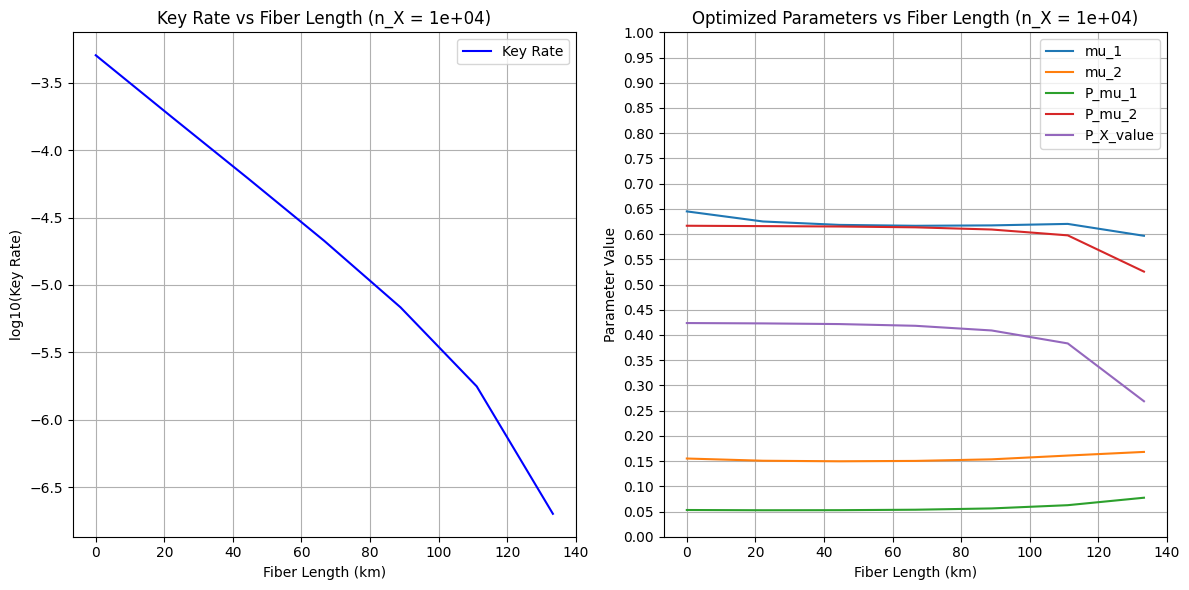


Plotting results for n_X = 1e+05


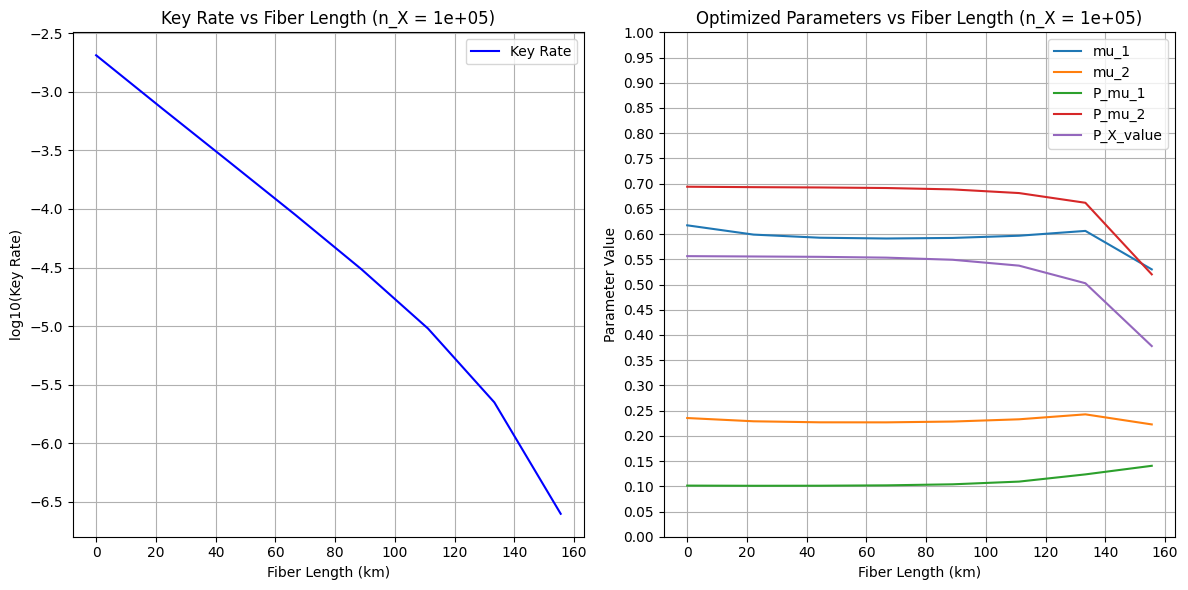


Plotting results for n_X = 1e+06


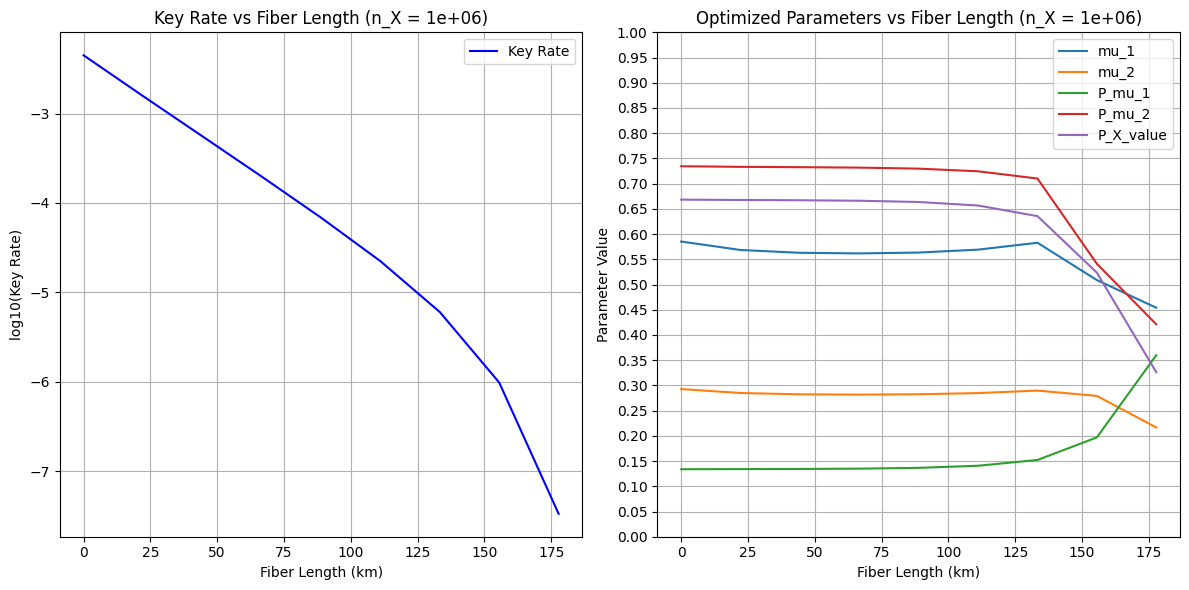


Plotting results for n_X = 1e+07


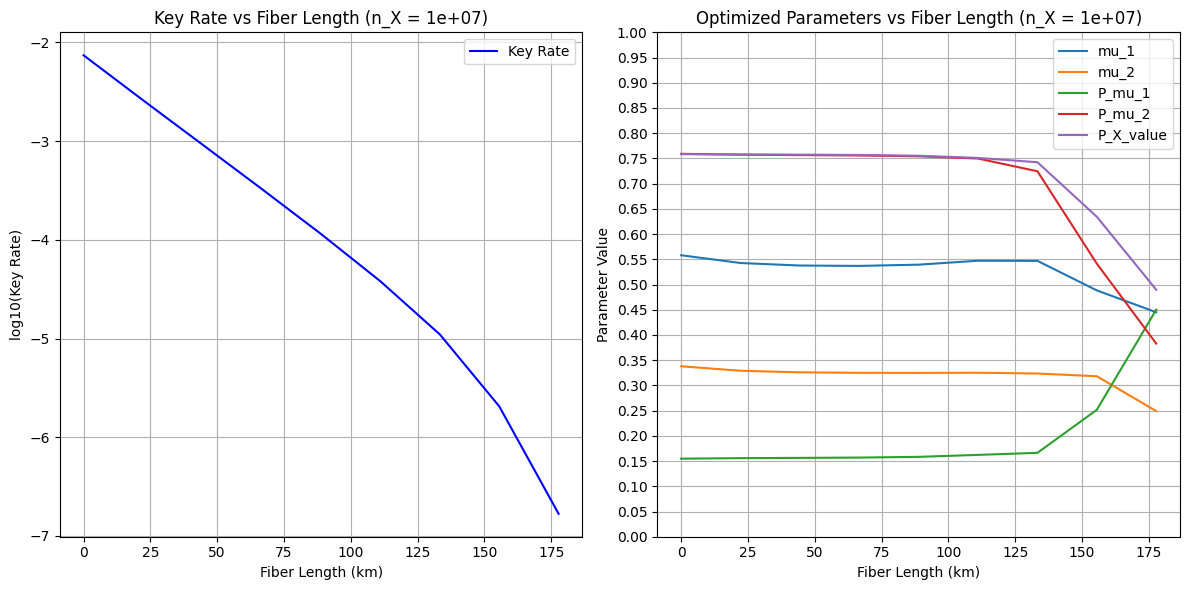


Plotting results for n_X = 1e+08


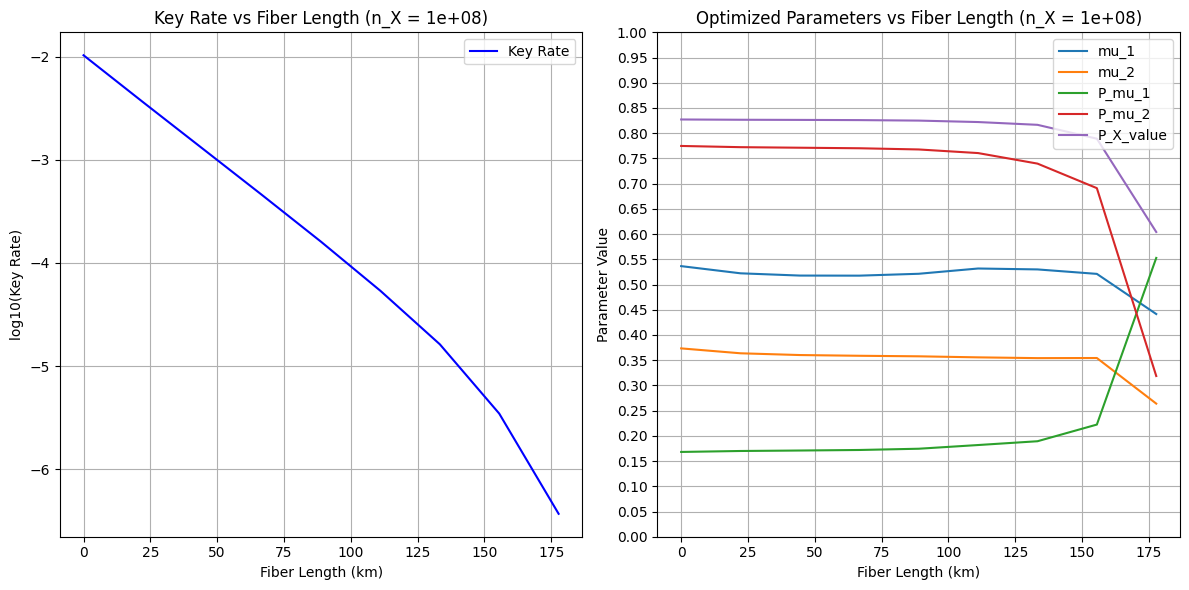


Plotting results for n_X = 1e+09


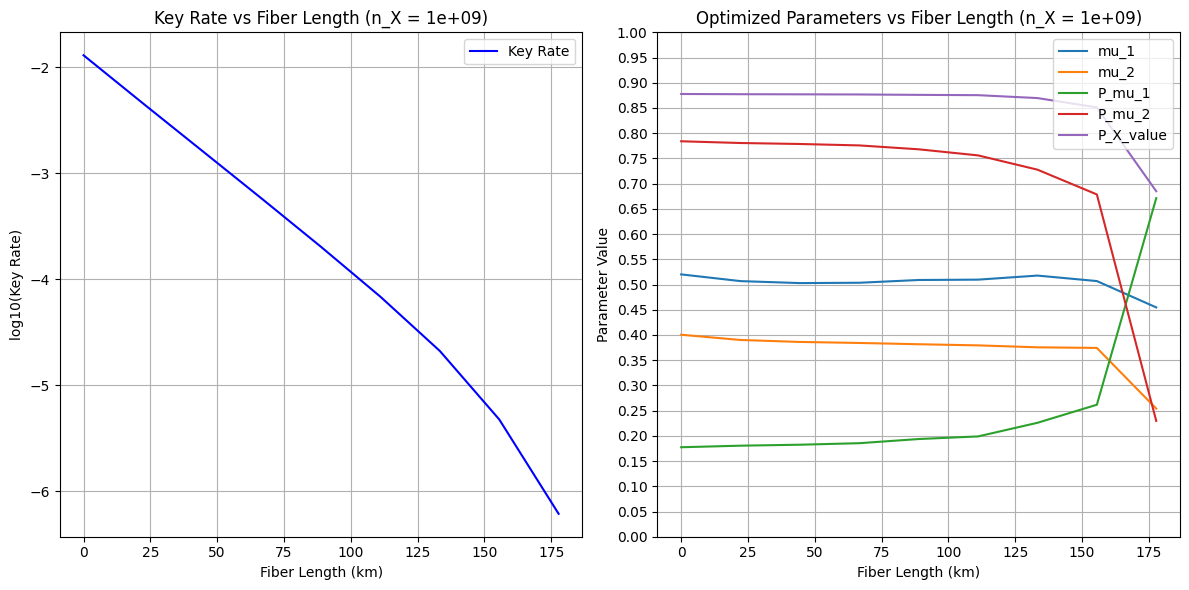

In [ ]:
# Load dataset
with open("qkd_grouped_dataset_20250217_190951.json", 'r') as f:
    dataset = json.load(f)

# Print available n_X values
print("Available n_X values:", list(dataset.keys())[:5])  # Print first 5 unique n_X values

# List of n_X values to plot
n_X_values = [10**s for s in range(4, 10)]  # Generates [10^4, 10^5, ..., 10^9]

# Loop through n_X values and plot
for n_X in n_X_values:
    print(f"\nPlotting results for n_X = {n_X:.0e}")
    plot_for_nx(dataset, n_X)

Available n_X values: ['10000.0', '100000.0', '1000000.0', '10000000.0', '100000000.0', '1000000000.0']


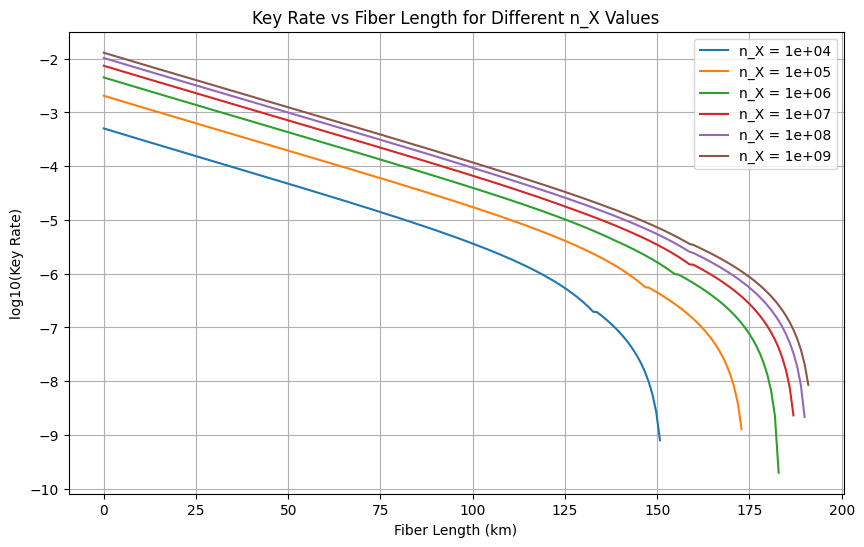

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
with open("qkd_grouped_dataset_20250206_223840.json", 'r') as f:
    dataset = json.load(f)

# Print available keys (debugging)
print("Available n_X values:", list(dataset.keys()))  

# Define n_X values
n_X_values = [10**s for s in range(4, 10)]  # [10^4, 10^5, ..., 10^9]

# Initialize figure
plt.figure(figsize=(10, 6))

# Plot key rate vs fiber length for each n_X
for n_X in n_X_values:
    target_nx_str = str(float(n_X))  # Ensure correct format

    if target_nx_str not in dataset:
        print(f"❌ No data found for n_X = {n_X}")
        continue

    filtered_data = dataset[target_nx_str]
    filtered_data = [entry for entry in filtered_data if entry["key_rate"] > 1e-30]  

    if not filtered_data:
        print(f"⚠️ No non-zero key rates for n_X = {n_X}")
        continue

    # Extract fiber lengths and key rates
    fiber_lengths = [entry["fiber_length"] for entry in filtered_data]
    key_rates = [entry["key_rate"] for entry in filtered_data]

    # Plot with unique colors and dashed lines
    plt.plot(fiber_lengths, np.log10(key_rates), linestyle='-', label=f"n_X = {n_X:.0e}")

# Graph formatting
plt.xlabel("Fiber Length (km)")
plt.ylabel("log10(Key Rate)")
plt.title("Key Rate vs Fiber Length for Different n_X Values")
plt.legend()
plt.grid(True)

# Save and show plot
plt.savefig("key_rate_vs_fiber_length.png", dpi=300, bbox_inches="tight")
plt.show()